# INSTALL

In [1]:
# !pip install -q faiss-cpu sentence-transformers transformers torch torchvision accelerate safetensors networkx

# IMPORTS

In [2]:
import os
import gc
import json
import torch
import faiss
import pickle
import warnings
import numpy as np
import igraph as ig
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict, deque
from sentence_transformers import SentenceTransformer
from transformers import (
    CLIPProcessor, CLIPModel,
    AutoTokenizer, AutoModelForCausalLM
)
warnings.filterwarnings('ignore')


/home/jay/miniconda3/envs/adl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONSTANTS & CONFIG


In [3]:
@dataclass
class Config:
    DATASET_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/Dataset'
    DATABASE_JSON: str = f'{DATASET_PATH}/database.json'
    TRAIN_CSV: str = f'{DATASET_PATH}/train_set.csv'
    TEST_CSV: str = f'{DATASET_PATH}/test_public.csv'
    IMAGE_DIR: str = f'{DATASET_PATH}/database_images_compressed90'

    PRECOMPUTED_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/eventa_embeddings_Qwen3'
    EMBEDDINGS_FILE: str = f'{PRECOMPUTED_PATH}/database_embeddings_Qwen3.npy'
    ARTICLE_IDS_FILE: str = f'{PRECOMPUTED_PATH}/database_article_ids_Qwen3.npy'
    FAISS_INDEX_FILE: str = f'{PRECOMPUTED_PATH}/database_faiss_index_Qwen3.bin'

    GRAPH_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/semantic_graphs_output/graph_semantic.pkl'
    NODE_MAPPING_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/semantic_graphs_output/node_mapping_semantic.json'

    EMBEDDING_MODEL: str = 'Qwen/Qwen3-Embedding-0.6B'
    ARTICLE_RERANKER_MODEL: str = 'Qwen/Qwen3-Reranker-0.6B'
    CLIP_MODEL: str = "openai/clip-vit-large-patch14"

    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    EMBEDDING_BATCH_SIZE: int = 64
    RERANK_BATCH_SIZE: int = 64
    IMG_BATCH: int = 32

    TOP_K_ARTICLES: int = 100
    TOP_K_ARTICLES_RERANK: int = 20
    TOP_K_IMAGES: int = 10

    MAX_RERANKER_LENGTH: int = 4096
    MAX_DOC_CHARS: int = 2000
    MAX_CLIP_TOKENS: int = 75

    GRAPH_HOPS: int = 5
    MAX_GRAPH_CANDIDATES: int = 200
    MAX_IMAGES_PER_ARTICLE: int = 5

    GRAPH_EXPANSION_MODE: str = "weighted_hops"
    PER_NODE_TOPK: int = 20

    TRAIN_VAL_SPLIT: float = 0.999
    RANDOM_SEED: int = 42

config = Config()
print("Device:", config.DEVICE)

Device: cuda


# UTILITY FUNCTIONS

In [4]:
def load_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def train_val_split(df, split_ratio=0.9, seed=42):
    train = df.sample(frac=split_ratio, random_state=seed)
    val = df.drop(train.index)
    return train.reset_index(drop=True), val.reset_index(drop=True)

def normalize_embeddings(E):
    E = E.astype(np.float32)
    faiss.normalize_L2(E)
    return E

def load_graph(graph_path, node_map_path):
    with open(graph_path, 'rb') as f:
        g = pickle.load(f)

    with open(node_map_path, 'r', encoding='utf-8') as f:
        node_map = json.load(f)

    edge_list = g.get('edge_list', [])

    adj = defaultdict(set)

    adj_w = defaultdict(dict)

    for a, b, w in edge_list:
        a_i = int(a)
        b_i = int(b)
        w_f = float(w)
        adj[a_i].add(b_i)
        adj[b_i].add(a_i)

        prev = adj_w[a_i].get(b_i, None)
        if prev is None or w_f > prev:
            adj_w[a_i][b_i] = w_f
        prev = adj_w[b_i].get(a_i, None)
        if prev is None or w_f > prev:
            adj_w[b_i][a_i] = w_f

    idx_to_aid = {int(k): v for k, v in node_map.items()}
    aid_to_idx = {v: int(k) for k, v in node_map.items()}

    return adj, adj_w, idx_to_aid, aid_to_idx

def expand_candidates_via_graph(
    seed_article_ids,
    graph_adj,
    aid_to_idx,
    idx_to_aid,
    graph_weights=None,
    mode="lrp",
    hops=1,
    max_candidates=200,
    topk_per_node=None,
    query_emb=None,
    embeddings=None
):
    if topk_per_node is None:
        topk_per_node = config.PER_NODE_TOPK

    seed_idxs = []
    for aid in seed_article_ids:
        if aid in aid_to_idx:
            seed_idxs.append(aid_to_idx[aid])
    if not seed_idxs:
        return []

    if mode == "lrp":
        return lrp_score_neighbors(
            query_emb,
            seed_idxs,
            embeddings,
            graph_weights,
            idx_to_aid,
            max_candidates
        )

    return []

def lrp_score_neighbors(query_emb, seed_idxs, embeddings, graph_adj_w, idx_to_aid, max_candidates):
    query_emb = torch.tensor(query_emb, dtype=torch.float32, device="cuda")
    embeddings = torch.tensor(embeddings, dtype=torch.float32, device="cuda")

    seed_set = set(seed_idxs)
    scores = {}

    qsim_all = embeddings @ query_emb

    for s in seed_idxs:
        nbrs = list(graph_adj_w.get(s, {}).keys())
        if not nbrs:
            continue

        nbrs_tensor = torch.tensor(nbrs, dtype=torch.long, device="cuda")
        weights = torch.tensor([graph_adj_w[s][n] for n in nbrs], dtype=torch.float32, device="cuda")

        mask = torch.tensor([n not in seed_set for n in nbrs], dtype=torch.bool, device="cuda")
        if mask.sum() == 0:
            continue

        nbrs_tensor = nbrs_tensor[mask]
        weights = weights[mask]

        qsim_nbrs = qsim_all[nbrs_tensor]

        qsim_s = qsim_all[s]

        score_vals = 0.7 * qsim_nbrs + 0.3 * (qsim_s * weights)

        score_vals = score_vals.detach().cpu()
        nbrs_tensor_cpu = nbrs_tensor.cpu()

        for nbr_i, val in zip(nbrs_tensor_cpu.tolist(), score_vals.tolist()):
            if nbr_i not in scores:
                scores[nbr_i] = val

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)

    selected = [idx_to_aid[n] for n, _ in ranked[:max_candidates]]
    seeds_as_aid = [idx_to_aid[s] for s in seed_idxs]

    out = seeds_as_aid + selected
    return out[:max_candidates]

# METRIC FUNCTIONS

In [5]:
def compute_recall_at_k(pred, gt, k):
    hit = sum(1 for p, g in zip(pred, gt) if g in p[:k])
    return hit / len(gt)

def compute_mrr(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def compute_map(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def evaluate_retrieval(pred, gt, name):
    print(f"\n{name} Metrics:")
    metrics = {
        "mAP": compute_map(pred, gt),
        "MRR": compute_mrr(pred, gt),
        "Recall@1": compute_recall_at_k(pred, gt, 1),
        "Recall@5": compute_recall_at_k(pred, gt, 5),
        "Recall@10": compute_recall_at_k(pred, gt, 10),
        "Recall@20": compute_recall_at_k(pred, gt, 20),
        "Recall@50": compute_recall_at_k(pred, gt, 50),
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics


# DATALOADER/DATASET

In [6]:
database = load_json(config.DATABASE_JSON)
train_df = pd.read_csv(config.TRAIN_CSV)
train_df, val_df = train_val_split(train_df, config.TRAIN_VAL_SPLIT, config.RANDOM_SEED)

article_image_map = defaultdict(list)
for aid, data in database.items():
    imgs = data.get("images", []) or []
    for img in imgs:
        if isinstance(img, str):
            iid = os.path.splitext(os.path.basename(img))[0]
            article_image_map[aid].append(iid)
            continue
        if isinstance(img, dict):
            for key in ["image_id","id","file_name","filename","path","file"]:
                if key in img:
                    iid = os.path.splitext(os.path.basename(img[key]))[0]
                    article_image_map[aid].append(iid)
                    break

print("Train:", len(train_df), "Val:", len(val_df))

Train: 22018 Val: 22


# ARCHITECTURE

## EMBEDDING & FAISS

In [7]:
def load_embedding_model():
    m = SentenceTransformer(config.EMBEDDING_MODEL, device=config.DEVICE, trust_remote_code=True)
    if config.DEVICE == 'cuda':
        m.half()
    return m

def generate_embeddings(model, texts, batch=64):
    out = []
    for i in tqdm(range(0, len(texts), batch)):
        b = model.encode(texts[i:i+batch], convert_to_numpy=True)
        out.append(b)
    return np.vstack(out)

def search_index(index, Q, k):
    Q = normalize_embeddings(Q)
    dist, idx = index.search(Q, k)
    return dist, idx

## QWEN3 RERANKER

In [8]:
def load_qwen3_reranker():
    tok = AutoTokenizer.from_pretrained(config.ARTICLE_RERANKER_MODEL, trust_remote_code=True, padding_side='left')
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    model = AutoModelForCausalLM.from_pretrained(
        config.ARTICLE_RERANKER_MODEL,
        torch_dtype=torch.float16 if config.DEVICE=='cuda' else torch.float32,
        trust_remote_code=True
    ).to(config.DEVICE)
    model.eval()
    prefix = "<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\".\n<|im_end|>\n<|im_start|>user\n"
    suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"
    pre = tok.encode(prefix, add_special_tokens=False)
    suf = tok.encode(suffix, add_special_tokens=False)
    yes_id = tok.convert_tokens_to_ids("yes") or tok.convert_tokens_to_ids("Yes")
    no_id  = tok.convert_tokens_to_ids("no")  or tok.convert_tokens_to_ids("No")
    return tok, model, pre, suf, yes_id, no_id

reranker_tokenizer, reranker_model, prefix_tokens, suffix_tokens, yes_id, no_id = load_qwen3_reranker()

def format_instruction(query, doc):
    return f"<Instruct>: Determine relevance\n<Query>: {query}\n<Document>: {doc}"

def process_inputs(pairs):
    toks = reranker_tokenizer(pairs, add_special_tokens=False, padding=False, truncation='longest_first')
    for i, ids in enumerate(toks['input_ids']):
        toks['input_ids'][i] = prefix_tokens + ids + suffix_tokens
    toks = reranker_tokenizer.pad(
        {"input_ids": toks['input_ids']},
        padding=True, return_tensors="pt",
        max_length=config.MAX_RERANKER_LENGTH
    )
    return {k: v.to(config.DEVICE) for k, v in toks.items()}

@torch.no_grad()
def compute_yes_scores(inputs):
    logits = reranker_model(**inputs).logits[:, -1, :]
    pair = torch.stack([logits[:, no_id], logits[:, yes_id]], dim=1)
    probs = torch.nn.functional.log_softmax(pair, dim=1)
    return probs[:,1].exp().cpu().tolist()

def rerank_articles(query, article_ids, batch_size=4):
    pairs = []
    for aid in article_ids:
        art = database[aid]
        title = art.get("title", "")[:200]
        content = art.get("content", "")[:config.MAX_DOC_CHARS]
        doc = f"Title: {title}\nContent: {content}"
        pairs.append(format_instruction(query, doc))
    scores = []
    for i in range(0, len(pairs), batch_size):
        batch_pairs = pairs[i:i+batch_size]
        inp = process_inputs(batch_pairs)
        s = compute_yes_scores(inp)
        scores.extend(s)
        torch.cuda.empty_cache()
    ranked = sorted(zip(article_ids, scores), key=lambda x: x[1], reverse=True)
    return [a for a,_ in ranked[:config.TOP_K_ARTICLES_RERANK]]

## IMAGE RERANKER

In [9]:
clip_model = CLIPModel.from_pretrained(config.CLIP_MODEL).to(config.DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained(config.CLIP_MODEL)

def path_for(img_id):
    if "." not in img_id:
        return os.path.join(config.IMAGE_DIR, f"{img_id}.jpg")
    return os.path.join(config.IMAGE_DIR, img_id)

@torch.no_grad()
def rerank_images_clip(query, image_ids, top_k):
    text_inputs = clip_processor.tokenizer(
        query,
        truncation=True,
        max_length=config.MAX_CLIP_TOKENS,
        return_tensors="pt",
    )
    query = clip_processor.tokenizer.decode(text_inputs["input_ids"][0], skip_special_tokens=True)
    images = []
    valid = []
    for iid in image_ids:
        p = path_for(iid)
        try:
            images.append(Image.open(p).convert("RGB"))
            valid.append(iid)
        except:
            pass
    if not images:
        return ["#"] * top_k
    text_inputs = clip_processor(text=[query], return_tensors="pt").to(config.DEVICE)
    text_emb = clip_model.get_text_features(**text_inputs)
    all_embs = []
    for i in range(0, len(images), config.IMG_BATCH):
        batch_imgs = images[i:i+config.IMG_BATCH]
        inputs = clip_processor(images=batch_imgs, return_tensors="pt", padding=True).to(config.DEVICE)
        img_feats = clip_model.get_image_features(**inputs)
        all_embs.append(img_feats)
    img_emb = torch.cat(all_embs, dim=0)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    sims = (img_emb @ text_emb.T).squeeze(-1).cpu().numpy()
    ranked = sorted(zip(valid, sims), key=lambda x: x[1], reverse=True)
    return [iid for iid, _ in ranked[:top_k]]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# LOAD PRECOMPUTED

In [10]:
database_embeddings = np.load(config.EMBEDDINGS_FILE)
database_article_ids = np.load(config.ARTICLE_IDS_FILE, allow_pickle=True).tolist()
faiss_index = faiss.read_index(config.FAISS_INDEX_FILE)
embedding_model = load_embedding_model()

graph_adj, graph_adj_weighted, idx_to_aid, aid_to_idx = load_graph(config.GRAPH_PATH, config.NODE_MAPPING_PATH)

edges = []
weights = []
with open(config.GRAPH_PATH, 'rb') as f:
    graw = pickle.load(f)

for u, v, w in graw["edge_list"]:
    edges.append((int(u), int(v)))
    weights.append(float(w))

g_ig = ig.Graph(n=len(idx_to_aid), edges=edges)

plt.hist(weights, bins=50)
plt.title("Semantic Graph Edge Weight Distribution")
plt.savefig("graph_edge_weight_distribution.png", dpi=150)
plt.close()


# INFERENCE - VALIDATION

In [11]:
val_queries = val_df['caption'].tolist()
val_gt_articles = val_df['retrieved_article_id'].astype(str).tolist()
val_gt_images = val_df['retrieved_image_id'].astype(str).tolist()

Q = generate_embeddings(embedding_model, val_queries, config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)

_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
candidates = [[database_article_ids[i] for i in row] for row in idx]

reranked_articles = []
for i in tqdm(range(0, len(val_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = val_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        qe = embedding_model.encode([q], convert_to_numpy=True)
        qe = qe[0] / (np.linalg.norm(qe[0]) + 1e-10)
        expanded = expand_candidates_via_graph(
            seed_article_ids=c,
            graph_adj=graph_adj,
            aid_to_idx=aid_to_idx,
            idx_to_aid=idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode="lrp",
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK,
            query_emb=qe,
            embeddings=database_embeddings
        )
        batch_results.append(rerank_articles(q, expanded, batch_size=4))
    reranked_articles.extend(batch_results)

final_images = []
for q, arts in tqdm(zip(val_queries, reranked_articles), total=len(val_queries)):
    imgs = []
    for a in arts:
        all_imgs = article_image_map.get(a, [])
        limited = all_imgs[:config.MAX_IMAGES_PER_ARTICLE]
        imgs.extend(limited)
    final_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

article_metrics = evaluate_retrieval(reranked_articles, val_gt_articles, "Article Retrieval")
image_metrics = evaluate_retrieval(final_images, val_gt_images, "Image Retrieval")

baseline_top1 = [c[0] for c in candidates]
graph_top1 = [r[0] for r in reranked_articles]
agree = [1 if a==b else 0 for a,b in zip(baseline_top1, graph_top1)]

plt.scatter(range(len(agree)), agree, alpha=0.5)
plt.title("Top-1 Agreement: Baseline vs Graph")
plt.savefig("scatter_top1_baseline_vs_graph.png", dpi=150)
plt.close()

neighbor_counts = []
for q, c in zip(val_queries, candidates):
    qe = embedding_model.encode([q], convert_to_numpy=True)
    qe = qe[0] / (np.linalg.norm(qe[0]) + 1e-10)

    exp = expand_candidates_via_graph(
        seed_article_ids=c,
        graph_adj=graph_adj,
        aid_to_idx=aid_to_idx,
        idx_to_aid=idx_to_aid,
        graph_weights=graph_adj_weighted,
        mode="lrp",
        query_emb=qe,
        embeddings=database_embeddings,
        hops=config.GRAPH_HOPS,
        max_candidates=config.MAX_GRAPH_CANDIDATES,
        topk_per_node=config.PER_NODE_TOPK
    )

    neighbor_counts.append(len(set(exp) - set(c)))

plt.hist(neighbor_counts, bins=40)
plt.title("Graph Neighbor Expansion Counts")
plt.savefig("graph_neighbor_overlap.png", dpi=150)
plt.close()

qual = []
for idx in np.random.choice(len(val_queries), 5, replace=False):
    qual.append({
        "query": val_queries[idx],
        "baseline_top5": candidates[idx][:5],
        "graph_top5": reranked_articles[idx][:5]
    })

pd.DataFrame(qual).to_csv("qualitative_graph_comparison.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.40s/it]

100%|██████████| 1/1 [00:03<00:00,  3.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


100%|██████████| 1/1 [03:20<00:00, 200.12s/it]

100%|██████████| 1/1 [03:20<00:00, 200.12s/it]

  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:06<02:07,  6.05s/it]

  9%|▉         | 2/22 [00:09<01:35,  4.76s/it]

 14%|█▎        | 3/22 [00:17<01:57,  6.19s/it]

 18%|█▊        | 4/22 [00:19<01:21,  4.51s/it]

 23%|██▎       | 5/22 [00:21<01:02,  3.67s/it]

 27%|██▋       | 6/22 [00:31<01:30,  5.66s/it]

 32%|███▏      | 7/22 [00:38<01:33,  6.23s/it]

 36%|███▋      | 8/22 [00:48<01:44,  7.46s/it]

 41%|████      | 9/22 [00:50<01:13,  5.64s/it]

 45%|████▌     | 10/22 [00:51<00:51,  4.31s/it]

 50%|█████     | 11/22 [01:03<01:12,  6.56s/it]

 55%|█████▍    | 12/22 [01:06<00:53,  5.35s/it]

 59%|█████▉    | 13/22 [01:09<00:42,  4.72s/it]

 64%|██████▎   | 14/22 [01:12<00:34,  4.26s/it]

 68%|██████▊   | 15/22 [01:33<01:05,  9.31s/it]

 73%|███████▎  | 16/22 [01:39<00:49,  8.18s/it]

 77%|███████▋  | 17/22 [01:45<00:37,  7.55s/it]

 82%|████████▏ | 18/22 [01:47<00:23,  5.86s/it]

 86%|████████▋ | 19/22 [01:49<00:14,  4.73s/it]

 91%|█████████ | 20/22 [01:50<00:07,  3.80s/it]

 95%|█████████▌| 21/22 [01:57<00:04,  4.56s/it]

100%|██████████| 22/22 [01:59<00:00,  3.82s/it]

100%|██████████| 22/22 [01:59<00:00,  5.43s/it]


Article Retrieval Metrics:
mAP: 0.5736
MRR: 0.5736
Recall@1: 0.4545
Recall@5: 0.7273
Recall@10: 0.7727
Recall@20: 0.8182
Recall@50: 0.8182

Image Retrieval Metrics:
mAP: 0.4386
MRR: 0.4386
Recall@1: 0.3182
Recall@5: 0.6818
Recall@10: 0.7273
Recall@20: 0.7273
Recall@50: 0.7273


# VISUALIZATION

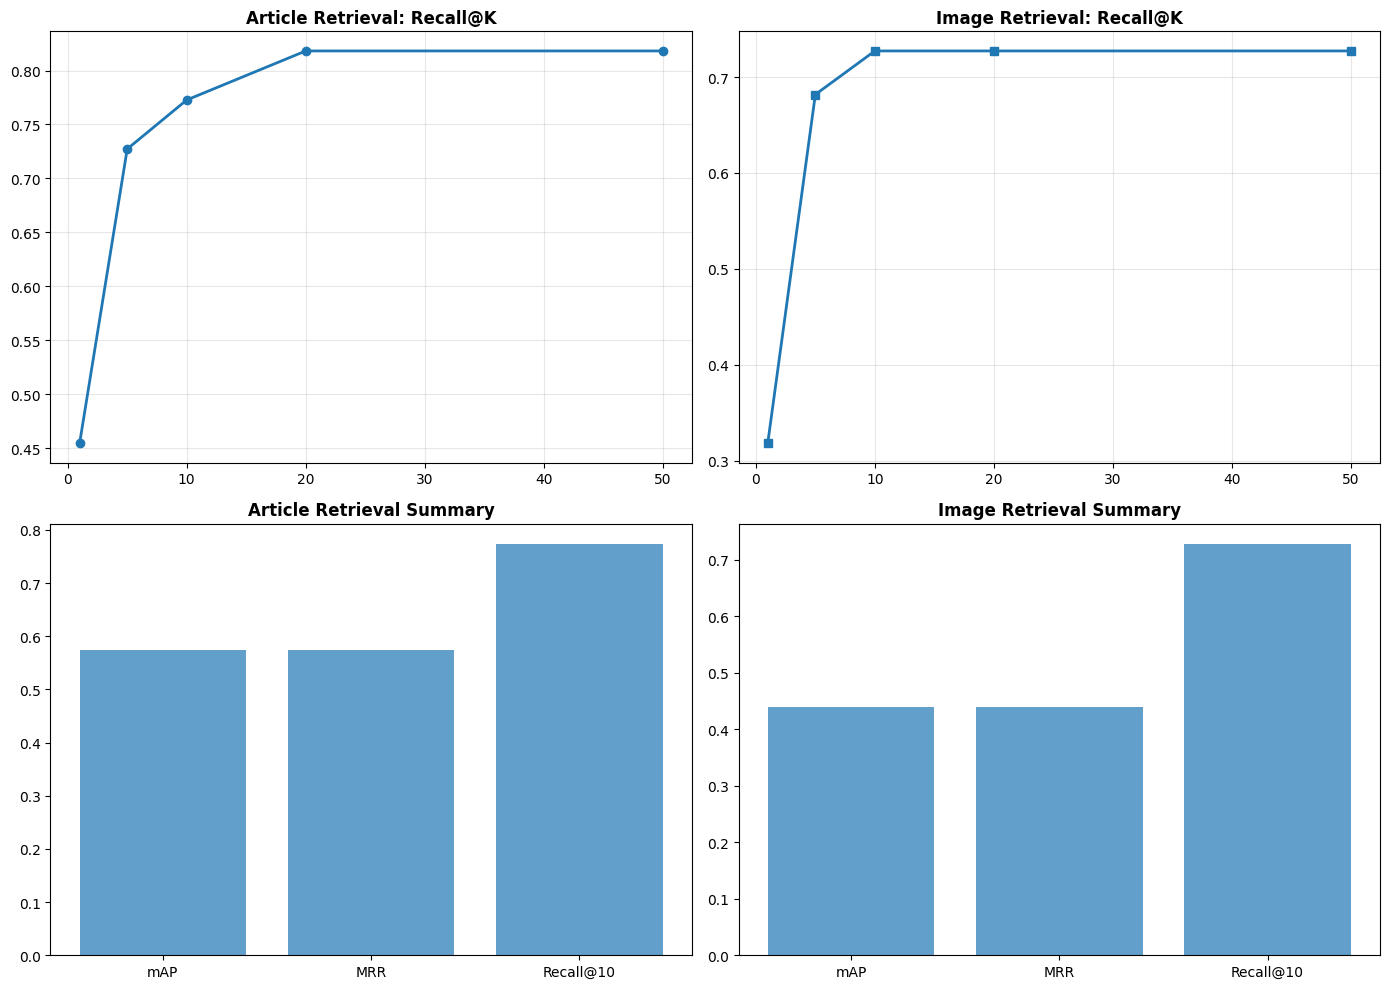

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
k_vals = [1, 5, 10, 20, 50]
article_recalls = [article_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 0].plot(k_vals, article_recalls, marker='o', linewidth=2)
axes[0, 0].set_title("Article Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

image_recalls = [image_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 1].plot(k_vals, image_recalls, marker='s', linewidth=2)
axes[0, 1].set_title("Image Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

article_summary_keys = ["mAP", "MRR", "Recall@10"]
article_summary_vals = [article_metrics[k] for k in article_summary_keys]
axes[1, 0].bar(article_summary_keys, article_summary_vals, alpha=0.7)
axes[1, 0].set_title("Article Retrieval Summary", fontsize=12, fontweight='bold')

image_summary_keys = ["mAP", "MRR", "Recall@10"]
image_summary_vals = [image_metrics[k] for k in image_summary_keys]
axes[1, 1].bar(image_summary_keys, image_summary_vals, alpha=0.7)
axes[1, 1].set_title("Image Retrieval Summary", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("qwen3_results.png", dpi=150)
plt.show()


# TEST INFERENCE & SUBMISSION

In [13]:
test_df = pd.read_csv(config.TEST_CSV)
test_queries = test_df['query_text'].tolist()
test_ids = test_df['query_index'].tolist()

Q = generate_embeddings(embedding_model, test_queries, batch=config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)
_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
test_candidates = [[database_article_ids[i] for i in row] for row in idx]

test_articles = []
for i in tqdm(range(0, len(test_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = test_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = test_candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        qe = embedding_model.encode([q], convert_to_numpy=True)
        qe = qe[0] / (np.linalg.norm(qe[0]) + 1e-10)
        expanded = expand_candidates_via_graph(
            seed_article_ids=c,
            graph_adj=graph_adj,
            aid_to_idx=aid_to_idx,
            idx_to_aid=idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode="lrp",
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK,
            query_emb=qe,
            embeddings=database_embeddings
        )
        batch_results.append(rerank_articles(q, expanded, batch_size=4))
    test_articles.extend(batch_results)

test_images = []
for q, arts in tqdm(zip(test_queries, test_articles), total=len(test_queries)):
    imgs = []
    for a in arts:
        all_imgs = article_image_map.get(a, [])
        limited = all_imgs[:config.MAX_IMAGES_PER_ARTICLE]
        imgs.extend(limited)
    test_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

rows = []
for qid, imgs in zip(test_ids, test_images):
    rows.append([qid] + imgs + ["#"]*(config.TOP_K_IMAGES-len(imgs)))

sub = pd.DataFrame(rows, columns=["query_id"]+[f"image_id_{i+1}" for i in range(config.TOP_K_IMAGES)])
sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")


  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:00<00:27,  1.65it/s]

  4%|▍         | 2/47 [00:01<00:21,  2.07it/s]

  6%|▋         | 3/47 [00:01<00:20,  2.18it/s]

  9%|▊         | 4/47 [00:01<00:19,  2.20it/s]

 11%|█         | 5/47 [00:02<00:18,  2.32it/s]

 13%|█▎        | 6/47 [00:02<00:17,  2.28it/s]

 15%|█▍        | 7/47 [00:03<00:17,  2.32it/s]

 17%|█▋        | 8/47 [00:03<00:21,  1.81it/s]

 19%|█▉        | 9/47 [00:04<00:19,  1.99it/s]

 21%|██▏       | 10/47 [00:04<00:19,  1.94it/s]

 23%|██▎       | 11/47 [00:05<00:20,  1.77it/s]

 26%|██▌       | 12/47 [00:05<00:18,  1.92it/s]

 28%|██▊       | 13/47 [00:06<00:16,  2.03it/s]

 30%|██▉       | 14/47 [00:07<00:19,  1.69it/s]

 32%|███▏      | 15/47 [00:07<00:17,  1.85it/s]

 34%|███▍      | 16/47 [00:08<00:17,  1.76it/s]

 36%|███▌      | 17/47 [00:08<00:16,  1.77it/s]

 38%|███▊      | 18/47 [00:09<00:14,  1.96it/s]

 40%|████      | 19/47 [00:09<00:13,  2.08it/s]

 43%|████▎     | 20/47 [00:10<00:12,  2.20it/s]

 45%|████▍     | 21/47 [00:10<00:11,  2.22it/s]

 47%|████▋     | 22/47 [00:10<00:10,  2.29it/s]

 49%|████▉     | 23/47 [00:11<00:10,  2.32it/s]

 51%|█████     | 24/47 [00:11<00:11,  1.99it/s]

 53%|█████▎    | 25/47 [00:12<00:11,  1.90it/s]

 55%|█████▌    | 26/47 [00:13<00:12,  1.64it/s]

 57%|█████▋    | 27/47 [00:13<00:11,  1.80it/s]

 60%|█████▉    | 28/47 [00:14<00:09,  1.98it/s]

 62%|██████▏   | 29/47 [00:14<00:09,  1.83it/s]

 64%|██████▍   | 30/47 [00:15<00:10,  1.57it/s]

 66%|██████▌   | 31/47 [00:16<00:08,  1.78it/s]

 68%|██████▊   | 32/47 [00:16<00:07,  2.03it/s]

 70%|███████   | 33/47 [00:16<00:06,  2.16it/s]

 72%|███████▏  | 34/47 [00:17<00:05,  2.28it/s]

 74%|███████▍  | 35/47 [00:17<00:04,  2.43it/s]

 77%|███████▋  | 36/47 [00:17<00:04,  2.39it/s]

 79%|███████▊  | 37/47 [00:18<00:04,  2.33it/s]

 81%|████████  | 38/47 [00:18<00:03,  2.27it/s]

 83%|████████▎ | 39/47 [00:19<00:03,  2.20it/s]

 85%|████████▌ | 40/47 [00:19<00:03,  2.11it/s]

 87%|████████▋ | 41/47 [00:20<00:02,  2.10it/s]

 89%|████████▉ | 42/47 [00:20<00:02,  2.02it/s]

 91%|█████████▏| 43/47 [00:21<00:02,  2.00it/s]

 94%|█████████▎| 44/47 [00:22<00:01,  1.84it/s]

 96%|█████████▌| 45/47 [00:22<00:01,  1.87it/s]

 98%|█████████▊| 46/47 [00:22<00:00,  1.98it/s]

100%|██████████| 47/47 [00:23<00:00,  2.06it/s]

100%|██████████| 47/47 [00:23<00:00,  2.01it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [10:43<8:13:16, 643.41s/it]

  4%|▍         | 2/47 [21:40<8:08:38, 651.53s/it]

  6%|▋         | 3/47 [32:37<7:59:34, 653.96s/it]

  9%|▊         | 4/47 [44:18<8:01:56, 672.47s/it]

 11%|█         | 5/47 [55:40<7:53:13, 676.04s/it]

 13%|█▎        | 6/47 [1:06:31<7:36:01, 667.36s/it]

 15%|█▍        | 7/47 [1:17:25<7:22:05, 663.14s/it]

 17%|█▋        | 8/47 [1:28:32<7:11:53, 664.45s/it]

 19%|█▉        | 9/47 [1:41:25<7:22:14, 698.27s/it]

 21%|██▏       | 10/47 [1:54:27<7:26:34, 724.16s/it]

 23%|██▎       | 11/47 [2:07:42<7:27:24, 745.69s/it]

 26%|██▌       | 12/47 [2:20:48<7:22:09, 758.00s/it]

 28%|██▊       | 13/47 [2:34:01<7:15:37, 768.74s/it]

 30%|██▉       | 14/47 [2:46:53<7:03:17, 769.61s/it]

 32%|███▏      | 15/47 [2:58:02<6:34:18, 739.34s/it]

 34%|███▍      | 16/47 [3:08:53<6:08:10, 712.59s/it]

 36%|███▌      | 17/47 [3:19:51<5:48:07, 696.26s/it]

 38%|███▊      | 18/47 [3:30:48<5:30:50, 684.50s/it]

 40%|████      | 19/47 [3:41:50<5:16:21, 677.90s/it]

 43%|████▎     | 20/47 [3:52:59<5:03:47, 675.10s/it]

 45%|████▍     | 21/47 [4:03:55<4:50:02, 669.34s/it]

 47%|████▋     | 22/47 [4:14:57<4:38:02, 667.28s/it]

 49%|████▉     | 23/47 [4:25:52<4:25:25, 663.57s/it]

 51%|█████     | 24/47 [4:37:00<4:14:53, 664.92s/it]

 53%|█████▎    | 25/47 [4:47:46<4:01:42, 659.20s/it]

 55%|█████▌    | 26/47 [4:58:35<3:49:37, 656.09s/it]

 57%|█████▋    | 27/47 [5:09:32<3:38:47, 656.38s/it]

 60%|█████▉    | 28/47 [5:20:24<3:27:23, 654.91s/it]

 62%|██████▏   | 29/47 [5:31:23<3:16:54, 656.33s/it]

 64%|██████▍   | 30/47 [5:42:26<3:06:32, 658.36s/it]

 66%|██████▌   | 31/47 [5:53:16<2:54:50, 655.68s/it]

 68%|██████▊   | 32/47 [6:04:05<2:43:24, 653.62s/it]

 70%|███████   | 33/47 [6:14:56<2:32:19, 652.84s/it]

 72%|███████▏  | 34/47 [6:25:49<2:21:30, 653.09s/it]

 74%|███████▍  | 35/47 [6:36:59<2:11:36, 658.03s/it]

 77%|███████▋  | 36/47 [6:48:01<2:00:52, 659.31s/it]

 79%|███████▊  | 37/47 [6:58:54<1:49:34, 657.42s/it]

 81%|████████  | 38/47 [7:10:01<1:39:01, 660.20s/it]

 83%|████████▎ | 39/47 [7:20:52<1:27:40, 657.56s/it]

 85%|████████▌ | 40/47 [7:31:44<1:16:31, 655.92s/it]

 87%|████████▋ | 41/47 [7:42:13<1:04:45, 647.65s/it]

 89%|████████▉ | 42/47 [7:53:05<54:05, 649.04s/it]  

 91%|█████████▏| 43/47 [8:05:19<44:58, 674.55s/it]

 94%|█████████▎| 44/47 [8:16:20<33:30, 670.31s/it]

 96%|█████████▌| 45/47 [8:27:49<22:32, 676.04s/it]

 98%|█████████▊| 46/47 [8:39:53<11:30, 690.49s/it]

100%|██████████| 47/47 [8:54:28<00:00, 745.77s/it]

100%|██████████| 47/47 [8:54:28<00:00, 682.31s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [00:22<19:06:38, 22.94s/it]

  0%|          | 2/3000 [00:40<16:37:41, 19.97s/it]

  0%|          | 3/3000 [00:47<11:36:02, 13.93s/it]

  0%|          | 4/3000 [01:00<11:24:44, 13.71s/it]

  0%|          | 5/3000 [01:26<14:55:57, 17.95s/it]

  0%|          | 6/3000 [01:45<15:15:39, 18.35s/it]

  0%|          | 7/3000 [01:53<12:31:47, 15.07s/it]

  0%|          | 8/3000 [02:17<14:46:47, 17.78s/it]

  0%|          | 9/3000 [02:26<12:22:32, 14.90s/it]

  0%|          | 10/3000 [02:37<11:27:46, 13.80s/it]

  0%|          | 11/3000 [02:41<8:54:27, 10.73s/it] 

  0%|          | 12/3000 [02:49<8:25:26, 10.15s/it]

  0%|          | 13/3000 [03:16<12:25:50, 14.98s/it]

  0%|          | 14/3000 [03:22<10:13:27, 12.33s/it]

  0%|          | 15/3000 [03:31<9:25:27, 11.37s/it] 

  1%|          | 16/3000 [03:37<8:10:29,  9.86s/it]

  1%|          | 17/3000 [03:39<6:11:53,  7.48s/it]

  1%|          | 18/3000 [03:48<6:28:29,  7.82s/it]

  1%|          | 19/3000 [03:53<5:43:11,  6.91s/it]

  1%|          | 20/3000 [03:57<5:09:41,  6.24s/it]

  1%|          | 21/3000 [04:10<6:39:29,  8.05s/it]

  1%|          | 22/3000 [04:20<7:08:21,  8.63s/it]

  1%|          | 23/3000 [04:37<9:22:00, 11.33s/it]

  1%|          | 24/3000 [04:43<8:05:03,  9.78s/it]

  1%|          | 25/3000 [04:54<8:18:00, 10.04s/it]

  1%|          | 26/3000 [05:03<7:57:51,  9.64s/it]

  1%|          | 27/3000 [05:12<7:51:40,  9.52s/it]

  1%|          | 28/3000 [05:16<6:33:10,  7.94s/it]

  1%|          | 29/3000 [05:19<5:20:07,  6.47s/it]

  1%|          | 30/3000 [05:25<5:16:05,  6.39s/it]

  1%|          | 31/3000 [05:31<5:05:15,  6.17s/it]

  1%|          | 32/3000 [05:49<8:01:25,  9.73s/it]

  1%|          | 33/3000 [06:03<9:10:31, 11.13s/it]

  1%|          | 34/3000 [06:25<11:51:12, 14.39s/it]

  1%|          | 35/3000 [06:34<10:24:12, 12.63s/it]

  1%|          | 36/3000 [06:49<11:04:42, 13.46s/it]

  1%|          | 37/3000 [06:55<9:07:52, 11.09s/it] 

  1%|▏         | 38/3000 [07:01<7:57:35,  9.67s/it]

  1%|▏         | 39/3000 [07:11<7:56:12,  9.65s/it]

  1%|▏         | 40/3000 [07:21<8:04:03,  9.81s/it]

  1%|▏         | 41/3000 [07:34<8:56:39, 10.88s/it]

  1%|▏         | 42/3000 [07:38<7:06:41,  8.65s/it]

  1%|▏         | 43/3000 [07:46<6:57:22,  8.47s/it]

  1%|▏         | 44/3000 [07:51<6:09:49,  7.51s/it]

  2%|▏         | 45/3000 [08:05<7:41:07,  9.36s/it]

  2%|▏         | 46/3000 [08:19<8:48:46, 10.74s/it]

  2%|▏         | 47/3000 [08:29<8:40:36, 10.58s/it]

  2%|▏         | 48/3000 [08:38<8:10:46,  9.98s/it]

  2%|▏         | 49/3000 [08:41<6:33:28,  8.00s/it]

  2%|▏         | 50/3000 [08:50<6:50:18,  8.35s/it]

  2%|▏         | 51/3000 [09:22<12:38:14, 15.43s/it]

  2%|▏         | 52/3000 [09:34<11:45:39, 14.36s/it]

  2%|▏         | 53/3000 [09:55<13:18:44, 16.26s/it]

  2%|▏         | 54/3000 [10:17<14:52:22, 18.17s/it]

  2%|▏         | 55/3000 [10:42<16:27:53, 20.13s/it]

  2%|▏         | 56/3000 [11:02<16:21:46, 20.01s/it]

  2%|▏         | 57/3000 [11:11<13:46:17, 16.85s/it]

  2%|▏         | 58/3000 [11:21<11:56:49, 14.62s/it]

  2%|▏         | 59/3000 [11:23<8:55:05, 10.92s/it] 

  2%|▏         | 60/3000 [11:37<9:33:58, 11.71s/it]

  2%|▏         | 61/3000 [11:41<7:46:07,  9.52s/it]

  2%|▏         | 62/3000 [12:11<12:46:01, 15.64s/it]

  2%|▏         | 63/3000 [12:22<11:44:35, 14.39s/it]

  2%|▏         | 64/3000 [12:37<11:51:37, 14.54s/it]

  2%|▏         | 65/3000 [12:47<10:37:24, 13.03s/it]

  2%|▏         | 66/3000 [12:57<9:58:47, 12.25s/it] 

  2%|▏         | 67/3000 [13:11<10:26:43, 12.82s/it]

  2%|▏         | 68/3000 [13:48<16:11:22, 19.88s/it]

  2%|▏         | 69/3000 [14:16<18:22:08, 22.56s/it]

  2%|▏         | 70/3000 [14:24<14:35:12, 17.92s/it]

  2%|▏         | 71/3000 [14:37<13:35:02, 16.70s/it]

  2%|▏         | 72/3000 [14:46<11:38:23, 14.31s/it]

  2%|▏         | 73/3000 [14:59<11:16:21, 13.86s/it]

  2%|▏         | 74/3000 [15:14<11:34:32, 14.24s/it]

  2%|▎         | 75/3000 [15:38<13:59:52, 17.23s/it]

  3%|▎         | 76/3000 [15:50<12:41:32, 15.63s/it]

  3%|▎         | 77/3000 [16:04<12:17:50, 15.15s/it]

  3%|▎         | 78/3000 [16:14<10:53:05, 13.41s/it]

  3%|▎         | 79/3000 [16:26<10:39:30, 13.14s/it]

  3%|▎         | 80/3000 [16:56<14:43:18, 18.15s/it]

  3%|▎         | 81/3000 [17:22<16:34:39, 20.45s/it]

  3%|▎         | 82/3000 [17:27<12:54:20, 15.92s/it]

  3%|▎         | 83/3000 [17:41<12:32:02, 15.47s/it]

  3%|▎         | 84/3000 [17:52<11:23:51, 14.07s/it]

  3%|▎         | 85/3000 [17:57<9:03:02, 11.18s/it] 

  3%|▎         | 86/3000 [18:01<7:27:22,  9.21s/it]

  3%|▎         | 87/3000 [18:29<11:49:25, 14.61s/it]

  3%|▎         | 88/3000 [19:05<17:03:24, 21.09s/it]

  3%|▎         | 89/3000 [19:30<18:06:53, 22.40s/it]

  3%|▎         | 90/3000 [19:56<18:52:09, 23.34s/it]

  3%|▎         | 91/3000 [20:07<15:51:54, 19.63s/it]

  3%|▎         | 92/3000 [20:25<15:33:14, 19.26s/it]

  3%|▎         | 93/3000 [20:43<15:06:29, 18.71s/it]

  3%|▎         | 94/3000 [20:47<11:42:05, 14.50s/it]

  3%|▎         | 95/3000 [20:54<9:51:57, 12.23s/it] 

  3%|▎         | 96/3000 [21:00<8:18:16, 10.30s/it]

  3%|▎         | 97/3000 [21:06<7:16:40,  9.03s/it]

  3%|▎         | 98/3000 [21:12<6:36:57,  8.21s/it]

  3%|▎         | 99/3000 [21:25<7:38:35,  9.48s/it]

  3%|▎         | 100/3000 [21:36<8:04:58, 10.03s/it]

  3%|▎         | 101/3000 [22:05<12:45:53, 15.85s/it]

  3%|▎         | 102/3000 [22:21<12:38:21, 15.70s/it]

  3%|▎         | 103/3000 [22:45<14:40:51, 18.24s/it]

  3%|▎         | 104/3000 [23:09<16:07:56, 20.05s/it]

  4%|▎         | 105/3000 [23:11<11:39:01, 14.49s/it]

  4%|▎         | 106/3000 [23:27<11:57:05, 14.87s/it]

  4%|▎         | 107/3000 [23:40<11:34:43, 14.41s/it]

  4%|▎         | 108/3000 [24:33<20:48:54, 25.91s/it]

  4%|▎         | 109/3000 [25:09<23:22:57, 29.12s/it]

  4%|▎         | 110/3000 [25:35<22:36:21, 28.16s/it]

  4%|▎         | 111/3000 [25:58<21:19:59, 26.58s/it]

  4%|▎         | 112/3000 [26:08<17:19:33, 21.60s/it]

  4%|▍         | 113/3000 [26:19<14:50:31, 18.51s/it]

  4%|▍         | 114/3000 [26:49<17:26:01, 21.75s/it]

  4%|▍         | 115/3000 [27:22<20:17:05, 25.31s/it]

  4%|▍         | 116/3000 [27:36<17:35:58, 21.97s/it]

  4%|▍         | 117/3000 [28:03<18:45:13, 23.42s/it]

  4%|▍         | 118/3000 [28:18<16:44:32, 20.91s/it]

  4%|▍         | 119/3000 [28:43<17:35:34, 21.98s/it]

  4%|▍         | 120/3000 [28:56<15:25:42, 19.29s/it]

  4%|▍         | 121/3000 [29:24<17:34:23, 21.97s/it]

  4%|▍         | 122/3000 [29:37<15:28:03, 19.35s/it]

  4%|▍         | 123/3000 [29:49<13:42:10, 17.15s/it]

  4%|▍         | 124/3000 [29:57<11:25:52, 14.31s/it]

  4%|▍         | 125/3000 [30:02<9:10:02, 11.48s/it] 

  4%|▍         | 126/3000 [30:11<8:40:17, 10.86s/it]

  4%|▍         | 127/3000 [30:32<11:09:06, 13.97s/it]

  4%|▍         | 128/3000 [31:01<14:31:26, 18.21s/it]

  4%|▍         | 129/3000 [31:22<15:15:46, 19.14s/it]

  4%|▍         | 130/3000 [31:52<17:52:48, 22.43s/it]

  4%|▍         | 131/3000 [32:15<17:58:07, 22.55s/it]

  4%|▍         | 132/3000 [33:22<28:38:37, 35.95s/it]

  4%|▍         | 133/3000 [33:58<28:41:24, 36.03s/it]

  4%|▍         | 134/3000 [34:11<23:09:37, 29.09s/it]

  4%|▍         | 135/3000 [34:24<19:21:02, 24.31s/it]

  5%|▍         | 136/3000 [34:50<19:47:03, 24.87s/it]

  5%|▍         | 137/3000 [35:20<20:48:35, 26.17s/it]

  5%|▍         | 138/3000 [35:32<17:30:32, 22.02s/it]

  5%|▍         | 139/3000 [35:40<14:04:14, 17.71s/it]

  5%|▍         | 140/3000 [35:45<11:12:43, 14.11s/it]

  5%|▍         | 141/3000 [35:59<11:07:31, 14.01s/it]

  5%|▍         | 142/3000 [36:17<12:04:35, 15.21s/it]

  5%|▍         | 143/3000 [36:37<13:14:14, 16.68s/it]

  5%|▍         | 144/3000 [37:14<18:03:26, 22.76s/it]

  5%|▍         | 145/3000 [37:28<15:55:58, 20.09s/it]

  5%|▍         | 146/3000 [37:34<12:32:52, 15.83s/it]

  5%|▍         | 147/3000 [37:39<9:56:50, 12.55s/it] 

  5%|▍         | 148/3000 [37:42<7:38:43,  9.65s/it]

  5%|▍         | 149/3000 [37:54<8:20:07, 10.53s/it]

  5%|▌         | 150/3000 [37:57<6:29:36,  8.20s/it]

  5%|▌         | 151/3000 [38:04<6:12:00,  7.83s/it]

  5%|▌         | 152/3000 [38:20<8:10:58, 10.34s/it]

  5%|▌         | 153/3000 [38:36<9:26:42, 11.94s/it]

  5%|▌         | 154/3000 [38:57<11:31:47, 14.58s/it]

  5%|▌         | 155/3000 [39:06<10:18:50, 13.05s/it]

  5%|▌         | 156/3000 [39:47<16:58:10, 21.48s/it]

  5%|▌         | 157/3000 [40:01<15:12:14, 19.25s/it]

  5%|▌         | 158/3000 [40:31<17:42:46, 22.44s/it]

  5%|▌         | 159/3000 [40:38<14:04:45, 17.84s/it]

  5%|▌         | 160/3000 [40:48<12:13:06, 15.49s/it]

  5%|▌         | 161/3000 [41:09<13:26:36, 17.05s/it]

  5%|▌         | 162/3000 [41:17<11:14:49, 14.27s/it]

  5%|▌         | 163/3000 [41:24<9:32:19, 12.10s/it] 

  5%|▌         | 164/3000 [41:28<7:32:26,  9.57s/it]

  6%|▌         | 165/3000 [41:34<6:43:48,  8.55s/it]

  6%|▌         | 166/3000 [41:36<5:14:03,  6.65s/it]

  6%|▌         | 167/3000 [41:46<6:05:42,  7.75s/it]

  6%|▌         | 168/3000 [42:09<9:44:10, 12.38s/it]

  6%|▌         | 169/3000 [42:20<9:23:30, 11.94s/it]

  6%|▌         | 170/3000 [42:27<8:10:37, 10.40s/it]

  6%|▌         | 171/3000 [42:43<9:28:35, 12.06s/it]

  6%|▌         | 172/3000 [42:47<7:39:06,  9.74s/it]

  6%|▌         | 173/3000 [43:33<16:09:30, 20.58s/it]

  6%|▌         | 174/3000 [43:55<16:30:46, 21.04s/it]

  6%|▌         | 175/3000 [44:07<14:15:10, 18.16s/it]

  6%|▌         | 176/3000 [44:34<16:28:06, 20.99s/it]

  6%|▌         | 177/3000 [44:46<14:19:43, 18.27s/it]

  6%|▌         | 178/3000 [45:18<17:26:03, 22.24s/it]

  6%|▌         | 179/3000 [45:42<17:46:11, 22.68s/it]

  6%|▌         | 180/3000 [46:06<18:05:48, 23.10s/it]

  6%|▌         | 181/3000 [46:30<18:16:23, 23.34s/it]

  6%|▌         | 182/3000 [46:45<16:31:48, 21.12s/it]

  6%|▌         | 183/3000 [47:08<16:45:02, 21.41s/it]

  6%|▌         | 184/3000 [47:36<18:23:55, 23.52s/it]

  6%|▌         | 185/3000 [47:51<16:20:03, 20.89s/it]

  6%|▌         | 186/3000 [48:07<15:08:54, 19.38s/it]

  6%|▌         | 187/3000 [48:19<13:30:25, 17.29s/it]

  6%|▋         | 188/3000 [48:36<13:22:59, 17.13s/it]

  6%|▋         | 189/3000 [48:57<14:15:28, 18.26s/it]

  6%|▋         | 190/3000 [49:27<17:03:47, 21.86s/it]

  6%|▋         | 191/3000 [49:36<14:05:41, 18.06s/it]

  6%|▋         | 192/3000 [49:51<13:20:48, 17.11s/it]

  6%|▋         | 193/3000 [50:24<17:03:31, 21.88s/it]

  6%|▋         | 194/3000 [50:39<15:20:38, 19.69s/it]

  6%|▋         | 195/3000 [51:15<19:08:11, 24.56s/it]

  7%|▋         | 196/3000 [51:34<17:58:01, 23.07s/it]

  7%|▋         | 197/3000 [52:06<20:05:17, 25.80s/it]

  7%|▋         | 198/3000 [52:24<18:14:48, 23.44s/it]

  7%|▋         | 199/3000 [52:45<17:33:05, 22.56s/it]

  7%|▋         | 200/3000 [52:57<15:08:50, 19.48s/it]

  7%|▋         | 201/3000 [53:07<12:52:49, 16.57s/it]

  7%|▋         | 202/3000 [53:28<13:53:45, 17.88s/it]

  7%|▋         | 203/3000 [53:55<16:11:18, 20.84s/it]

  7%|▋         | 204/3000 [54:15<15:51:23, 20.42s/it]

  7%|▋         | 205/3000 [54:28<14:14:24, 18.34s/it]

  7%|▋         | 206/3000 [55:11<19:49:28, 25.54s/it]

  7%|▋         | 207/3000 [55:52<23:31:45, 30.33s/it]

  7%|▋         | 208/3000 [56:06<19:44:51, 25.46s/it]

  7%|▋         | 209/3000 [57:30<33:15:17, 42.89s/it]

  7%|▋         | 210/3000 [58:27<36:36:46, 47.24s/it]

  7%|▋         | 211/3000 [59:34<41:07:04, 53.07s/it]

  7%|▋         | 212/3000 [1:00:12<37:38:22, 48.60s/it]

  7%|▋         | 213/3000 [1:00:25<29:26:14, 38.02s/it]

  7%|▋         | 214/3000 [1:00:49<26:02:04, 33.64s/it]

  7%|▋         | 215/3000 [1:01:16<24:23:26, 31.53s/it]

  7%|▋         | 216/3000 [1:01:32<20:49:59, 26.94s/it]

  7%|▋         | 217/3000 [1:02:10<23:20:19, 30.19s/it]

  7%|▋         | 218/3000 [1:02:28<20:33:07, 26.60s/it]

  7%|▋         | 219/3000 [1:02:50<19:30:32, 25.25s/it]

  7%|▋         | 220/3000 [1:03:33<23:45:13, 30.76s/it]

  7%|▋         | 221/3000 [1:05:09<38:38:02, 50.05s/it]

  7%|▋         | 222/3000 [1:06:05<40:10:10, 52.06s/it]

  7%|▋         | 223/3000 [1:06:28<33:17:38, 43.16s/it]

  7%|▋         | 224/3000 [1:06:47<27:42:04, 35.92s/it]

  8%|▊         | 225/3000 [1:07:08<24:24:33, 31.67s/it]

  8%|▊         | 226/3000 [1:07:51<26:59:42, 35.03s/it]

  8%|▊         | 227/3000 [1:08:15<24:17:53, 31.54s/it]

  8%|▊         | 228/3000 [1:08:27<19:48:14, 25.72s/it]

  8%|▊         | 229/3000 [1:08:42<17:23:12, 22.59s/it]

  8%|▊         | 230/3000 [1:09:17<20:17:34, 26.37s/it]

  8%|▊         | 231/3000 [1:09:36<18:26:00, 23.97s/it]

  8%|▊         | 232/3000 [1:09:57<17:50:19, 23.20s/it]

  8%|▊         | 233/3000 [1:10:14<16:27:35, 21.42s/it]

  8%|▊         | 234/3000 [1:10:58<21:34:04, 28.07s/it]

  8%|▊         | 235/3000 [1:11:41<25:06:55, 32.70s/it]

  8%|▊         | 236/3000 [1:12:00<21:54:22, 28.53s/it]

  8%|▊         | 237/3000 [1:12:17<19:14:51, 25.08s/it]

  8%|▊         | 238/3000 [1:12:51<21:18:25, 27.77s/it]

  8%|▊         | 239/3000 [1:13:03<17:37:28, 22.98s/it]

  8%|▊         | 240/3000 [1:13:26<17:41:53, 23.08s/it]

  8%|▊         | 241/3000 [1:13:50<17:43:04, 23.12s/it]

  8%|▊         | 242/3000 [1:14:07<16:19:42, 21.31s/it]

  8%|▊         | 243/3000 [1:14:19<14:11:27, 18.53s/it]

  8%|▊         | 244/3000 [1:14:30<12:26:22, 16.25s/it]

  8%|▊         | 245/3000 [1:14:38<10:40:08, 13.94s/it]

  8%|▊         | 246/3000 [1:14:52<10:35:36, 13.85s/it]

  8%|▊         | 247/3000 [1:15:18<13:20:25, 17.44s/it]

  8%|▊         | 248/3000 [1:15:38<13:52:07, 18.14s/it]

  8%|▊         | 249/3000 [1:16:34<22:41:40, 29.70s/it]

  8%|▊         | 250/3000 [1:16:47<18:53:37, 24.73s/it]

  8%|▊         | 251/3000 [1:17:51<27:52:01, 36.49s/it]

  8%|▊         | 252/3000 [1:18:01<21:41:27, 28.42s/it]

  8%|▊         | 253/3000 [1:18:22<20:05:43, 26.34s/it]

  8%|▊         | 254/3000 [1:19:22<27:38:49, 36.25s/it]

  8%|▊         | 255/3000 [1:19:44<24:30:29, 32.14s/it]

  9%|▊         | 256/3000 [1:20:04<21:38:15, 28.39s/it]

  9%|▊         | 257/3000 [1:20:15<17:44:13, 23.28s/it]

  9%|▊         | 258/3000 [1:20:41<18:24:22, 24.17s/it]

  9%|▊         | 259/3000 [1:20:57<16:23:51, 21.54s/it]

  9%|▊         | 260/3000 [1:21:28<18:31:58, 24.35s/it]

  9%|▊         | 261/3000 [1:21:50<18:04:32, 23.76s/it]

  9%|▊         | 262/3000 [1:22:24<20:23:28, 26.81s/it]

  9%|▉         | 263/3000 [1:22:31<15:44:59, 20.72s/it]

  9%|▉         | 264/3000 [1:23:02<18:09:45, 23.90s/it]

  9%|▉         | 265/3000 [1:23:28<18:43:44, 24.65s/it]

  9%|▉         | 266/3000 [1:23:55<19:08:52, 25.21s/it]

  9%|▉         | 267/3000 [1:24:02<14:59:39, 19.75s/it]

  9%|▉         | 268/3000 [1:24:12<12:47:50, 16.86s/it]

  9%|▉         | 269/3000 [1:24:23<11:27:23, 15.10s/it]

  9%|▉         | 270/3000 [1:24:33<10:18:19, 13.59s/it]

  9%|▉         | 271/3000 [1:24:49<10:45:31, 14.19s/it]

  9%|▉         | 272/3000 [1:25:03<10:52:43, 14.36s/it]

  9%|▉         | 273/3000 [1:25:13<9:44:11, 12.85s/it] 

  9%|▉         | 274/3000 [1:25:24<9:17:53, 12.28s/it]

  9%|▉         | 275/3000 [1:25:34<8:56:49, 11.82s/it]

  9%|▉         | 276/3000 [1:25:42<8:00:58, 10.59s/it]

  9%|▉         | 277/3000 [1:25:48<6:55:54,  9.16s/it]

  9%|▉         | 278/3000 [1:25:54<6:07:24,  8.10s/it]

  9%|▉         | 279/3000 [1:26:41<15:05:54, 19.98s/it]

  9%|▉         | 280/3000 [1:26:50<12:31:41, 16.58s/it]

  9%|▉         | 281/3000 [1:27:04<12:02:52, 15.95s/it]

  9%|▉         | 282/3000 [1:27:10<9:46:17, 12.94s/it] 

  9%|▉         | 283/3000 [1:27:25<10:06:31, 13.39s/it]

  9%|▉         | 284/3000 [1:27:31<8:34:31, 11.37s/it] 

 10%|▉         | 285/3000 [1:27:44<8:56:38, 11.86s/it]

 10%|▉         | 286/3000 [1:27:54<8:26:00, 11.19s/it]

 10%|▉         | 287/3000 [1:28:03<8:00:57, 10.64s/it]

 10%|▉         | 288/3000 [1:28:18<8:55:46, 11.85s/it]

 10%|▉         | 289/3000 [1:28:28<8:25:56, 11.20s/it]

 10%|▉         | 290/3000 [1:28:53<11:33:59, 15.37s/it]

 10%|▉         | 291/3000 [1:29:02<10:10:28, 13.52s/it]

 10%|▉         | 292/3000 [1:29:46<16:58:55, 22.58s/it]

 10%|▉         | 293/3000 [1:30:33<22:31:35, 29.96s/it]

 10%|▉         | 294/3000 [1:30:49<19:27:47, 25.89s/it]

 10%|▉         | 295/3000 [1:31:00<16:00:57, 21.32s/it]

 10%|▉         | 296/3000 [1:31:17<14:56:44, 19.90s/it]

 10%|▉         | 297/3000 [1:31:40<15:49:39, 21.08s/it]

 10%|▉         | 298/3000 [1:32:18<19:26:21, 25.90s/it]

 10%|▉         | 299/3000 [1:32:58<22:36:45, 30.14s/it]

 10%|█         | 300/3000 [1:35:13<46:22:33, 61.83s/it]

 10%|█         | 301/3000 [1:35:26<35:17:43, 47.08s/it]

 10%|█         | 302/3000 [1:35:39<27:35:28, 36.82s/it]

 10%|█         | 303/3000 [1:36:01<24:21:20, 32.51s/it]

 10%|█         | 304/3000 [1:36:13<19:38:35, 26.23s/it]

 10%|█         | 305/3000 [1:36:23<15:54:32, 21.25s/it]

 10%|█         | 306/3000 [1:36:34<13:48:31, 18.45s/it]

 10%|█         | 307/3000 [1:37:01<15:39:59, 20.94s/it]

 10%|█         | 308/3000 [1:37:24<16:01:35, 21.43s/it]

 10%|█         | 309/3000 [1:37:40<14:48:33, 19.81s/it]

 10%|█         | 310/3000 [1:38:22<19:46:44, 26.47s/it]

 10%|█         | 311/3000 [1:38:36<16:55:37, 22.66s/it]

 10%|█         | 312/3000 [1:38:50<14:58:07, 20.05s/it]

 10%|█         | 313/3000 [1:39:03<13:33:48, 18.17s/it]

 10%|█         | 314/3000 [1:39:28<14:56:31, 20.03s/it]

 10%|█         | 315/3000 [1:39:50<15:23:30, 20.64s/it]

 11%|█         | 316/3000 [1:40:06<14:30:13, 19.45s/it]

 11%|█         | 317/3000 [1:40:24<13:58:51, 18.76s/it]

 11%|█         | 318/3000 [1:40:27<10:35:21, 14.21s/it]

 11%|█         | 319/3000 [1:40:54<13:24:15, 18.00s/it]

 11%|█         | 320/3000 [1:41:06<11:56:03, 16.03s/it]

 11%|█         | 321/3000 [1:41:19<11:27:31, 15.40s/it]

 11%|█         | 322/3000 [1:41:30<10:23:01, 13.96s/it]

 11%|█         | 323/3000 [1:41:39<9:18:18, 12.51s/it] 

 11%|█         | 324/3000 [1:41:53<9:38:23, 12.97s/it]

 11%|█         | 325/3000 [1:42:03<8:56:02, 12.02s/it]

 11%|█         | 326/3000 [1:42:09<7:36:18, 10.24s/it]

 11%|█         | 327/3000 [1:42:22<8:14:12, 11.09s/it]

 11%|█         | 328/3000 [1:42:36<8:44:16, 11.77s/it]

 11%|█         | 329/3000 [1:42:51<9:32:34, 12.86s/it]

 11%|█         | 330/3000 [1:42:59<8:30:18, 11.47s/it]

 11%|█         | 331/3000 [1:43:05<7:08:34,  9.63s/it]

 11%|█         | 332/3000 [1:43:11<6:29:28,  8.76s/it]

 11%|█         | 333/3000 [1:43:22<6:50:45,  9.24s/it]

 11%|█         | 334/3000 [1:43:33<7:15:32,  9.80s/it]

 11%|█         | 335/3000 [1:43:48<8:31:07, 11.51s/it]

 11%|█         | 336/3000 [1:44:06<9:49:39, 13.28s/it]

 11%|█         | 337/3000 [1:44:27<11:44:06, 15.86s/it]

 11%|█▏        | 338/3000 [1:44:46<12:14:51, 16.56s/it]

 11%|█▏        | 339/3000 [1:44:58<11:18:53, 15.31s/it]

 11%|█▏        | 340/3000 [1:45:29<14:48:47, 20.05s/it]

 11%|█▏        | 341/3000 [1:45:45<13:51:07, 18.75s/it]

 11%|█▏        | 342/3000 [1:45:58<12:37:23, 17.10s/it]

 11%|█▏        | 343/3000 [1:46:11<11:40:33, 15.82s/it]

 11%|█▏        | 344/3000 [1:46:32<12:48:51, 17.37s/it]

 12%|█▏        | 345/3000 [1:46:45<11:46:45, 15.97s/it]

 12%|█▏        | 346/3000 [1:47:31<18:30:24, 25.10s/it]

 12%|█▏        | 347/3000 [1:48:01<19:36:34, 26.61s/it]

 12%|█▏        | 348/3000 [1:48:26<19:06:15, 25.93s/it]

 12%|█▏        | 349/3000 [1:48:47<18:07:39, 24.62s/it]

 12%|█▏        | 350/3000 [1:48:57<14:56:28, 20.30s/it]

 12%|█▏        | 351/3000 [1:49:25<16:30:41, 22.44s/it]

 12%|█▏        | 352/3000 [1:49:35<13:47:56, 18.76s/it]

 12%|█▏        | 353/3000 [1:49:47<12:23:38, 16.86s/it]

 12%|█▏        | 354/3000 [1:49:54<10:08:22, 13.80s/it]

 12%|█▏        | 355/3000 [1:50:05<9:33:00, 13.00s/it] 

 12%|█▏        | 356/3000 [1:50:34<13:01:58, 17.75s/it]

 12%|█▏        | 357/3000 [1:50:56<13:52:43, 18.90s/it]

 12%|█▏        | 358/3000 [1:51:03<11:14:14, 15.31s/it]

 12%|█▏        | 359/3000 [1:51:15<10:33:59, 14.40s/it]

 12%|█▏        | 360/3000 [1:51:50<15:02:38, 20.51s/it]

 12%|█▏        | 361/3000 [1:52:23<17:47:58, 24.28s/it]

 12%|█▏        | 362/3000 [1:52:57<20:00:04, 27.30s/it]

 12%|█▏        | 363/3000 [1:53:09<16:33:07, 22.60s/it]

 12%|█▏        | 364/3000 [1:53:15<12:58:26, 17.72s/it]

 12%|█▏        | 365/3000 [1:53:21<10:30:17, 14.35s/it]

 12%|█▏        | 366/3000 [1:53:39<11:11:59, 15.31s/it]

 12%|█▏        | 367/3000 [1:53:48<9:55:23, 13.57s/it] 

 12%|█▏        | 368/3000 [1:54:28<15:30:27, 21.21s/it]

 12%|█▏        | 369/3000 [1:54:33<12:03:57, 16.51s/it]

 12%|█▏        | 370/3000 [1:54:53<12:54:48, 17.68s/it]

 12%|█▏        | 371/3000 [1:55:18<14:28:07, 19.81s/it]

 12%|█▏        | 372/3000 [1:55:37<14:09:35, 19.40s/it]

 12%|█▏        | 373/3000 [1:56:08<16:42:12, 22.89s/it]

 12%|█▏        | 374/3000 [1:56:31<16:45:30, 22.97s/it]

 12%|█▎        | 375/3000 [1:56:48<15:29:37, 21.25s/it]

 13%|█▎        | 376/3000 [1:56:53<11:53:32, 16.32s/it]

 13%|█▎        | 377/3000 [1:56:58<9:27:59, 12.99s/it] 

 13%|█▎        | 378/3000 [1:57:04<7:59:19, 10.97s/it]

 13%|█▎        | 379/3000 [1:57:10<6:44:05,  9.25s/it]

 13%|█▎        | 380/3000 [1:57:16<6:08:05,  8.43s/it]

 13%|█▎        | 381/3000 [1:57:28<6:46:25,  9.31s/it]

 13%|█▎        | 382/3000 [1:57:41<7:34:51, 10.42s/it]

 13%|█▎        | 383/3000 [1:57:45<6:19:59,  8.71s/it]

 13%|█▎        | 384/3000 [1:57:51<5:38:06,  7.75s/it]

 13%|█▎        | 385/3000 [1:57:57<5:13:37,  7.20s/it]

 13%|█▎        | 386/3000 [1:58:01<4:42:02,  6.47s/it]

 13%|█▎        | 387/3000 [1:58:09<4:57:31,  6.83s/it]

 13%|█▎        | 388/3000 [1:58:17<5:07:23,  7.06s/it]

 13%|█▎        | 389/3000 [1:58:23<5:01:38,  6.93s/it]

 13%|█▎        | 390/3000 [1:58:27<4:14:20,  5.85s/it]

 13%|█▎        | 391/3000 [1:58:33<4:19:22,  5.96s/it]

 13%|█▎        | 392/3000 [1:58:38<4:10:11,  5.76s/it]

 13%|█▎        | 393/3000 [1:58:47<4:54:10,  6.77s/it]

 13%|█▎        | 394/3000 [1:58:55<5:06:04,  7.05s/it]

 13%|█▎        | 395/3000 [1:59:02<5:01:53,  6.95s/it]

 13%|█▎        | 396/3000 [1:59:04<4:01:01,  5.55s/it]

 13%|█▎        | 397/3000 [1:59:06<3:12:40,  4.44s/it]

 13%|█▎        | 398/3000 [1:59:08<2:44:07,  3.78s/it]

 13%|█▎        | 399/3000 [1:59:13<2:53:57,  4.01s/it]

 13%|█▎        | 400/3000 [1:59:16<2:50:30,  3.93s/it]

 13%|█▎        | 401/3000 [1:59:19<2:32:58,  3.53s/it]

 13%|█▎        | 402/3000 [1:59:22<2:25:13,  3.35s/it]

 13%|█▎        | 403/3000 [1:59:27<2:44:24,  3.80s/it]

 13%|█▎        | 404/3000 [1:59:42<5:12:34,  7.22s/it]

 14%|█▎        | 405/3000 [1:59:45<4:20:06,  6.01s/it]

 14%|█▎        | 406/3000 [1:59:57<5:31:28,  7.67s/it]

 14%|█▎        | 407/3000 [2:00:00<4:38:31,  6.44s/it]

 14%|█▎        | 408/3000 [2:00:04<4:00:37,  5.57s/it]

 14%|█▎        | 409/3000 [2:00:09<3:51:54,  5.37s/it]

 14%|█▎        | 410/3000 [2:00:13<3:32:42,  4.93s/it]

 14%|█▎        | 411/3000 [2:00:21<4:21:47,  6.07s/it]

 14%|█▎        | 412/3000 [2:00:36<6:18:41,  8.78s/it]

 14%|█▍        | 413/3000 [2:00:43<5:44:51,  8.00s/it]

 14%|█▍        | 414/3000 [2:00:49<5:25:14,  7.55s/it]

 14%|█▍        | 415/3000 [2:00:51<4:09:41,  5.80s/it]

 14%|█▍        | 416/3000 [2:00:56<4:05:14,  5.69s/it]

 14%|█▍        | 417/3000 [2:00:59<3:22:15,  4.70s/it]

 14%|█▍        | 418/3000 [2:01:04<3:31:15,  4.91s/it]

 14%|█▍        | 419/3000 [2:01:06<2:54:13,  4.05s/it]

 14%|█▍        | 420/3000 [2:01:10<2:54:04,  4.05s/it]

 14%|█▍        | 421/3000 [2:01:13<2:38:40,  3.69s/it]

 14%|█▍        | 422/3000 [2:01:16<2:30:17,  3.50s/it]

 14%|█▍        | 423/3000 [2:01:19<2:21:36,  3.30s/it]

 14%|█▍        | 424/3000 [2:01:21<2:03:37,  2.88s/it]

 14%|█▍        | 425/3000 [2:01:29<3:16:23,  4.58s/it]

 14%|█▍        | 426/3000 [2:01:34<3:10:42,  4.45s/it]

 14%|█▍        | 427/3000 [2:01:39<3:29:52,  4.89s/it]

 14%|█▍        | 428/3000 [2:01:42<2:59:31,  4.19s/it]

 14%|█▍        | 429/3000 [2:01:50<3:48:03,  5.32s/it]

 14%|█▍        | 430/3000 [2:01:54<3:37:31,  5.08s/it]

 14%|█▍        | 431/3000 [2:02:01<3:51:24,  5.40s/it]

 14%|█▍        | 432/3000 [2:02:04<3:25:27,  4.80s/it]

 14%|█▍        | 433/3000 [2:02:12<4:01:11,  5.64s/it]

 14%|█▍        | 434/3000 [2:02:17<3:56:26,  5.53s/it]

 14%|█▍        | 435/3000 [2:02:23<4:01:43,  5.65s/it]

 15%|█▍        | 436/3000 [2:02:29<4:02:45,  5.68s/it]

 15%|█▍        | 437/3000 [2:02:32<3:39:36,  5.14s/it]

 15%|█▍        | 438/3000 [2:02:36<3:14:35,  4.56s/it]

 15%|█▍        | 439/3000 [2:02:38<2:43:02,  3.82s/it]

 15%|█▍        | 440/3000 [2:02:45<3:32:39,  4.98s/it]

 15%|█▍        | 441/3000 [2:02:53<4:06:57,  5.79s/it]

 15%|█▍        | 442/3000 [2:02:57<3:36:37,  5.08s/it]

 15%|█▍        | 443/3000 [2:03:02<3:37:31,  5.10s/it]

 15%|█▍        | 444/3000 [2:03:08<3:57:03,  5.56s/it]

 15%|█▍        | 445/3000 [2:03:14<4:04:00,  5.73s/it]

 15%|█▍        | 446/3000 [2:03:20<4:03:26,  5.72s/it]

 15%|█▍        | 447/3000 [2:03:26<3:59:38,  5.63s/it]

 15%|█▍        | 448/3000 [2:03:32<4:12:52,  5.95s/it]

 15%|█▍        | 449/3000 [2:03:39<4:26:08,  6.26s/it]

 15%|█▌        | 450/3000 [2:03:47<4:42:25,  6.65s/it]

 15%|█▌        | 451/3000 [2:04:09<8:03:17, 11.38s/it]

 15%|█▌        | 452/3000 [2:04:16<7:09:59, 10.13s/it]

 15%|█▌        | 453/3000 [2:04:21<5:55:25,  8.37s/it]

 15%|█▌        | 454/3000 [2:04:26<5:12:33,  7.37s/it]

 15%|█▌        | 455/3000 [2:04:31<4:40:01,  6.60s/it]

 15%|█▌        | 456/3000 [2:04:40<5:16:07,  7.46s/it]

 15%|█▌        | 457/3000 [2:04:47<5:13:30,  7.40s/it]

 15%|█▌        | 458/3000 [2:04:51<4:30:12,  6.38s/it]

 15%|█▌        | 459/3000 [2:05:03<5:40:48,  8.05s/it]

 15%|█▌        | 460/3000 [2:05:08<5:03:15,  7.16s/it]

 15%|█▌        | 461/3000 [2:05:13<4:29:00,  6.36s/it]

 15%|█▌        | 462/3000 [2:05:17<4:01:11,  5.70s/it]

 15%|█▌        | 463/3000 [2:05:23<4:09:40,  5.90s/it]

 15%|█▌        | 464/3000 [2:05:57<9:56:48, 14.12s/it]

 16%|█▌        | 465/3000 [2:06:02<8:09:07, 11.58s/it]

 16%|█▌        | 466/3000 [2:06:11<7:28:05, 10.61s/it]

 16%|█▌        | 467/3000 [2:06:25<8:12:34, 11.67s/it]

 16%|█▌        | 468/3000 [2:06:28<6:24:30,  9.11s/it]

 16%|█▌        | 469/3000 [2:06:30<5:00:04,  7.11s/it]

 16%|█▌        | 470/3000 [2:06:35<4:34:19,  6.51s/it]

 16%|█▌        | 471/3000 [2:06:43<4:50:22,  6.89s/it]

 16%|█▌        | 472/3000 [2:07:04<7:43:38, 11.00s/it]

 16%|█▌        | 473/3000 [2:07:14<7:33:07, 10.76s/it]

 16%|█▌        | 474/3000 [2:07:22<6:58:50,  9.95s/it]

 16%|█▌        | 475/3000 [2:07:29<6:17:09,  8.96s/it]

 16%|█▌        | 476/3000 [2:07:35<5:47:09,  8.25s/it]

 16%|█▌        | 477/3000 [2:08:14<12:13:46, 17.45s/it]

 16%|█▌        | 478/3000 [2:08:50<16:02:56, 22.91s/it]

 16%|█▌        | 479/3000 [2:09:14<16:11:34, 23.12s/it]

 16%|█▌        | 480/3000 [2:09:36<15:58:14, 22.82s/it]

 16%|█▌        | 481/3000 [2:09:57<15:34:57, 22.27s/it]

 16%|█▌        | 482/3000 [2:10:36<19:07:04, 27.33s/it]

 16%|█▌        | 483/3000 [2:11:07<19:55:56, 28.51s/it]

 16%|█▌        | 484/3000 [2:11:32<19:16:04, 27.57s/it]

 16%|█▌        | 485/3000 [2:12:07<20:49:43, 29.81s/it]

 16%|█▌        | 486/3000 [2:12:53<24:05:29, 34.50s/it]

 16%|█▌        | 487/3000 [2:12:56<17:35:14, 25.19s/it]

 16%|█▋        | 488/3000 [2:13:23<17:48:34, 25.52s/it]

 16%|█▋        | 489/3000 [2:13:52<18:37:11, 26.70s/it]

 16%|█▋        | 490/3000 [2:14:34<21:49:41, 31.31s/it]

 16%|█▋        | 491/3000 [2:14:52<18:58:02, 27.21s/it]

 16%|█▋        | 492/3000 [2:17:16<43:18:31, 62.17s/it]

 16%|█▋        | 493/3000 [2:19:33<59:03:39, 84.81s/it]

 16%|█▋        | 494/3000 [2:22:15<75:08:39, 107.95s/it]

 16%|█▋        | 495/3000 [2:23:42<70:48:45, 101.77s/it]

 17%|█▋        | 496/3000 [2:24:52<64:03:39, 92.10s/it] 

 17%|█▋        | 497/3000 [2:26:28<64:49:56, 93.25s/it]

 17%|█▋        | 498/3000 [2:27:48<62:00:27, 89.22s/it]

 17%|█▋        | 499/3000 [2:28:29<52:02:42, 74.92s/it]

 17%|█▋        | 500/3000 [2:29:31<49:10:37, 70.81s/it]

 17%|█▋        | 501/3000 [2:29:50<38:34:15, 55.56s/it]

 17%|█▋        | 502/3000 [2:30:02<29:19:24, 42.26s/it]

 17%|█▋        | 503/3000 [2:30:41<28:42:20, 41.39s/it]

 17%|█▋        | 504/3000 [2:31:21<28:22:03, 40.91s/it]

 17%|█▋        | 505/3000 [2:31:54<26:42:28, 38.54s/it]

 17%|█▋        | 506/3000 [2:32:30<26:11:05, 37.80s/it]

 17%|█▋        | 507/3000 [2:34:21<41:18:44, 59.66s/it]

 17%|█▋        | 508/3000 [2:35:01<37:20:16, 53.94s/it]

 17%|█▋        | 509/3000 [2:36:15<41:27:19, 59.91s/it]

 17%|█▋        | 510/3000 [2:36:46<35:30:45, 51.34s/it]

 17%|█▋        | 511/3000 [2:37:30<33:49:03, 48.91s/it]

 17%|█▋        | 512/3000 [2:37:57<29:19:50, 42.44s/it]

 17%|█▋        | 513/3000 [2:38:21<25:30:02, 36.91s/it]

 17%|█▋        | 514/3000 [2:38:47<23:08:57, 33.52s/it]

 17%|█▋        | 515/3000 [2:38:54<17:42:48, 25.66s/it]

 17%|█▋        | 516/3000 [2:38:59<13:29:10, 19.55s/it]

 17%|█▋        | 517/3000 [2:39:09<11:24:05, 16.53s/it]

 17%|█▋        | 518/3000 [2:39:16<9:33:31, 13.86s/it] 

 17%|█▋        | 519/3000 [2:39:27<8:58:50, 13.03s/it]

 17%|█▋        | 520/3000 [2:39:35<7:52:23, 11.43s/it]

 17%|█▋        | 521/3000 [2:39:43<7:12:41, 10.47s/it]

 17%|█▋        | 522/3000 [2:39:49<6:08:36,  8.93s/it]

 17%|█▋        | 523/3000 [2:39:56<5:54:44,  8.59s/it]

 17%|█▋        | 524/3000 [2:40:01<5:03:30,  7.35s/it]

 18%|█▊        | 525/3000 [2:40:18<7:00:03, 10.18s/it]

 18%|█▊        | 526/3000 [2:40:33<7:59:56, 11.64s/it]

 18%|█▊        | 527/3000 [2:40:48<8:48:07, 12.81s/it]

 18%|█▊        | 528/3000 [2:40:56<7:39:07, 11.14s/it]

 18%|█▊        | 529/3000 [2:41:12<8:39:45, 12.62s/it]

 18%|█▊        | 530/3000 [2:41:55<14:55:38, 21.76s/it]

 18%|█▊        | 531/3000 [2:41:59<11:25:11, 16.65s/it]

 18%|█▊        | 532/3000 [2:42:12<10:28:22, 15.28s/it]

 18%|█▊        | 533/3000 [2:42:31<11:19:55, 16.54s/it]

 18%|█▊        | 534/3000 [2:42:35<8:42:53, 12.72s/it] 

 18%|█▊        | 535/3000 [2:42:47<8:36:23, 12.57s/it]

 18%|█▊        | 536/3000 [2:42:56<7:55:48, 11.59s/it]

 18%|█▊        | 537/3000 [2:43:06<7:35:08, 11.09s/it]

 18%|█▊        | 538/3000 [2:43:13<6:35:36,  9.64s/it]

 18%|█▊        | 539/3000 [2:43:17<5:29:15,  8.03s/it]

 18%|█▊        | 540/3000 [2:43:22<5:00:20,  7.33s/it]

 18%|█▊        | 541/3000 [2:43:26<4:18:44,  6.31s/it]

 18%|█▊        | 542/3000 [2:43:35<4:50:17,  7.09s/it]

 18%|█▊        | 543/3000 [2:43:41<4:36:26,  6.75s/it]

 18%|█▊        | 544/3000 [2:43:46<4:07:25,  6.04s/it]

 18%|█▊        | 545/3000 [2:43:49<3:35:03,  5.26s/it]

 18%|█▊        | 546/3000 [2:43:54<3:28:26,  5.10s/it]

 18%|█▊        | 547/3000 [2:44:00<3:35:52,  5.28s/it]

 18%|█▊        | 548/3000 [2:44:10<4:44:20,  6.96s/it]

 18%|█▊        | 549/3000 [2:44:24<6:01:19,  8.85s/it]

 18%|█▊        | 550/3000 [2:44:29<5:14:07,  7.69s/it]

 18%|█▊        | 551/3000 [2:44:45<7:04:44, 10.41s/it]

 18%|█▊        | 552/3000 [2:44:52<6:21:12,  9.34s/it]

 18%|█▊        | 553/3000 [2:44:59<5:46:56,  8.51s/it]

 18%|█▊        | 554/3000 [2:45:17<7:42:36, 11.35s/it]

 18%|█▊        | 555/3000 [2:45:29<7:50:18, 11.54s/it]

 19%|█▊        | 556/3000 [2:45:38<7:24:16, 10.91s/it]

 19%|█▊        | 557/3000 [2:45:42<6:01:04,  8.87s/it]

 19%|█▊        | 558/3000 [2:45:52<6:08:59,  9.07s/it]

 19%|█▊        | 559/3000 [2:46:01<6:07:01,  9.02s/it]

 19%|█▊        | 560/3000 [2:46:15<7:06:33, 10.49s/it]

 19%|█▊        | 561/3000 [2:46:23<6:43:10,  9.92s/it]

 19%|█▊        | 562/3000 [2:46:35<7:01:42, 10.38s/it]

 19%|█▉        | 563/3000 [2:46:42<6:20:45,  9.37s/it]

 19%|█▉        | 564/3000 [2:46:49<5:50:11,  8.63s/it]

 19%|█▉        | 565/3000 [2:47:24<11:15:22, 16.64s/it]

 19%|█▉        | 566/3000 [2:47:37<10:34:43, 15.65s/it]

 19%|█▉        | 567/3000 [2:47:50<10:00:51, 14.82s/it]

 19%|█▉        | 568/3000 [2:48:00<9:05:17, 13.45s/it] 

 19%|█▉        | 569/3000 [2:48:06<7:32:36, 11.17s/it]

 19%|█▉        | 570/3000 [2:48:44<12:59:56, 19.26s/it]

 19%|█▉        | 571/3000 [2:48:53<10:49:41, 16.05s/it]

 19%|█▉        | 572/3000 [2:49:01<9:14:04, 13.69s/it] 

 19%|█▉        | 573/3000 [2:49:18<9:48:35, 14.55s/it]

 19%|█▉        | 574/3000 [2:49:30<9:23:57, 13.95s/it]

 19%|█▉        | 575/3000 [2:49:42<8:51:53, 13.16s/it]

 19%|█▉        | 576/3000 [2:49:56<9:03:53, 13.46s/it]

 19%|█▉        | 577/3000 [2:50:07<8:38:22, 12.84s/it]

 19%|█▉        | 578/3000 [2:50:15<7:40:06, 11.40s/it]

 19%|█▉        | 579/3000 [2:50:17<5:47:13,  8.61s/it]

 19%|█▉        | 580/3000 [2:50:21<4:49:12,  7.17s/it]

 19%|█▉        | 581/3000 [2:50:30<5:10:00,  7.69s/it]

 19%|█▉        | 582/3000 [2:50:36<4:45:53,  7.09s/it]

 19%|█▉        | 583/3000 [2:51:11<10:29:46, 15.63s/it]

 19%|█▉        | 584/3000 [2:51:34<11:59:44, 17.87s/it]

 20%|█▉        | 585/3000 [2:51:51<11:41:31, 17.43s/it]

 20%|█▉        | 586/3000 [2:52:05<11:03:47, 16.50s/it]

 20%|█▉        | 587/3000 [2:52:18<10:22:24, 15.48s/it]

 20%|█▉        | 588/3000 [2:52:26<8:52:46, 13.25s/it] 

 20%|█▉        | 589/3000 [2:52:34<7:45:36, 11.59s/it]

 20%|█▉        | 590/3000 [2:52:37<6:01:40,  9.00s/it]

 20%|█▉        | 591/3000 [2:52:40<4:48:32,  7.19s/it]

 20%|█▉        | 592/3000 [2:53:04<8:09:40, 12.20s/it]

 20%|█▉        | 593/3000 [2:53:21<9:10:18, 13.72s/it]

 20%|█▉        | 594/3000 [2:53:35<9:14:47, 13.84s/it]

 20%|█▉        | 595/3000 [2:53:42<7:54:54, 11.85s/it]

 20%|█▉        | 596/3000 [2:53:48<6:38:27,  9.94s/it]

 20%|█▉        | 597/3000 [2:53:58<6:38:39,  9.95s/it]

 20%|█▉        | 598/3000 [2:54:32<11:33:23, 17.32s/it]

 20%|█▉        | 599/3000 [2:54:45<10:33:21, 15.83s/it]

 20%|██        | 600/3000 [2:54:59<10:20:35, 15.51s/it]

 20%|██        | 601/3000 [2:55:15<10:19:07, 15.48s/it]

 20%|██        | 602/3000 [2:55:25<9:14:04, 13.86s/it] 

 20%|██        | 603/3000 [2:55:38<9:02:04, 13.57s/it]

 20%|██        | 604/3000 [2:56:25<15:42:22, 23.60s/it]

 20%|██        | 605/3000 [2:57:13<20:36:01, 30.97s/it]

 20%|██        | 606/3000 [2:57:19<15:42:40, 23.63s/it]

 20%|██        | 607/3000 [2:57:51<17:13:32, 25.91s/it]

 20%|██        | 608/3000 [2:57:57<13:19:48, 20.06s/it]

 20%|██        | 609/3000 [2:58:09<11:41:23, 17.60s/it]

 20%|██        | 610/3000 [2:58:18<10:03:24, 15.15s/it]

 20%|██        | 611/3000 [2:58:37<10:43:27, 16.16s/it]

 20%|██        | 612/3000 [2:58:54<10:56:03, 16.48s/it]

 20%|██        | 613/3000 [2:59:07<10:10:11, 15.34s/it]

 20%|██        | 614/3000 [2:59:19<9:36:58, 14.51s/it] 

 20%|██        | 615/3000 [3:00:15<17:52:02, 26.97s/it]

 21%|██        | 616/3000 [3:00:46<18:34:32, 28.05s/it]

 21%|██        | 617/3000 [3:01:20<19:43:38, 29.80s/it]

 21%|██        | 618/3000 [3:01:44<18:38:55, 28.18s/it]

 21%|██        | 619/3000 [3:01:59<16:01:55, 24.24s/it]

 21%|██        | 620/3000 [3:02:16<14:26:34, 21.85s/it]

 21%|██        | 621/3000 [3:02:29<12:47:20, 19.35s/it]

 21%|██        | 622/3000 [3:02:39<10:56:25, 16.56s/it]

 21%|██        | 623/3000 [3:02:50<9:48:47, 14.86s/it] 

 21%|██        | 624/3000 [3:03:02<9:12:28, 13.95s/it]

 21%|██        | 625/3000 [3:03:16<9:16:22, 14.06s/it]

 21%|██        | 626/3000 [3:03:27<8:34:57, 13.01s/it]

 21%|██        | 627/3000 [3:03:40<8:41:09, 13.18s/it]

 21%|██        | 628/3000 [3:04:36<17:00:29, 25.81s/it]

 21%|██        | 629/3000 [3:05:12<19:04:14, 28.96s/it]

 21%|██        | 630/3000 [3:05:31<17:06:56, 26.00s/it]

 21%|██        | 631/3000 [3:05:45<14:41:22, 22.32s/it]

 21%|██        | 632/3000 [3:06:01<13:22:50, 20.34s/it]

 21%|██        | 633/3000 [3:06:21<13:28:53, 20.50s/it]

 21%|██        | 634/3000 [3:06:59<16:48:52, 25.58s/it]

 21%|██        | 635/3000 [3:07:16<15:10:32, 23.10s/it]

 21%|██        | 636/3000 [3:07:39<15:08:21, 23.05s/it]

 21%|██        | 637/3000 [3:08:10<16:38:48, 25.36s/it]

 21%|██▏       | 638/3000 [3:08:37<16:53:56, 25.76s/it]

 21%|██▏       | 639/3000 [3:08:59<16:15:55, 24.80s/it]

 21%|██▏       | 640/3000 [3:09:21<15:44:56, 24.02s/it]

 21%|██▏       | 641/3000 [3:09:40<14:35:51, 22.28s/it]

 21%|██▏       | 642/3000 [3:09:59<14:00:12, 21.38s/it]

 21%|██▏       | 643/3000 [3:10:35<16:57:22, 25.90s/it]

 21%|██▏       | 644/3000 [3:10:50<14:40:11, 22.42s/it]

 22%|██▏       | 645/3000 [3:11:07<13:45:52, 21.04s/it]

 22%|██▏       | 646/3000 [3:12:42<28:09:14, 43.06s/it]

 22%|██▏       | 647/3000 [3:13:04<23:57:28, 36.65s/it]

 22%|██▏       | 648/3000 [3:13:22<20:18:47, 31.09s/it]

 22%|██▏       | 649/3000 [3:13:59<21:35:26, 33.06s/it]

 22%|██▏       | 650/3000 [3:14:21<19:16:02, 29.52s/it]

 22%|██▏       | 651/3000 [3:14:49<18:58:17, 29.08s/it]

 22%|██▏       | 652/3000 [3:15:15<18:32:09, 28.42s/it]

 22%|██▏       | 653/3000 [3:16:29<27:15:31, 41.81s/it]

 22%|██▏       | 654/3000 [3:16:55<24:19:43, 37.33s/it]

 22%|██▏       | 655/3000 [3:18:01<29:56:13, 45.96s/it]

 22%|██▏       | 656/3000 [3:18:42<28:52:28, 44.35s/it]

 22%|██▏       | 657/3000 [3:19:37<30:51:01, 47.40s/it]

 22%|██▏       | 658/3000 [3:20:07<27:30:11, 42.28s/it]

 22%|██▏       | 659/3000 [3:20:20<21:53:24, 33.66s/it]

 22%|██▏       | 660/3000 [3:20:34<17:51:37, 27.48s/it]

 22%|██▏       | 661/3000 [3:20:54<16:30:06, 25.40s/it]

 22%|██▏       | 662/3000 [3:21:12<14:57:23, 23.03s/it]

 22%|██▏       | 663/3000 [3:21:19<11:58:01, 18.43s/it]

 22%|██▏       | 664/3000 [3:22:04<16:59:33, 26.19s/it]

 22%|██▏       | 665/3000 [3:22:22<15:26:02, 23.80s/it]

 22%|██▏       | 666/3000 [3:23:06<19:19:35, 29.81s/it]

 22%|██▏       | 667/3000 [3:23:52<22:35:07, 34.85s/it]

 22%|██▏       | 668/3000 [3:24:45<26:02:44, 40.21s/it]

 22%|██▏       | 669/3000 [3:25:16<24:16:31, 37.49s/it]

 22%|██▏       | 670/3000 [3:25:31<19:57:00, 30.82s/it]

 22%|██▏       | 671/3000 [3:25:39<15:30:39, 23.98s/it]

 22%|██▏       | 672/3000 [3:26:23<19:18:11, 29.85s/it]

 22%|██▏       | 673/3000 [3:26:37<16:09:53, 25.01s/it]

 22%|██▏       | 674/3000 [3:26:48<13:31:32, 20.93s/it]

 22%|██▎       | 675/3000 [3:26:55<10:52:39, 16.84s/it]

 23%|██▎       | 676/3000 [3:27:09<10:16:37, 15.92s/it]

 23%|██▎       | 677/3000 [3:27:28<10:54:50, 16.91s/it]

 23%|██▎       | 678/3000 [3:27:36<9:07:19, 14.14s/it] 

 23%|██▎       | 679/3000 [3:27:48<8:36:42, 13.36s/it]

 23%|██▎       | 680/3000 [3:28:04<9:16:22, 14.39s/it]

 23%|██▎       | 681/3000 [3:28:31<11:36:50, 18.03s/it]

 23%|██▎       | 682/3000 [3:28:41<10:03:37, 15.62s/it]

 23%|██▎       | 683/3000 [3:28:48<8:28:15, 13.16s/it] 

 23%|██▎       | 684/3000 [3:28:57<7:31:24, 11.69s/it]

 23%|██▎       | 685/3000 [3:29:10<7:56:34, 12.35s/it]

 23%|██▎       | 686/3000 [3:29:16<6:42:28, 10.44s/it]

 23%|██▎       | 687/3000 [3:29:45<10:13:46, 15.92s/it]

 23%|██▎       | 688/3000 [3:30:27<15:13:44, 23.71s/it]

 23%|██▎       | 689/3000 [3:30:40<13:11:49, 20.56s/it]

 23%|██▎       | 690/3000 [3:31:01<13:09:42, 20.51s/it]

 23%|██▎       | 691/3000 [3:31:18<12:37:39, 19.69s/it]

 23%|██▎       | 692/3000 [3:31:30<11:06:45, 17.33s/it]

 23%|██▎       | 693/3000 [3:31:59<13:13:45, 20.64s/it]

 23%|██▎       | 694/3000 [3:32:12<11:48:20, 18.43s/it]

 23%|██▎       | 695/3000 [3:32:22<10:11:29, 15.92s/it]

 23%|██▎       | 696/3000 [3:32:29<8:25:06, 13.15s/it] 

 23%|██▎       | 697/3000 [3:32:36<7:16:45, 11.38s/it]

 23%|██▎       | 698/3000 [3:32:47<7:10:24, 11.22s/it]

 23%|██▎       | 699/3000 [3:32:57<7:00:07, 10.96s/it]

 23%|██▎       | 700/3000 [3:33:07<6:48:23, 10.65s/it]

 23%|██▎       | 701/3000 [3:33:28<8:51:09, 13.86s/it]

 23%|██▎       | 702/3000 [3:33:42<8:53:46, 13.94s/it]

 23%|██▎       | 703/3000 [3:33:55<8:34:49, 13.45s/it]

 23%|██▎       | 704/3000 [3:34:02<7:25:29, 11.64s/it]

 24%|██▎       | 705/3000 [3:35:25<21:04:11, 33.05s/it]

 24%|██▎       | 706/3000 [3:35:38<17:16:39, 27.11s/it]

 24%|██▎       | 707/3000 [3:36:06<17:25:43, 27.36s/it]

 24%|██▎       | 708/3000 [3:36:32<17:03:25, 26.79s/it]

 24%|██▎       | 709/3000 [3:36:50<15:20:58, 24.12s/it]

 24%|██▎       | 710/3000 [3:36:56<11:54:47, 18.73s/it]

 24%|██▎       | 711/3000 [3:37:04<9:48:50, 15.43s/it] 

 24%|██▎       | 712/3000 [3:37:09<7:49:49, 12.32s/it]

 24%|██▍       | 713/3000 [3:37:16<6:56:41, 10.93s/it]

 24%|██▍       | 714/3000 [3:37:20<5:36:35,  8.83s/it]

 24%|██▍       | 715/3000 [3:37:25<4:45:58,  7.51s/it]

 24%|██▍       | 716/3000 [3:37:35<5:22:19,  8.47s/it]

 24%|██▍       | 717/3000 [3:38:00<8:28:16, 13.36s/it]

 24%|██▍       | 718/3000 [3:38:07<7:12:10, 11.36s/it]

 24%|██▍       | 719/3000 [3:38:19<7:15:32, 11.46s/it]

 24%|██▍       | 720/3000 [3:38:23<5:49:11,  9.19s/it]

 24%|██▍       | 721/3000 [3:38:28<5:10:27,  8.17s/it]

 24%|██▍       | 722/3000 [3:38:32<4:22:27,  6.91s/it]

 24%|██▍       | 723/3000 [3:38:48<6:08:11,  9.70s/it]

 24%|██▍       | 724/3000 [3:38:58<6:09:31,  9.74s/it]

 24%|██▍       | 725/3000 [3:39:09<6:17:13,  9.95s/it]

 24%|██▍       | 726/3000 [3:39:18<6:08:25,  9.72s/it]

 24%|██▍       | 727/3000 [3:39:24<5:26:50,  8.63s/it]

 24%|██▍       | 728/3000 [3:40:07<11:54:44, 18.88s/it]

 24%|██▍       | 729/3000 [3:40:13<9:26:28, 14.97s/it] 

 24%|██▍       | 730/3000 [3:40:20<7:57:37, 12.62s/it]

 24%|██▍       | 731/3000 [3:40:32<7:50:06, 12.43s/it]

 24%|██▍       | 732/3000 [3:41:04<11:31:03, 18.28s/it]

 24%|██▍       | 733/3000 [3:41:25<12:00:29, 19.07s/it]

 24%|██▍       | 734/3000 [3:42:03<15:33:22, 24.71s/it]

 24%|██▍       | 735/3000 [3:42:57<21:06:05, 33.54s/it]

 25%|██▍       | 736/3000 [3:43:10<17:18:39, 27.53s/it]

 25%|██▍       | 737/3000 [3:43:29<15:36:18, 24.82s/it]

 25%|██▍       | 738/3000 [3:43:40<13:01:57, 20.74s/it]

 25%|██▍       | 739/3000 [3:44:02<13:21:02, 21.26s/it]

 25%|██▍       | 740/3000 [3:44:23<13:10:59, 21.00s/it]

 25%|██▍       | 741/3000 [3:44:29<10:23:42, 16.57s/it]

 25%|██▍       | 742/3000 [3:44:34<8:14:52, 13.15s/it] 

 25%|██▍       | 743/3000 [3:44:51<9:00:29, 14.37s/it]

 25%|██▍       | 744/3000 [3:45:24<12:24:38, 19.80s/it]

 25%|██▍       | 745/3000 [3:46:37<22:23:21, 35.74s/it]

 25%|██▍       | 746/3000 [3:47:23<24:23:00, 38.94s/it]

 25%|██▍       | 747/3000 [3:47:30<18:15:51, 29.18s/it]

 25%|██▍       | 748/3000 [3:47:34<13:40:13, 21.85s/it]

 25%|██▍       | 749/3000 [3:47:40<10:40:15, 17.07s/it]

 25%|██▌       | 750/3000 [3:47:55<10:13:25, 16.36s/it]

 25%|██▌       | 751/3000 [3:48:11<10:07:56, 16.22s/it]

 25%|██▌       | 752/3000 [3:48:25<9:49:29, 15.73s/it] 

 25%|██▌       | 753/3000 [3:48:41<9:44:12, 15.60s/it]

 25%|██▌       | 754/3000 [3:48:49<8:23:26, 13.45s/it]

 25%|██▌       | 755/3000 [3:49:18<11:16:02, 18.07s/it]

 25%|██▌       | 756/3000 [3:49:30<10:02:21, 16.11s/it]

 25%|██▌       | 757/3000 [3:50:06<13:47:43, 22.14s/it]

 25%|██▌       | 758/3000 [3:50:25<13:10:58, 21.17s/it]

 25%|██▌       | 759/3000 [3:50:48<13:30:50, 21.71s/it]

 25%|██▌       | 760/3000 [3:51:10<13:35:45, 21.85s/it]

 25%|██▌       | 761/3000 [3:51:26<12:35:58, 20.26s/it]

 25%|██▌       | 762/3000 [3:51:45<12:16:33, 19.75s/it]

 25%|██▌       | 763/3000 [3:52:17<14:37:06, 23.53s/it]

 25%|██▌       | 764/3000 [3:53:54<28:17:25, 45.55s/it]

 26%|██▌       | 765/3000 [3:54:22<25:00:58, 40.29s/it]

 26%|██▌       | 766/3000 [3:54:54<23:30:25, 37.88s/it]

 26%|██▌       | 767/3000 [3:55:19<21:02:30, 33.92s/it]

 26%|██▌       | 768/3000 [3:55:53<20:59:42, 33.86s/it]

 26%|██▌       | 769/3000 [3:55:57<15:23:04, 24.83s/it]

 26%|██▌       | 770/3000 [3:56:06<12:30:48, 20.20s/it]

 26%|██▌       | 771/3000 [3:56:50<16:57:38, 27.39s/it]

 26%|██▌       | 772/3000 [3:57:14<16:19:07, 26.37s/it]

 26%|██▌       | 773/3000 [3:57:58<19:32:42, 31.60s/it]

 26%|██▌       | 774/3000 [3:58:08<15:35:39, 25.22s/it]

 26%|██▌       | 775/3000 [3:58:16<12:20:24, 19.97s/it]

 26%|██▌       | 776/3000 [3:58:40<13:09:52, 21.31s/it]

 26%|██▌       | 777/3000 [3:58:54<11:38:24, 18.85s/it]

 26%|██▌       | 778/3000 [3:59:07<10:35:30, 17.16s/it]

 26%|██▌       | 779/3000 [3:59:23<10:20:45, 16.77s/it]

 26%|██▌       | 780/3000 [3:59:35<9:28:38, 15.37s/it] 

 26%|██▌       | 781/3000 [4:00:04<12:06:13, 19.64s/it]

 26%|██▌       | 782/3000 [4:00:24<12:04:50, 19.61s/it]

 26%|██▌       | 783/3000 [4:00:27<8:59:36, 14.60s/it] 

 26%|██▌       | 784/3000 [4:00:35<7:52:09, 12.78s/it]

 26%|██▌       | 785/3000 [4:00:41<6:33:17, 10.65s/it]

 26%|██▌       | 786/3000 [4:01:00<8:03:11, 13.09s/it]

 26%|██▌       | 787/3000 [4:01:23<9:52:40, 16.07s/it]

 26%|██▋       | 788/3000 [4:02:00<13:50:54, 22.54s/it]

 26%|██▋       | 789/3000 [4:02:19<13:06:17, 21.34s/it]

 26%|██▋       | 790/3000 [4:02:39<12:55:02, 21.04s/it]

 26%|██▋       | 791/3000 [4:03:09<14:31:40, 23.68s/it]

 26%|██▋       | 792/3000 [4:03:31<14:07:18, 23.02s/it]

 26%|██▋       | 793/3000 [4:03:43<12:08:10, 19.80s/it]

 26%|██▋       | 794/3000 [4:03:57<11:09:14, 18.20s/it]

 26%|██▋       | 795/3000 [4:04:05<9:12:34, 15.04s/it] 

 27%|██▋       | 796/3000 [4:04:08<6:54:38, 11.29s/it]

 27%|██▋       | 797/3000 [4:04:16<6:21:08, 10.38s/it]

 27%|██▋       | 798/3000 [4:04:29<6:47:33, 11.11s/it]

 27%|██▋       | 799/3000 [4:04:41<6:55:34, 11.33s/it]

 27%|██▋       | 800/3000 [4:04:47<6:04:11,  9.93s/it]

 27%|██▋       | 801/3000 [4:05:01<6:47:11, 11.11s/it]

 27%|██▋       | 802/3000 [4:05:22<8:33:44, 14.02s/it]

 27%|██▋       | 803/3000 [4:05:41<9:32:01, 15.62s/it]

 27%|██▋       | 804/3000 [4:06:00<10:03:19, 16.48s/it]

 27%|██▋       | 805/3000 [4:06:42<14:49:48, 24.32s/it]

 27%|██▋       | 806/3000 [4:06:54<12:27:07, 20.43s/it]

 27%|██▋       | 807/3000 [4:07:05<10:49:36, 17.77s/it]

 27%|██▋       | 808/3000 [4:07:18<9:52:31, 16.22s/it] 

 27%|██▋       | 809/3000 [4:07:43<11:29:18, 18.88s/it]

 27%|██▋       | 810/3000 [4:07:54<10:08:26, 16.67s/it]

 27%|██▋       | 811/3000 [4:08:04<8:55:02, 14.67s/it] 

 27%|██▋       | 812/3000 [4:08:29<10:46:09, 17.72s/it]

 27%|██▋       | 813/3000 [4:08:49<11:11:36, 18.43s/it]

 27%|██▋       | 814/3000 [4:09:12<11:54:34, 19.61s/it]

 27%|██▋       | 815/3000 [4:09:25<10:42:43, 17.65s/it]

 27%|██▋       | 816/3000 [4:09:48<11:42:33, 19.30s/it]

 27%|██▋       | 817/3000 [4:10:05<11:20:10, 18.69s/it]

 27%|██▋       | 818/3000 [4:10:27<11:56:49, 19.71s/it]

 27%|██▋       | 819/3000 [4:10:42<11:00:54, 18.18s/it]

 27%|██▋       | 820/3000 [4:10:54<9:56:13, 16.41s/it] 

 27%|██▋       | 821/3000 [4:11:04<8:41:41, 14.37s/it]

 27%|██▋       | 822/3000 [4:11:11<7:25:50, 12.28s/it]

 27%|██▋       | 823/3000 [4:11:43<11:00:36, 18.21s/it]

 27%|██▋       | 824/3000 [4:11:54<9:41:19, 16.03s/it] 

 28%|██▊       | 825/3000 [4:12:02<8:10:05, 13.52s/it]

 28%|██▊       | 826/3000 [4:12:07<6:41:37, 11.08s/it]

 28%|██▊       | 827/3000 [4:12:18<6:34:00, 10.88s/it]

 28%|██▊       | 828/3000 [4:12:39<8:22:40, 13.89s/it]

 28%|██▊       | 829/3000 [4:12:44<6:45:33, 11.21s/it]

 28%|██▊       | 830/3000 [4:12:58<7:22:53, 12.25s/it]

 28%|██▊       | 831/3000 [4:13:03<6:03:11, 10.05s/it]

 28%|██▊       | 832/3000 [4:13:17<6:44:17, 11.19s/it]

 28%|██▊       | 833/3000 [4:13:23<5:49:09,  9.67s/it]

 28%|██▊       | 834/3000 [4:13:30<5:17:04,  8.78s/it]

 28%|██▊       | 835/3000 [4:13:43<6:08:40, 10.22s/it]

 28%|██▊       | 836/3000 [4:14:01<7:30:30, 12.49s/it]

 28%|██▊       | 837/3000 [4:14:21<8:51:26, 14.74s/it]

 28%|██▊       | 838/3000 [4:14:31<7:59:51, 13.32s/it]

 28%|██▊       | 839/3000 [4:14:41<7:17:31, 12.15s/it]

 28%|██▊       | 840/3000 [4:14:51<7:01:25, 11.71s/it]

 28%|██▊       | 841/3000 [4:15:12<8:34:34, 14.30s/it]

 28%|██▊       | 842/3000 [4:15:21<7:46:00, 12.96s/it]

 28%|██▊       | 843/3000 [4:15:58<12:02:28, 20.10s/it]

 28%|██▊       | 844/3000 [4:16:38<15:35:30, 26.03s/it]

 28%|██▊       | 845/3000 [4:16:44<11:53:36, 19.87s/it]

 28%|██▊       | 846/3000 [4:17:02<11:35:29, 19.37s/it]

 28%|██▊       | 847/3000 [4:17:30<13:13:18, 22.11s/it]

 28%|██▊       | 848/3000 [4:17:45<11:58:07, 20.02s/it]

 28%|██▊       | 849/3000 [4:18:13<13:22:52, 22.40s/it]

 28%|██▊       | 850/3000 [4:18:42<14:31:33, 24.32s/it]

 28%|██▊       | 851/3000 [4:18:56<12:34:28, 21.06s/it]

 28%|██▊       | 852/3000 [4:19:11<11:29:29, 19.26s/it]

 28%|██▊       | 853/3000 [4:19:28<11:04:03, 18.56s/it]

 28%|██▊       | 854/3000 [4:19:48<11:21:22, 19.05s/it]

 28%|██▊       | 855/3000 [4:20:12<12:12:13, 20.48s/it]

 29%|██▊       | 856/3000 [4:20:26<11:03:48, 18.58s/it]

 29%|██▊       | 857/3000 [4:21:02<14:12:59, 23.88s/it]

 29%|██▊       | 858/3000 [4:21:39<16:34:48, 27.87s/it]

 29%|██▊       | 859/3000 [4:22:28<20:18:14, 34.14s/it]

 29%|██▊       | 860/3000 [4:22:44<16:59:15, 28.58s/it]

 29%|██▊       | 861/3000 [4:23:09<16:20:14, 27.50s/it]

 29%|██▊       | 862/3000 [4:23:11<11:55:19, 20.07s/it]

 29%|██▉       | 863/3000 [4:23:21<10:00:35, 16.86s/it]

 29%|██▉       | 864/3000 [4:23:46<11:28:58, 19.35s/it]

 29%|██▉       | 865/3000 [4:23:52<9:10:48, 15.48s/it] 

 29%|██▉       | 866/3000 [4:24:04<8:35:35, 14.50s/it]

 29%|██▉       | 867/3000 [4:24:33<11:00:38, 18.58s/it]

 29%|██▉       | 868/3000 [4:24:51<10:53:19, 18.39s/it]

 29%|██▉       | 869/3000 [4:25:11<11:10:43, 18.88s/it]

 29%|██▉       | 870/3000 [4:25:35<12:13:37, 20.67s/it]

 29%|██▉       | 871/3000 [4:26:10<14:37:16, 24.72s/it]

 29%|██▉       | 872/3000 [4:26:50<17:27:21, 29.53s/it]

 29%|██▉       | 873/3000 [4:27:05<14:49:19, 25.09s/it]

 29%|██▉       | 874/3000 [4:27:16<12:13:17, 20.69s/it]

 29%|██▉       | 875/3000 [4:27:39<12:39:18, 21.44s/it]

 29%|██▉       | 876/3000 [4:28:03<13:08:00, 22.26s/it]

 29%|██▉       | 877/3000 [4:28:22<12:35:51, 21.36s/it]

 29%|██▉       | 878/3000 [4:28:44<12:44:37, 21.62s/it]

 29%|██▉       | 879/3000 [4:29:09<13:18:18, 22.58s/it]

 29%|██▉       | 880/3000 [4:29:40<14:40:57, 24.93s/it]

 29%|██▉       | 881/3000 [4:30:09<15:23:11, 26.14s/it]

 29%|██▉       | 882/3000 [4:30:53<18:34:53, 31.58s/it]

 29%|██▉       | 883/3000 [4:31:21<18:02:17, 30.67s/it]

 29%|██▉       | 884/3000 [4:31:39<15:41:22, 26.69s/it]

 30%|██▉       | 885/3000 [4:31:56<14:05:36, 23.99s/it]

 30%|██▉       | 886/3000 [4:32:11<12:22:58, 21.09s/it]

 30%|██▉       | 887/3000 [4:32:20<10:22:29, 17.68s/it]

 30%|██▉       | 888/3000 [4:32:33<9:28:03, 16.14s/it] 

 30%|██▉       | 889/3000 [4:32:42<8:07:46, 13.86s/it]

 30%|██▉       | 890/3000 [4:32:53<7:40:06, 13.08s/it]

 30%|██▉       | 891/3000 [4:33:08<8:03:04, 13.74s/it]

 30%|██▉       | 892/3000 [4:33:21<7:58:24, 13.62s/it]

 30%|██▉       | 893/3000 [4:33:31<7:13:19, 12.34s/it]

 30%|██▉       | 894/3000 [4:34:05<11:05:00, 18.95s/it]

 30%|██▉       | 895/3000 [4:34:19<10:06:33, 17.29s/it]

 30%|██▉       | 896/3000 [4:34:44<11:31:03, 19.71s/it]

 30%|██▉       | 897/3000 [4:35:12<12:57:07, 22.17s/it]

 30%|██▉       | 898/3000 [4:35:37<13:26:02, 23.01s/it]

 30%|██▉       | 899/3000 [4:35:55<12:35:05, 21.56s/it]

 30%|███       | 900/3000 [4:36:24<13:55:32, 23.87s/it]

 30%|███       | 901/3000 [4:37:03<16:33:06, 28.39s/it]

 30%|███       | 902/3000 [4:38:02<21:46:51, 37.37s/it]

 30%|███       | 903/3000 [4:38:16<17:44:51, 30.47s/it]

 30%|███       | 904/3000 [4:39:01<20:14:15, 34.76s/it]

 30%|███       | 905/3000 [4:39:32<19:36:05, 33.68s/it]

 30%|███       | 906/3000 [4:40:07<19:46:05, 33.99s/it]

 30%|███       | 907/3000 [4:40:14<15:03:37, 25.90s/it]

 30%|███       | 908/3000 [4:40:21<11:49:38, 20.35s/it]

 30%|███       | 909/3000 [4:40:52<13:41:59, 23.59s/it]

 30%|███       | 910/3000 [4:41:46<18:54:52, 32.58s/it]

 30%|███       | 911/3000 [4:42:27<20:20:41, 35.06s/it]

 30%|███       | 912/3000 [4:43:01<20:09:24, 34.75s/it]

 30%|███       | 913/3000 [4:43:34<19:58:56, 34.47s/it]

 30%|███       | 914/3000 [4:43:47<16:14:22, 28.03s/it]

 30%|███       | 915/3000 [4:44:38<20:12:23, 34.89s/it]

 31%|███       | 916/3000 [4:45:02<18:13:58, 31.50s/it]

 31%|███       | 917/3000 [4:46:14<25:20:41, 43.80s/it]

 31%|███       | 918/3000 [4:46:33<20:55:16, 36.18s/it]

 31%|███       | 919/3000 [4:47:07<20:36:06, 35.64s/it]

 31%|███       | 920/3000 [4:47:58<23:15:26, 40.25s/it]

 31%|███       | 921/3000 [4:48:46<24:37:25, 42.64s/it]

 31%|███       | 922/3000 [4:49:23<23:38:30, 40.96s/it]

 31%|███       | 923/3000 [4:49:50<21:10:58, 36.72s/it]

 31%|███       | 924/3000 [4:50:01<16:42:21, 28.97s/it]

 31%|███       | 925/3000 [4:50:21<15:05:19, 26.18s/it]

 31%|███       | 926/3000 [4:50:42<14:14:23, 24.72s/it]

 31%|███       | 927/3000 [4:51:15<15:39:20, 27.19s/it]

 31%|███       | 928/3000 [4:51:30<13:37:10, 23.66s/it]

 31%|███       | 929/3000 [4:52:12<16:43:35, 29.08s/it]

 31%|███       | 930/3000 [4:52:20<13:05:02, 22.75s/it]

 31%|███       | 931/3000 [4:52:32<11:08:02, 19.37s/it]

 31%|███       | 932/3000 [4:52:50<10:54:06, 18.98s/it]

 31%|███       | 933/3000 [4:53:13<11:41:46, 20.37s/it]

 31%|███       | 934/3000 [4:53:20<9:23:40, 16.37s/it] 

 31%|███       | 935/3000 [4:53:49<11:27:06, 19.96s/it]

 31%|███       | 936/3000 [4:54:07<11:09:11, 19.45s/it]

 31%|███       | 937/3000 [4:54:42<13:52:56, 24.23s/it]

 31%|███▏      | 938/3000 [4:55:09<14:16:06, 24.91s/it]

 31%|███▏      | 939/3000 [4:55:43<15:49:56, 27.65s/it]

 31%|███▏      | 940/3000 [4:55:54<12:58:55, 22.69s/it]

 31%|███▏      | 941/3000 [4:56:19<13:24:13, 23.44s/it]

 31%|███▏      | 942/3000 [4:57:29<21:17:16, 37.24s/it]

 31%|███▏      | 943/3000 [4:57:44<17:28:06, 30.57s/it]

 31%|███▏      | 944/3000 [4:58:38<21:27:30, 37.57s/it]

 32%|███▏      | 945/3000 [4:58:55<18:03:32, 31.64s/it]

 32%|███▏      | 946/3000 [4:59:13<15:39:45, 27.45s/it]

 32%|███▏      | 947/3000 [4:59:32<14:14:03, 24.96s/it]

 32%|███▏      | 948/3000 [4:59:46<12:20:30, 21.65s/it]

 32%|███▏      | 949/3000 [5:00:09<12:31:31, 21.99s/it]

 32%|███▏      | 950/3000 [5:00:36<13:20:21, 23.43s/it]

 32%|███▏      | 951/3000 [5:00:51<12:00:55, 21.11s/it]

 32%|███▏      | 952/3000 [5:00:59<9:43:24, 17.09s/it] 

 32%|███▏      | 953/3000 [5:01:23<10:52:47, 19.13s/it]

 32%|███▏      | 954/3000 [5:01:37<10:04:19, 17.72s/it]

 32%|███▏      | 955/3000 [5:02:02<11:17:58, 19.89s/it]

 32%|███▏      | 956/3000 [5:02:16<10:16:29, 18.10s/it]

 32%|███▏      | 957/3000 [5:02:21<7:54:42, 13.94s/it] 

 32%|███▏      | 958/3000 [5:02:24<6:03:15, 10.67s/it]

 32%|███▏      | 959/3000 [5:02:35<6:08:59, 10.85s/it]

 32%|███▏      | 960/3000 [5:02:39<5:04:28,  8.96s/it]

 32%|███▏      | 961/3000 [5:02:44<4:23:35,  7.76s/it]

 32%|███▏      | 962/3000 [5:02:51<4:10:16,  7.37s/it]

 32%|███▏      | 963/3000 [5:02:56<3:45:25,  6.64s/it]

 32%|███▏      | 964/3000 [5:03:10<5:07:14,  9.05s/it]

 32%|███▏      | 965/3000 [5:03:19<4:58:12,  8.79s/it]

 32%|███▏      | 966/3000 [5:03:27<4:54:41,  8.69s/it]

 32%|███▏      | 967/3000 [5:03:39<5:28:44,  9.70s/it]

 32%|███▏      | 968/3000 [5:03:52<6:02:26, 10.70s/it]

 32%|███▏      | 969/3000 [5:04:03<6:01:51, 10.69s/it]

 32%|███▏      | 970/3000 [5:04:08<5:09:46,  9.16s/it]

 32%|███▏      | 971/3000 [5:04:30<7:19:40, 13.00s/it]

 32%|███▏      | 972/3000 [5:04:44<7:29:31, 13.30s/it]

 32%|███▏      | 973/3000 [5:04:50<6:15:38, 11.12s/it]

 32%|███▏      | 974/3000 [5:05:01<6:11:26, 11.00s/it]

 32%|███▎      | 975/3000 [5:05:21<7:44:58, 13.78s/it]

 33%|███▎      | 976/3000 [5:05:40<8:36:12, 15.30s/it]

 33%|███▎      | 977/3000 [5:05:46<7:04:05, 12.58s/it]

 33%|███▎      | 978/3000 [5:05:55<6:25:05, 11.43s/it]

 33%|███▎      | 979/3000 [5:06:17<8:12:57, 14.64s/it]

 33%|███▎      | 980/3000 [5:06:33<8:23:46, 14.96s/it]

 33%|███▎      | 981/3000 [5:06:48<8:23:27, 14.96s/it]

 33%|███▎      | 982/3000 [5:07:09<9:27:50, 16.88s/it]

 33%|███▎      | 983/3000 [5:07:24<9:04:49, 16.21s/it]

 33%|███▎      | 984/3000 [5:08:12<14:24:31, 25.73s/it]

 33%|███▎      | 985/3000 [5:08:25<12:18:12, 21.98s/it]

 33%|███▎      | 986/3000 [5:08:37<10:34:09, 18.89s/it]

 33%|███▎      | 987/3000 [5:09:26<15:35:47, 27.89s/it]

 33%|███▎      | 988/3000 [5:09:46<14:18:44, 25.61s/it]

 33%|███▎      | 989/3000 [5:10:05<13:15:43, 23.74s/it]

 33%|███▎      | 990/3000 [5:10:24<12:20:11, 22.10s/it]

 33%|███▎      | 991/3000 [5:10:43<11:54:37, 21.34s/it]

 33%|███▎      | 992/3000 [5:11:12<13:05:03, 23.46s/it]

 33%|███▎      | 993/3000 [5:11:35<13:00:34, 23.34s/it]

 33%|███▎      | 994/3000 [5:12:02<13:39:10, 24.50s/it]

 33%|███▎      | 995/3000 [5:12:10<10:55:06, 19.60s/it]

 33%|███▎      | 996/3000 [5:12:17<8:52:03, 15.93s/it] 

 33%|███▎      | 997/3000 [5:12:35<9:07:54, 16.41s/it]

 33%|███▎      | 998/3000 [5:12:44<7:56:13, 14.27s/it]

 33%|███▎      | 999/3000 [5:13:00<8:05:28, 14.56s/it]

 33%|███▎      | 1000/3000 [5:13:35<11:32:09, 20.76s/it]

 33%|███▎      | 1001/3000 [5:13:42<9:17:38, 16.74s/it] 

 33%|███▎      | 1002/3000 [5:14:05<10:17:19, 18.54s/it]

 33%|███▎      | 1003/3000 [5:14:16<8:59:32, 16.21s/it] 

 33%|███▎      | 1004/3000 [5:14:36<9:36:57, 17.34s/it]

 34%|███▎      | 1005/3000 [5:15:50<19:03:48, 34.40s/it]

 34%|███▎      | 1006/3000 [5:17:32<30:16:18, 54.65s/it]

 34%|███▎      | 1007/3000 [5:17:49<24:06:54, 43.56s/it]

 34%|███▎      | 1008/3000 [5:18:12<20:32:46, 37.13s/it]

 34%|███▎      | 1009/3000 [5:18:36<18:24:05, 33.27s/it]

 34%|███▎      | 1010/3000 [5:18:57<16:27:50, 29.78s/it]

 34%|███▎      | 1011/3000 [5:19:07<13:04:38, 23.67s/it]

 34%|███▎      | 1012/3000 [5:19:15<10:32:36, 19.09s/it]

 34%|███▍      | 1013/3000 [5:19:26<9:04:45, 16.45s/it] 

 34%|███▍      | 1014/3000 [5:19:41<8:57:19, 16.23s/it]

 34%|███▍      | 1015/3000 [5:19:57<8:53:49, 16.14s/it]

 34%|███▍      | 1016/3000 [5:20:05<7:32:31, 13.69s/it]

 34%|███▍      | 1017/3000 [5:20:12<6:27:45, 11.73s/it]

 34%|███▍      | 1018/3000 [5:20:28<7:09:47, 13.01s/it]

 34%|███▍      | 1019/3000 [5:21:01<10:22:27, 18.85s/it]

 34%|███▍      | 1020/3000 [5:21:14<9:25:58, 17.15s/it] 

 34%|███▍      | 1021/3000 [5:21:50<12:32:25, 22.81s/it]

 34%|███▍      | 1022/3000 [5:22:04<11:07:18, 20.24s/it]

 34%|███▍      | 1023/3000 [5:22:27<11:29:57, 20.94s/it]

 34%|███▍      | 1024/3000 [5:22:33<9:01:10, 16.43s/it] 

 34%|███▍      | 1025/3000 [5:22:40<7:29:09, 13.65s/it]

 34%|███▍      | 1026/3000 [5:22:56<7:53:02, 14.38s/it]

 34%|███▍      | 1027/3000 [5:23:04<6:46:03, 12.35s/it]

 34%|███▍      | 1028/3000 [5:23:13<6:14:30, 11.39s/it]

 34%|███▍      | 1029/3000 [5:23:32<7:34:00, 13.82s/it]

 34%|███▍      | 1030/3000 [5:23:42<6:55:22, 12.65s/it]

 34%|███▍      | 1031/3000 [5:23:55<6:58:07, 12.74s/it]

 34%|███▍      | 1032/3000 [5:24:33<11:05:26, 20.29s/it]

 34%|███▍      | 1033/3000 [5:24:44<9:36:57, 17.60s/it] 

 34%|███▍      | 1034/3000 [5:24:58<8:55:54, 16.36s/it]

 34%|███▍      | 1035/3000 [5:25:05<7:23:32, 13.54s/it]

 35%|███▍      | 1036/3000 [5:25:14<6:40:41, 12.24s/it]

 35%|███▍      | 1037/3000 [5:25:22<5:58:00, 10.94s/it]

 35%|███▍      | 1038/3000 [5:26:11<12:11:28, 22.37s/it]

 35%|███▍      | 1039/3000 [5:26:55<15:42:48, 28.85s/it]

 35%|███▍      | 1040/3000 [5:27:47<19:27:55, 35.75s/it]

 35%|███▍      | 1041/3000 [5:28:28<20:23:10, 37.46s/it]

 35%|███▍      | 1042/3000 [5:28:45<17:05:17, 31.42s/it]

 35%|███▍      | 1043/3000 [5:29:15<16:44:54, 30.81s/it]

 35%|███▍      | 1044/3000 [5:29:52<17:49:48, 32.82s/it]

 35%|███▍      | 1045/3000 [5:30:11<15:30:16, 28.55s/it]

 35%|███▍      | 1046/3000 [5:30:23<12:53:01, 23.74s/it]

 35%|███▍      | 1047/3000 [5:30:36<11:05:40, 20.45s/it]

 35%|███▍      | 1048/3000 [5:30:38<8:04:54, 14.90s/it] 

 35%|███▍      | 1049/3000 [5:30:53<8:05:42, 14.94s/it]

 35%|███▌      | 1050/3000 [5:31:16<9:22:25, 17.31s/it]

 35%|███▌      | 1051/3000 [5:31:41<10:39:47, 19.70s/it]

 35%|███▌      | 1052/3000 [5:31:51<8:57:58, 16.57s/it] 

 35%|███▌      | 1053/3000 [5:32:01<8:00:54, 14.82s/it]

 35%|███▌      | 1054/3000 [5:32:08<6:40:43, 12.36s/it]

 35%|███▌      | 1055/3000 [5:32:13<5:30:37, 10.20s/it]

 35%|███▌      | 1056/3000 [5:32:23<5:31:57, 10.25s/it]

 35%|███▌      | 1057/3000 [5:32:33<5:26:04, 10.07s/it]

 35%|███▌      | 1058/3000 [5:32:40<4:53:00,  9.05s/it]

 35%|███▌      | 1059/3000 [5:32:52<5:21:48,  9.95s/it]

 35%|███▌      | 1060/3000 [5:32:59<4:57:58,  9.22s/it]

 35%|███▌      | 1061/3000 [5:33:17<6:23:00, 11.85s/it]

 35%|███▌      | 1062/3000 [5:33:33<6:54:32, 12.83s/it]

 35%|███▌      | 1063/3000 [5:33:42<6:21:21, 11.81s/it]

 35%|███▌      | 1064/3000 [5:33:53<6:16:14, 11.66s/it]

 36%|███▌      | 1065/3000 [5:34:09<6:58:29, 12.98s/it]

 36%|███▌      | 1066/3000 [5:34:22<6:54:40, 12.86s/it]

 36%|███▌      | 1067/3000 [5:34:34<6:47:55, 12.66s/it]

 36%|███▌      | 1068/3000 [5:34:48<7:01:17, 13.08s/it]

 36%|███▌      | 1069/3000 [5:35:01<6:57:05, 12.96s/it]

 36%|███▌      | 1070/3000 [5:35:11<6:29:19, 12.10s/it]

 36%|███▌      | 1071/3000 [5:35:22<6:21:26, 11.86s/it]

 36%|███▌      | 1072/3000 [5:35:37<6:44:46, 12.60s/it]

 36%|███▌      | 1073/3000 [5:35:49<6:46:56, 12.67s/it]

 36%|███▌      | 1074/3000 [5:36:02<6:47:02, 12.68s/it]

 36%|███▌      | 1075/3000 [5:36:22<7:53:50, 14.77s/it]

 36%|███▌      | 1076/3000 [5:36:55<10:50:22, 20.28s/it]

 36%|███▌      | 1077/3000 [5:37:09<9:51:26, 18.45s/it] 

 36%|███▌      | 1078/3000 [5:37:43<12:16:50, 23.00s/it]

 36%|███▌      | 1079/3000 [5:38:16<13:56:41, 26.13s/it]

 36%|███▌      | 1080/3000 [5:38:20<10:19:19, 19.35s/it]

 36%|███▌      | 1081/3000 [5:38:27<8:25:09, 15.79s/it] 

 36%|███▌      | 1082/3000 [5:38:49<9:24:44, 17.67s/it]

 36%|███▌      | 1083/3000 [5:39:16<10:56:23, 20.54s/it]

 36%|███▌      | 1084/3000 [5:39:51<13:14:50, 24.89s/it]

 36%|███▌      | 1085/3000 [5:40:20<13:50:42, 26.03s/it]

 36%|███▌      | 1086/3000 [5:40:36<12:17:06, 23.11s/it]

 36%|███▌      | 1087/3000 [5:40:50<10:47:42, 20.31s/it]

 36%|███▋      | 1088/3000 [5:41:12<11:04:53, 20.86s/it]

 36%|███▋      | 1089/3000 [5:41:30<10:34:23, 19.92s/it]

 36%|███▋      | 1090/3000 [5:41:35<8:13:31, 15.50s/it] 

 36%|███▋      | 1091/3000 [5:41:47<7:38:57, 14.43s/it]

 36%|███▋      | 1092/3000 [5:41:57<6:50:36, 12.91s/it]

 36%|███▋      | 1093/3000 [5:42:07<6:22:26, 12.03s/it]

 36%|███▋      | 1094/3000 [5:42:22<6:55:08, 13.07s/it]

 36%|███▋      | 1095/3000 [5:42:43<8:12:34, 15.51s/it]

 37%|███▋      | 1096/3000 [5:42:46<6:08:56, 11.63s/it]

 37%|███▋      | 1097/3000 [5:43:05<7:22:06, 13.94s/it]

 37%|███▋      | 1098/3000 [5:43:07<5:28:55, 10.38s/it]

 37%|███▋      | 1099/3000 [5:43:16<5:11:36,  9.84s/it]

 37%|███▋      | 1100/3000 [5:43:25<5:04:08,  9.60s/it]

 37%|███▋      | 1101/3000 [5:43:30<4:24:23,  8.35s/it]

 37%|███▋      | 1102/3000 [5:43:41<4:51:03,  9.20s/it]

 37%|███▋      | 1103/3000 [5:43:49<4:30:19,  8.55s/it]

 37%|███▋      | 1104/3000 [5:44:04<5:33:30, 10.55s/it]

 37%|███▋      | 1105/3000 [5:44:18<6:10:01, 11.72s/it]

 37%|███▋      | 1106/3000 [5:44:29<5:58:23, 11.35s/it]

 37%|███▋      | 1107/3000 [5:44:51<7:45:41, 14.76s/it]

 37%|███▋      | 1108/3000 [5:45:02<7:07:27, 13.56s/it]

 37%|███▋      | 1109/3000 [5:45:11<6:23:26, 12.17s/it]

 37%|███▋      | 1110/3000 [5:45:18<5:30:28, 10.49s/it]

 37%|███▋      | 1111/3000 [5:45:19<4:03:16,  7.73s/it]

 37%|███▋      | 1112/3000 [5:45:25<3:48:18,  7.26s/it]

 37%|███▋      | 1113/3000 [5:45:49<6:25:25, 12.26s/it]

 37%|███▋      | 1114/3000 [5:45:59<6:03:01, 11.55s/it]

 37%|███▋      | 1115/3000 [5:46:12<6:12:58, 11.87s/it]

 37%|███▋      | 1116/3000 [5:46:18<5:19:04, 10.16s/it]

 37%|███▋      | 1117/3000 [5:46:39<7:04:57, 13.54s/it]

 37%|███▋      | 1118/3000 [5:47:01<8:20:55, 15.97s/it]

 37%|███▋      | 1119/3000 [5:47:16<8:12:44, 15.72s/it]

 37%|███▋      | 1120/3000 [5:47:30<8:01:54, 15.38s/it]

 37%|███▋      | 1121/3000 [5:47:50<8:38:01, 16.54s/it]

 37%|███▋      | 1122/3000 [5:48:00<7:42:04, 14.76s/it]

 37%|███▋      | 1123/3000 [5:48:09<6:42:42, 12.87s/it]

 37%|███▋      | 1124/3000 [5:48:32<8:21:08, 16.03s/it]

 38%|███▊      | 1125/3000 [5:48:41<7:15:04, 13.92s/it]

 38%|███▊      | 1126/3000 [5:48:57<7:28:11, 14.35s/it]

 38%|███▊      | 1127/3000 [5:49:15<8:01:56, 15.44s/it]

 38%|███▊      | 1128/3000 [5:49:31<8:15:41, 15.89s/it]

 38%|███▊      | 1129/3000 [5:49:38<6:49:08, 13.12s/it]

 38%|███▊      | 1130/3000 [5:49:50<6:37:03, 12.74s/it]

 38%|███▊      | 1131/3000 [5:50:01<6:22:07, 12.27s/it]

 38%|███▊      | 1132/3000 [5:50:08<5:35:30, 10.78s/it]

 38%|███▊      | 1133/3000 [5:50:17<5:19:13, 10.26s/it]

 38%|███▊      | 1134/3000 [5:50:31<5:47:33, 11.18s/it]

 38%|███▊      | 1135/3000 [5:50:38<5:07:08,  9.88s/it]

 38%|███▊      | 1136/3000 [5:50:49<5:22:09, 10.37s/it]

 38%|███▊      | 1137/3000 [5:50:57<4:59:34,  9.65s/it]

 38%|███▊      | 1138/3000 [5:51:05<4:40:18,  9.03s/it]

 38%|███▊      | 1139/3000 [5:51:12<4:25:59,  8.58s/it]

 38%|███▊      | 1140/3000 [5:51:23<4:47:08,  9.26s/it]

 38%|███▊      | 1141/3000 [5:51:38<5:36:20, 10.86s/it]

 38%|███▊      | 1142/3000 [5:51:58<7:07:24, 13.80s/it]

 38%|███▊      | 1143/3000 [5:52:11<6:52:20, 13.32s/it]

 38%|███▊      | 1144/3000 [5:52:12<5:01:57,  9.76s/it]

 38%|███▊      | 1145/3000 [5:52:22<5:01:31,  9.75s/it]

 38%|███▊      | 1146/3000 [5:52:28<4:32:55,  8.83s/it]

 38%|███▊      | 1147/3000 [5:52:43<5:26:22, 10.57s/it]

 38%|███▊      | 1148/3000 [5:53:06<7:19:40, 14.24s/it]

 38%|███▊      | 1149/3000 [5:53:18<7:02:51, 13.71s/it]

 38%|███▊      | 1150/3000 [5:53:49<9:41:24, 18.86s/it]

 38%|███▊      | 1151/3000 [5:54:03<8:51:40, 17.25s/it]

 38%|███▊      | 1152/3000 [5:54:15<8:09:36, 15.90s/it]

 38%|███▊      | 1153/3000 [5:54:38<9:10:16, 17.88s/it]

 38%|███▊      | 1154/3000 [5:55:05<10:35:55, 20.67s/it]

 38%|███▊      | 1155/3000 [5:55:23<10:11:37, 19.89s/it]

 39%|███▊      | 1156/3000 [5:55:34<8:44:29, 17.07s/it] 

 39%|███▊      | 1157/3000 [5:55:37<6:36:58, 12.92s/it]

 39%|███▊      | 1158/3000 [5:55:49<6:31:36, 12.76s/it]

 39%|███▊      | 1159/3000 [5:56:05<6:57:41, 13.61s/it]

 39%|███▊      | 1160/3000 [5:56:09<5:28:51, 10.72s/it]

 39%|███▊      | 1161/3000 [5:56:20<5:36:14, 10.97s/it]

 39%|███▊      | 1162/3000 [5:56:29<5:09:27, 10.10s/it]

 39%|███▉      | 1163/3000 [5:56:44<5:54:16, 11.57s/it]

 39%|███▉      | 1164/3000 [5:56:56<6:00:02, 11.77s/it]

 39%|███▉      | 1165/3000 [5:56:59<4:44:47,  9.31s/it]

 39%|███▉      | 1166/3000 [5:57:30<7:56:29, 15.59s/it]

 39%|███▉      | 1167/3000 [5:58:04<10:44:31, 21.10s/it]

 39%|███▉      | 1168/3000 [5:58:30<11:37:43, 22.85s/it]

 39%|███▉      | 1169/3000 [5:58:52<11:21:27, 22.33s/it]

 39%|███▉      | 1170/3000 [5:58:55<8:23:47, 16.52s/it] 

 39%|███▉      | 1171/3000 [5:59:01<6:49:28, 13.43s/it]

 39%|███▉      | 1172/3000 [5:59:10<6:10:18, 12.15s/it]

 39%|███▉      | 1173/3000 [5:59:15<5:02:36,  9.94s/it]

 39%|███▉      | 1174/3000 [5:59:22<4:37:03,  9.10s/it]

 39%|███▉      | 1175/3000 [5:59:53<7:58:47, 15.74s/it]

 39%|███▉      | 1176/3000 [6:00:38<12:26:25, 24.55s/it]

 39%|███▉      | 1177/3000 [6:00:48<10:12:57, 20.17s/it]

 39%|███▉      | 1178/3000 [6:00:58<8:41:00, 17.16s/it] 

 39%|███▉      | 1179/3000 [6:01:20<9:23:44, 18.57s/it]

 39%|███▉      | 1180/3000 [6:01:37<9:05:05, 17.97s/it]

 39%|███▉      | 1181/3000 [6:02:08<11:01:37, 21.82s/it]

 39%|███▉      | 1182/3000 [6:02:47<13:43:02, 27.16s/it]

 39%|███▉      | 1183/3000 [6:03:19<14:23:57, 28.53s/it]

 39%|███▉      | 1184/3000 [6:03:37<12:51:30, 25.49s/it]

 40%|███▉      | 1185/3000 [6:03:52<11:15:19, 22.33s/it]

 40%|███▉      | 1186/3000 [6:03:56<8:25:51, 16.73s/it] 

 40%|███▉      | 1187/3000 [6:04:07<7:32:49, 14.99s/it]

 40%|███▉      | 1188/3000 [6:04:17<6:51:23, 13.62s/it]

 40%|███▉      | 1189/3000 [6:04:21<5:21:22, 10.65s/it]

 40%|███▉      | 1190/3000 [6:04:28<4:45:03,  9.45s/it]

 40%|███▉      | 1191/3000 [6:04:30<3:37:33,  7.22s/it]

 40%|███▉      | 1192/3000 [6:04:31<2:47:44,  5.57s/it]

 40%|███▉      | 1193/3000 [6:04:38<2:58:29,  5.93s/it]

 40%|███▉      | 1194/3000 [6:04:46<3:12:13,  6.39s/it]

 40%|███▉      | 1195/3000 [6:04:55<3:37:16,  7.22s/it]

 40%|███▉      | 1196/3000 [6:04:58<3:02:20,  6.06s/it]

 40%|███▉      | 1197/3000 [6:05:01<2:32:28,  5.07s/it]

 40%|███▉      | 1198/3000 [6:05:10<3:05:04,  6.16s/it]

 40%|███▉      | 1199/3000 [6:05:18<3:29:43,  6.99s/it]

 40%|████      | 1200/3000 [6:05:22<2:57:42,  5.92s/it]

 40%|████      | 1201/3000 [6:05:30<3:15:30,  6.52s/it]

 40%|████      | 1202/3000 [6:06:23<10:12:34, 20.44s/it]

 40%|████      | 1203/3000 [6:06:37<9:19:14, 18.67s/it] 

 40%|████      | 1204/3000 [6:06:56<9:17:01, 18.61s/it]

 40%|████      | 1205/3000 [6:07:51<14:43:51, 29.54s/it]

 40%|████      | 1206/3000 [6:08:29<16:03:34, 32.23s/it]

 40%|████      | 1207/3000 [6:08:48<14:04:45, 28.27s/it]

 40%|████      | 1208/3000 [6:09:10<13:04:53, 26.28s/it]

 40%|████      | 1209/3000 [6:09:31<12:21:06, 24.83s/it]

 40%|████      | 1210/3000 [6:09:44<10:27:03, 21.02s/it]

 40%|████      | 1211/3000 [6:10:12<11:35:21, 23.32s/it]

 40%|████      | 1212/3000 [6:10:38<11:59:44, 24.15s/it]

 40%|████      | 1213/3000 [6:10:54<10:46:22, 21.70s/it]

 40%|████      | 1214/3000 [6:11:12<10:08:04, 20.43s/it]

 40%|████      | 1215/3000 [6:11:24<8:52:06, 17.89s/it] 

 41%|████      | 1216/3000 [6:11:26<6:33:04, 13.22s/it]

 41%|████      | 1217/3000 [6:11:31<5:20:37, 10.79s/it]

 41%|████      | 1218/3000 [6:11:52<6:47:54, 13.73s/it]

 41%|████      | 1219/3000 [6:12:29<10:13:05, 20.65s/it]

 41%|████      | 1220/3000 [6:12:48<10:02:07, 20.30s/it]

 41%|████      | 1221/3000 [6:13:01<8:59:59, 18.21s/it] 

 41%|████      | 1222/3000 [6:13:19<8:56:49, 18.12s/it]

 41%|████      | 1223/3000 [6:13:38<8:57:45, 18.16s/it]

 41%|████      | 1224/3000 [6:13:48<7:52:40, 15.97s/it]

 41%|████      | 1225/3000 [6:14:03<7:42:05, 15.62s/it]

 41%|████      | 1226/3000 [6:14:15<7:12:05, 14.61s/it]

 41%|████      | 1227/3000 [6:14:26<6:35:05, 13.37s/it]

 41%|████      | 1228/3000 [6:14:38<6:26:08, 13.07s/it]

 41%|████      | 1229/3000 [6:14:50<6:12:15, 12.61s/it]

 41%|████      | 1230/3000 [6:14:57<5:19:31, 10.83s/it]

 41%|████      | 1231/3000 [6:15:03<4:37:36,  9.42s/it]

 41%|████      | 1232/3000 [6:15:25<6:27:42, 13.16s/it]

 41%|████      | 1233/3000 [6:15:44<7:26:49, 15.17s/it]

 41%|████      | 1234/3000 [6:16:06<8:22:40, 17.08s/it]

 41%|████      | 1235/3000 [6:16:24<8:27:30, 17.25s/it]

 41%|████      | 1236/3000 [6:16:33<7:16:17, 14.84s/it]

 41%|████      | 1237/3000 [6:16:39<6:04:01, 12.39s/it]

 41%|████▏     | 1238/3000 [6:16:52<6:07:07, 12.50s/it]

 41%|████▏     | 1239/3000 [6:17:06<6:20:36, 12.97s/it]

 41%|████▏     | 1240/3000 [6:17:16<5:50:50, 11.96s/it]

 41%|████▏     | 1241/3000 [6:17:46<8:33:14, 17.51s/it]

 41%|████▏     | 1242/3000 [6:18:02<8:19:02, 17.03s/it]

 41%|████▏     | 1243/3000 [6:18:29<9:43:31, 19.93s/it]

 41%|████▏     | 1244/3000 [6:19:05<12:06:19, 24.82s/it]

 42%|████▏     | 1245/3000 [6:19:16<10:00:35, 20.53s/it]

 42%|████▏     | 1246/3000 [6:19:29<8:54:32, 18.29s/it] 

 42%|████▏     | 1247/3000 [6:19:45<8:38:51, 17.76s/it]

 42%|████▏     | 1248/3000 [6:20:01<8:22:58, 17.23s/it]

 42%|████▏     | 1249/3000 [6:20:34<10:36:09, 21.80s/it]

 42%|████▏     | 1250/3000 [6:21:08<12:26:42, 25.60s/it]

 42%|████▏     | 1251/3000 [6:21:30<11:52:39, 24.45s/it]

 42%|████▏     | 1252/3000 [6:21:57<12:18:14, 25.34s/it]

 42%|████▏     | 1253/3000 [6:22:13<10:55:17, 22.51s/it]

 42%|████▏     | 1254/3000 [6:22:22<8:54:27, 18.37s/it] 

 42%|████▏     | 1255/3000 [6:22:27<7:00:30, 14.46s/it]

 42%|████▏     | 1256/3000 [6:22:38<6:28:41, 13.37s/it]

 42%|████▏     | 1257/3000 [6:22:47<5:50:14, 12.06s/it]

 42%|████▏     | 1258/3000 [6:23:08<7:09:32, 14.79s/it]

 42%|████▏     | 1259/3000 [6:23:18<6:22:07, 13.17s/it]

 42%|████▏     | 1260/3000 [6:23:31<6:20:56, 13.14s/it]

 42%|████▏     | 1261/3000 [6:23:41<5:58:58, 12.39s/it]

 42%|████▏     | 1262/3000 [6:23:52<5:42:12, 11.81s/it]

 42%|████▏     | 1263/3000 [6:24:14<7:10:41, 14.88s/it]

 42%|████▏     | 1264/3000 [6:24:38<8:31:29, 17.68s/it]

 42%|████▏     | 1265/3000 [6:24:43<6:38:18, 13.77s/it]

 42%|████▏     | 1266/3000 [6:25:09<8:26:34, 17.53s/it]

 42%|████▏     | 1267/3000 [6:25:29<8:43:05, 18.11s/it]

 42%|████▏     | 1268/3000 [6:25:47<8:42:41, 18.11s/it]

 42%|████▏     | 1269/3000 [6:26:32<12:37:40, 26.26s/it]

 42%|████▏     | 1270/3000 [6:26:45<10:39:37, 22.18s/it]

 42%|████▏     | 1271/3000 [6:27:02<9:56:46, 20.71s/it] 

 42%|████▏     | 1272/3000 [6:27:13<8:37:09, 17.96s/it]

 42%|████▏     | 1273/3000 [6:27:31<8:36:23, 17.94s/it]

 42%|████▏     | 1274/3000 [6:28:42<16:09:12, 33.69s/it]

 42%|████▎     | 1275/3000 [6:29:29<18:04:37, 37.73s/it]

 43%|████▎     | 1276/3000 [6:30:27<20:57:53, 43.78s/it]

 43%|████▎     | 1277/3000 [6:31:25<22:57:40, 47.97s/it]

 43%|████▎     | 1278/3000 [6:32:05<21:54:58, 45.82s/it]

 43%|████▎     | 1279/3000 [6:32:23<17:51:47, 37.37s/it]

 43%|████▎     | 1280/3000 [6:32:46<15:51:06, 33.18s/it]

 43%|████▎     | 1281/3000 [6:33:14<14:59:11, 31.39s/it]

 43%|████▎     | 1282/3000 [6:33:47<15:13:11, 31.89s/it]

 43%|████▎     | 1283/3000 [6:34:12<14:13:27, 29.82s/it]

 43%|████▎     | 1284/3000 [6:34:42<14:13:56, 29.86s/it]

 43%|████▎     | 1285/3000 [6:35:07<13:31:48, 28.40s/it]

 43%|████▎     | 1286/3000 [6:35:37<13:45:28, 28.90s/it]

 43%|████▎     | 1287/3000 [6:36:33<17:40:32, 37.15s/it]

 43%|████▎     | 1288/3000 [6:37:04<16:42:57, 35.15s/it]

 43%|████▎     | 1289/3000 [6:37:23<14:31:56, 30.58s/it]

 43%|████▎     | 1290/3000 [6:37:34<11:37:50, 24.49s/it]

 43%|████▎     | 1291/3000 [6:37:50<10:31:17, 22.16s/it]

 43%|████▎     | 1292/3000 [6:37:56<8:11:33, 17.27s/it] 

 43%|████▎     | 1293/3000 [6:38:04<6:51:51, 14.48s/it]

 43%|████▎     | 1294/3000 [6:38:08<5:21:31, 11.31s/it]

 43%|████▎     | 1295/3000 [6:38:23<5:49:20, 12.29s/it]

 43%|████▎     | 1296/3000 [6:38:58<9:07:23, 19.27s/it]

 43%|████▎     | 1297/3000 [6:39:18<9:09:06, 19.35s/it]

 43%|████▎     | 1298/3000 [6:39:42<9:48:45, 20.76s/it]

 43%|████▎     | 1299/3000 [6:40:01<9:31:53, 20.17s/it]

 43%|████▎     | 1300/3000 [6:40:21<9:28:33, 20.07s/it]

 43%|████▎     | 1301/3000 [6:40:28<7:44:05, 16.39s/it]

 43%|████▎     | 1302/3000 [6:40:38<6:50:07, 14.49s/it]

 43%|████▎     | 1303/3000 [6:40:45<5:43:21, 12.14s/it]

 43%|████▎     | 1304/3000 [6:40:56<5:36:34, 11.91s/it]

 44%|████▎     | 1305/3000 [6:41:13<6:15:50, 13.30s/it]

 44%|████▎     | 1306/3000 [6:41:25<6:04:31, 12.91s/it]

 44%|████▎     | 1307/3000 [6:41:35<5:37:56, 11.98s/it]

 44%|████▎     | 1308/3000 [6:41:41<4:51:13, 10.33s/it]

 44%|████▎     | 1309/3000 [6:42:04<6:32:21, 13.92s/it]

 44%|████▎     | 1310/3000 [6:42:45<10:27:46, 22.29s/it]

 44%|████▎     | 1311/3000 [6:42:50<7:58:42, 17.01s/it] 

 44%|████▎     | 1312/3000 [6:43:03<7:23:39, 15.77s/it]

 44%|████▍     | 1313/3000 [6:43:19<7:25:15, 15.84s/it]

 44%|████▍     | 1314/3000 [6:43:34<7:19:11, 15.63s/it]

 44%|████▍     | 1315/3000 [6:43:48<7:07:16, 15.21s/it]

 44%|████▍     | 1316/3000 [6:44:00<6:39:40, 14.24s/it]

 44%|████▍     | 1317/3000 [6:44:46<11:04:45, 23.70s/it]

 44%|████▍     | 1318/3000 [6:45:44<15:51:24, 33.94s/it]

 44%|████▍     | 1319/3000 [6:45:51<12:07:18, 25.96s/it]

 44%|████▍     | 1320/3000 [6:46:06<10:29:13, 22.47s/it]

 44%|████▍     | 1321/3000 [6:46:31<10:51:37, 23.29s/it]

 44%|████▍     | 1322/3000 [6:47:15<13:48:40, 29.63s/it]

 44%|████▍     | 1323/3000 [6:47:25<11:00:36, 23.64s/it]

 44%|████▍     | 1324/3000 [6:47:39<9:44:41, 20.93s/it] 

 44%|████▍     | 1325/3000 [6:47:52<8:31:25, 18.32s/it]

 44%|████▍     | 1326/3000 [6:48:04<7:44:33, 16.65s/it]

 44%|████▍     | 1327/3000 [6:48:14<6:48:26, 14.65s/it]

 44%|████▍     | 1328/3000 [6:48:21<5:40:07, 12.21s/it]

 44%|████▍     | 1329/3000 [6:48:45<7:21:21, 15.85s/it]

 44%|████▍     | 1330/3000 [6:48:56<6:38:56, 14.33s/it]

 44%|████▍     | 1331/3000 [6:49:09<6:29:16, 13.99s/it]

 44%|████▍     | 1332/3000 [6:49:16<5:31:29, 11.92s/it]

 44%|████▍     | 1333/3000 [6:49:23<4:47:12, 10.34s/it]

 44%|████▍     | 1334/3000 [6:49:33<4:40:48, 10.11s/it]

 44%|████▍     | 1335/3000 [6:49:38<4:00:31,  8.67s/it]

 45%|████▍     | 1336/3000 [6:49:47<4:05:52,  8.87s/it]

 45%|████▍     | 1337/3000 [6:49:54<3:47:29,  8.21s/it]

 45%|████▍     | 1338/3000 [6:50:16<5:43:15, 12.39s/it]

 45%|████▍     | 1339/3000 [6:51:04<10:40:50, 23.15s/it]

 45%|████▍     | 1340/3000 [6:51:15<9:00:27, 19.53s/it] 

 45%|████▍     | 1341/3000 [6:51:31<8:29:01, 18.41s/it]

 45%|████▍     | 1342/3000 [6:51:44<7:44:31, 16.81s/it]

 45%|████▍     | 1343/3000 [6:51:58<7:22:27, 16.02s/it]

 45%|████▍     | 1344/3000 [6:52:19<8:03:45, 17.53s/it]

 45%|████▍     | 1345/3000 [6:52:25<6:26:35, 14.02s/it]

 45%|████▍     | 1346/3000 [6:52:31<5:18:53, 11.57s/it]

 45%|████▍     | 1347/3000 [6:52:38<4:37:47, 10.08s/it]

 45%|████▍     | 1348/3000 [6:52:48<4:41:58, 10.24s/it]

 45%|████▍     | 1349/3000 [6:52:55<4:15:08,  9.27s/it]

 45%|████▌     | 1350/3000 [6:53:01<3:48:28,  8.31s/it]

 45%|████▌     | 1351/3000 [6:53:20<5:15:28, 11.48s/it]

 45%|████▌     | 1352/3000 [6:53:29<4:54:43, 10.73s/it]

 45%|████▌     | 1353/3000 [6:53:43<5:19:24, 11.64s/it]

 45%|████▌     | 1354/3000 [6:53:52<5:00:22, 10.95s/it]

 45%|████▌     | 1355/3000 [6:54:03<5:00:26, 10.96s/it]

 45%|████▌     | 1356/3000 [6:54:22<6:04:41, 13.31s/it]

 45%|████▌     | 1357/3000 [6:54:37<6:19:01, 13.84s/it]

 45%|████▌     | 1358/3000 [6:54:45<5:28:18, 12.00s/it]

 45%|████▌     | 1359/3000 [6:54:52<4:48:28, 10.55s/it]

 45%|████▌     | 1360/3000 [6:55:12<6:02:58, 13.28s/it]

 45%|████▌     | 1361/3000 [6:55:19<5:15:35, 11.55s/it]

 45%|████▌     | 1362/3000 [6:55:26<4:34:07, 10.04s/it]

 45%|████▌     | 1363/3000 [6:55:30<3:49:38,  8.42s/it]

 45%|████▌     | 1364/3000 [6:55:34<3:13:43,  7.10s/it]

 46%|████▌     | 1365/3000 [6:55:41<3:09:13,  6.94s/it]

 46%|████▌     | 1366/3000 [6:55:49<3:19:36,  7.33s/it]

 46%|████▌     | 1367/3000 [6:56:04<4:22:48,  9.66s/it]

 46%|████▌     | 1368/3000 [6:56:13<4:10:17,  9.20s/it]

 46%|████▌     | 1369/3000 [6:56:34<5:47:39, 12.79s/it]

 46%|████▌     | 1370/3000 [6:57:01<7:42:57, 17.04s/it]

 46%|████▌     | 1371/3000 [6:57:29<9:13:29, 20.39s/it]

 46%|████▌     | 1372/3000 [6:57:49<9:12:25, 20.36s/it]

 46%|████▌     | 1373/3000 [6:57:59<7:47:13, 17.23s/it]

 46%|████▌     | 1374/3000 [6:58:08<6:39:57, 14.76s/it]

 46%|████▌     | 1375/3000 [6:58:16<5:46:06, 12.78s/it]

 46%|████▌     | 1376/3000 [6:58:21<4:39:15, 10.32s/it]

 46%|████▌     | 1377/3000 [6:58:37<5:27:43, 12.12s/it]

 46%|████▌     | 1378/3000 [6:58:57<6:34:17, 14.59s/it]

 46%|████▌     | 1379/3000 [6:59:16<7:09:27, 15.90s/it]

 46%|████▌     | 1380/3000 [6:59:35<7:32:43, 16.77s/it]

 46%|████▌     | 1381/3000 [6:59:48<6:57:04, 15.46s/it]

 46%|████▌     | 1382/3000 [7:00:04<7:05:20, 15.77s/it]

 46%|████▌     | 1383/3000 [7:00:20<7:02:56, 15.69s/it]

 46%|████▌     | 1384/3000 [7:00:39<7:34:52, 16.89s/it]

 46%|████▌     | 1385/3000 [7:01:09<9:16:34, 20.68s/it]

 46%|████▌     | 1386/3000 [7:01:25<8:37:41, 19.25s/it]

 46%|████▌     | 1387/3000 [7:01:36<7:31:18, 16.79s/it]

 46%|████▋     | 1388/3000 [7:01:44<6:24:00, 14.29s/it]

 46%|████▋     | 1389/3000 [7:01:50<5:12:33, 11.64s/it]

 46%|████▋     | 1390/3000 [7:01:53<4:03:41,  9.08s/it]

 46%|████▋     | 1391/3000 [7:02:00<3:52:19,  8.66s/it]

 46%|████▋     | 1392/3000 [7:02:09<3:53:57,  8.73s/it]

 46%|████▋     | 1393/3000 [7:02:53<8:37:52, 19.34s/it]

 46%|████▋     | 1394/3000 [7:03:09<8:04:09, 18.09s/it]

 46%|████▋     | 1395/3000 [7:03:20<7:12:19, 16.16s/it]

 47%|████▋     | 1396/3000 [7:03:35<6:59:46, 15.70s/it]

 47%|████▋     | 1397/3000 [7:03:58<7:54:32, 17.76s/it]

 47%|████▋     | 1398/3000 [7:04:15<7:50:39, 17.63s/it]

 47%|████▋     | 1399/3000 [7:04:26<7:02:22, 15.83s/it]

 47%|████▋     | 1400/3000 [7:04:49<7:59:08, 17.97s/it]

 47%|████▋     | 1401/3000 [7:05:21<9:44:52, 21.95s/it]

 47%|████▋     | 1402/3000 [7:06:06<12:55:16, 29.11s/it]

 47%|████▋     | 1403/3000 [7:06:57<15:43:12, 35.44s/it]

 47%|████▋     | 1404/3000 [7:07:51<18:14:50, 41.16s/it]

 47%|████▋     | 1405/3000 [7:08:30<17:53:06, 40.37s/it]

 47%|████▋     | 1406/3000 [7:08:39<13:46:11, 31.10s/it]

 47%|████▋     | 1407/3000 [7:09:01<12:34:02, 28.40s/it]

 47%|████▋     | 1408/3000 [7:09:14<10:26:15, 23.60s/it]

 47%|████▋     | 1409/3000 [7:09:17<7:48:20, 17.66s/it] 

 47%|████▋     | 1410/3000 [7:09:27<6:44:53, 15.28s/it]

 47%|████▋     | 1411/3000 [7:09:43<6:52:03, 15.56s/it]

 47%|████▋     | 1412/3000 [7:10:00<7:03:42, 16.01s/it]

 47%|████▋     | 1413/3000 [7:10:22<7:46:08, 17.62s/it]

 47%|████▋     | 1414/3000 [7:10:36<7:14:46, 16.45s/it]

 47%|████▋     | 1415/3000 [7:10:46<6:26:47, 14.64s/it]

 47%|████▋     | 1416/3000 [7:11:28<10:07:07, 23.00s/it]

 47%|████▋     | 1417/3000 [7:12:18<13:38:02, 31.01s/it]

 47%|████▋     | 1418/3000 [7:13:06<15:47:21, 35.93s/it]

 47%|████▋     | 1419/3000 [7:14:18<20:32:30, 46.77s/it]

 47%|████▋     | 1420/3000 [7:15:04<20:30:41, 46.74s/it]

 47%|████▋     | 1421/3000 [7:15:28<17:28:08, 39.83s/it]

 47%|████▋     | 1422/3000 [7:15:47<14:41:04, 33.50s/it]

 47%|████▋     | 1423/3000 [7:16:08<13:06:39, 29.93s/it]

 47%|████▋     | 1424/3000 [7:16:24<11:12:15, 25.59s/it]

 48%|████▊     | 1425/3000 [7:16:30<8:39:40, 19.80s/it] 

 48%|████▊     | 1426/3000 [7:16:37<6:59:23, 15.99s/it]

 48%|████▊     | 1427/3000 [7:16:50<6:31:45, 14.94s/it]

 48%|████▊     | 1428/3000 [7:17:10<7:17:14, 16.69s/it]

 48%|████▊     | 1429/3000 [7:17:21<6:29:15, 14.87s/it]

 48%|████▊     | 1430/3000 [7:17:28<5:25:58, 12.46s/it]

 48%|████▊     | 1431/3000 [7:17:35<4:46:09, 10.94s/it]

 48%|████▊     | 1432/3000 [7:17:49<5:04:12, 11.64s/it]

 48%|████▊     | 1433/3000 [7:18:06<5:50:05, 13.40s/it]

 48%|████▊     | 1434/3000 [7:18:15<5:17:54, 12.18s/it]

 48%|████▊     | 1435/3000 [7:18:21<4:25:43, 10.19s/it]

 48%|████▊     | 1436/3000 [7:18:43<5:54:07, 13.59s/it]

 48%|████▊     | 1437/3000 [7:18:54<5:36:02, 12.90s/it]

 48%|████▊     | 1438/3000 [7:19:05<5:24:43, 12.47s/it]

 48%|████▊     | 1439/3000 [7:19:18<5:27:57, 12.61s/it]

 48%|████▊     | 1440/3000 [7:19:30<5:22:58, 12.42s/it]

 48%|████▊     | 1441/3000 [7:19:40<5:01:16, 11.59s/it]

 48%|████▊     | 1442/3000 [7:19:47<4:28:56, 10.36s/it]

 48%|████▊     | 1443/3000 [7:19:56<4:16:26,  9.88s/it]

 48%|████▊     | 1444/3000 [7:20:10<4:47:46, 11.10s/it]

 48%|████▊     | 1445/3000 [7:20:21<4:48:03, 11.11s/it]

 48%|████▊     | 1446/3000 [7:20:53<7:31:12, 17.42s/it]

 48%|████▊     | 1447/3000 [7:21:04<6:40:29, 15.47s/it]

 48%|████▊     | 1448/3000 [7:21:16<6:10:36, 14.33s/it]

 48%|████▊     | 1449/3000 [7:21:19<4:41:39, 10.90s/it]

 48%|████▊     | 1450/3000 [7:21:34<5:15:49, 12.23s/it]

 48%|████▊     | 1451/3000 [7:21:42<4:43:09, 10.97s/it]

 48%|████▊     | 1452/3000 [7:21:51<4:28:59, 10.43s/it]

 48%|████▊     | 1453/3000 [7:21:59<4:07:04,  9.58s/it]

 48%|████▊     | 1454/3000 [7:22:07<3:56:10,  9.17s/it]

 48%|████▊     | 1455/3000 [7:22:19<4:14:28,  9.88s/it]

 49%|████▊     | 1456/3000 [7:22:27<3:58:48,  9.28s/it]

 49%|████▊     | 1457/3000 [7:22:35<3:55:15,  9.15s/it]

 49%|████▊     | 1458/3000 [7:22:47<4:11:08,  9.77s/it]

 49%|████▊     | 1459/3000 [7:23:18<6:58:04, 16.28s/it]

 49%|████▊     | 1460/3000 [7:23:33<6:45:31, 15.80s/it]

 49%|████▊     | 1461/3000 [7:23:51<7:03:48, 16.52s/it]

 49%|████▊     | 1462/3000 [7:24:22<8:55:59, 20.91s/it]

 49%|████▉     | 1463/3000 [7:24:43<8:51:32, 20.75s/it]

 49%|████▉     | 1464/3000 [7:25:04<8:59:33, 21.08s/it]

 49%|████▉     | 1465/3000 [7:25:22<8:31:40, 20.00s/it]

 49%|████▉     | 1466/3000 [7:25:46<9:03:28, 21.26s/it]

 49%|████▉     | 1467/3000 [7:26:12<9:40:28, 22.72s/it]

 49%|████▉     | 1468/3000 [7:26:40<10:20:32, 24.30s/it]

 49%|████▉     | 1469/3000 [7:27:02<10:03:12, 23.64s/it]

 49%|████▉     | 1470/3000 [7:27:19<9:08:24, 21.51s/it] 

 49%|████▉     | 1471/3000 [7:27:56<11:04:33, 26.08s/it]

 49%|████▉     | 1472/3000 [7:28:24<11:21:15, 26.75s/it]

 49%|████▉     | 1473/3000 [7:28:44<10:29:37, 24.74s/it]

 49%|████▉     | 1474/3000 [7:29:03<9:47:55, 23.12s/it] 

 49%|████▉     | 1475/3000 [7:29:23<9:25:21, 22.24s/it]

 49%|████▉     | 1476/3000 [7:29:50<9:55:32, 23.45s/it]

 49%|████▉     | 1477/3000 [7:30:01<8:21:03, 19.74s/it]

 49%|████▉     | 1478/3000 [7:30:15<7:41:10, 18.18s/it]

 49%|████▉     | 1479/3000 [7:30:42<8:44:55, 20.71s/it]

 49%|████▉     | 1480/3000 [7:31:05<9:01:28, 21.37s/it]

 49%|████▉     | 1481/3000 [7:31:16<7:43:13, 18.30s/it]

 49%|████▉     | 1482/3000 [7:31:25<6:29:50, 15.41s/it]

 49%|████▉     | 1483/3000 [7:31:56<8:28:43, 20.12s/it]

 49%|████▉     | 1484/3000 [7:32:24<9:26:51, 22.43s/it]

 50%|████▉     | 1485/3000 [7:32:51<10:05:15, 23.97s/it]

 50%|████▉     | 1486/3000 [7:33:13<9:47:55, 23.30s/it] 

 50%|████▉     | 1487/3000 [7:33:28<8:45:51, 20.85s/it]

 50%|████▉     | 1488/3000 [7:33:38<7:22:02, 17.54s/it]

 50%|████▉     | 1489/3000 [7:33:56<7:24:09, 17.64s/it]

 50%|████▉     | 1490/3000 [7:34:15<7:35:24, 18.10s/it]

 50%|████▉     | 1491/3000 [7:34:31<7:17:21, 17.39s/it]

 50%|████▉     | 1492/3000 [7:34:43<6:37:55, 15.83s/it]

 50%|████▉     | 1493/3000 [7:34:53<5:52:50, 14.05s/it]

 50%|████▉     | 1494/3000 [7:35:05<5:37:01, 13.43s/it]

 50%|████▉     | 1495/3000 [7:35:14<5:02:56, 12.08s/it]

 50%|████▉     | 1496/3000 [7:35:28<5:23:22, 12.90s/it]

 50%|████▉     | 1497/3000 [7:35:54<6:59:18, 16.74s/it]

 50%|████▉     | 1498/3000 [7:36:00<5:40:04, 13.58s/it]

 50%|████▉     | 1499/3000 [7:36:08<4:58:12, 11.92s/it]

 50%|█████     | 1500/3000 [7:36:16<4:24:15, 10.57s/it]

 50%|█████     | 1501/3000 [7:36:23<3:57:39,  9.51s/it]

 50%|█████     | 1502/3000 [7:36:56<6:55:17, 16.63s/it]

 50%|█████     | 1503/3000 [7:37:06<6:01:29, 14.49s/it]

 50%|█████     | 1504/3000 [7:37:17<5:39:39, 13.62s/it]

 50%|█████     | 1505/3000 [7:37:22<4:30:18, 10.85s/it]

 50%|█████     | 1506/3000 [7:37:27<3:53:08,  9.36s/it]

 50%|█████     | 1507/3000 [7:37:42<4:34:21, 11.03s/it]

 50%|█████     | 1508/3000 [7:37:55<4:44:22, 11.44s/it]

 50%|█████     | 1509/3000 [7:38:03<4:18:37, 10.41s/it]

 50%|█████     | 1510/3000 [7:38:12<4:09:50, 10.06s/it]

 50%|█████     | 1511/3000 [7:38:19<3:50:02,  9.27s/it]

 50%|█████     | 1512/3000 [7:38:31<4:06:02,  9.92s/it]

 50%|█████     | 1513/3000 [7:38:37<3:35:34,  8.70s/it]

 50%|█████     | 1514/3000 [7:38:45<3:33:39,  8.63s/it]

 50%|█████     | 1515/3000 [7:38:50<3:06:08,  7.52s/it]

 51%|█████     | 1516/3000 [7:38:55<2:48:41,  6.82s/it]

 51%|█████     | 1517/3000 [7:38:58<2:18:32,  5.61s/it]

 51%|█████     | 1518/3000 [7:39:03<2:12:46,  5.38s/it]

 51%|█████     | 1519/3000 [7:39:06<1:59:30,  4.84s/it]

 51%|█████     | 1520/3000 [7:39:12<2:00:59,  4.91s/it]

 51%|█████     | 1521/3000 [7:39:14<1:44:53,  4.26s/it]

 51%|█████     | 1522/3000 [7:39:16<1:29:17,  3.63s/it]

 51%|█████     | 1523/3000 [7:39:18<1:17:26,  3.15s/it]

 51%|█████     | 1524/3000 [7:39:25<1:41:57,  4.14s/it]

 51%|█████     | 1525/3000 [7:39:29<1:39:24,  4.04s/it]

 51%|█████     | 1526/3000 [7:39:35<1:58:19,  4.82s/it]

 51%|█████     | 1527/3000 [7:39:40<1:54:39,  4.67s/it]

 51%|█████     | 1528/3000 [7:39:55<3:09:41,  7.73s/it]

 51%|█████     | 1529/3000 [7:40:05<3:31:25,  8.62s/it]

 51%|█████     | 1530/3000 [7:40:09<2:58:44,  7.30s/it]

 51%|█████     | 1531/3000 [7:40:14<2:41:38,  6.60s/it]

 51%|█████     | 1532/3000 [7:40:20<2:31:32,  6.19s/it]

 51%|█████     | 1533/3000 [7:40:26<2:34:12,  6.31s/it]

 51%|█████     | 1534/3000 [7:40:43<3:48:44,  9.36s/it]

 51%|█████     | 1535/3000 [7:41:20<7:15:41, 17.84s/it]

 51%|█████     | 1536/3000 [7:41:31<6:19:29, 15.55s/it]

 51%|█████     | 1537/3000 [7:41:44<6:02:16, 14.86s/it]

 51%|█████▏    | 1538/3000 [7:41:51<5:03:35, 12.46s/it]

 51%|█████▏    | 1539/3000 [7:41:54<3:58:23,  9.79s/it]

 51%|█████▏    | 1540/3000 [7:42:00<3:28:17,  8.56s/it]

 51%|█████▏    | 1541/3000 [7:42:04<2:58:29,  7.34s/it]

 51%|█████▏    | 1542/3000 [7:42:14<3:13:58,  7.98s/it]

 51%|█████▏    | 1543/3000 [7:42:21<3:06:34,  7.68s/it]

 51%|█████▏    | 1544/3000 [7:43:04<7:21:50, 18.21s/it]

 52%|█████▏    | 1545/3000 [7:43:18<6:52:06, 16.99s/it]

 52%|█████▏    | 1546/3000 [7:43:36<6:57:35, 17.23s/it]

 52%|█████▏    | 1547/3000 [7:43:54<7:03:55, 17.51s/it]

 52%|█████▏    | 1548/3000 [7:43:57<5:16:28, 13.08s/it]

 52%|█████▏    | 1549/3000 [7:44:16<6:01:13, 14.94s/it]

 52%|█████▏    | 1550/3000 [7:44:24<5:14:54, 13.03s/it]

 52%|█████▏    | 1551/3000 [7:44:33<4:41:50, 11.67s/it]

 52%|█████▏    | 1552/3000 [7:44:45<4:46:30, 11.87s/it]

 52%|█████▏    | 1553/3000 [7:45:05<5:44:36, 14.29s/it]

 52%|█████▏    | 1554/3000 [7:45:22<6:06:06, 15.19s/it]

 52%|█████▏    | 1555/3000 [7:45:46<7:03:29, 17.58s/it]

 52%|█████▏    | 1556/3000 [7:46:01<6:47:56, 16.95s/it]

 52%|█████▏    | 1557/3000 [7:46:53<11:02:05, 27.53s/it]

 52%|█████▏    | 1558/3000 [7:47:19<10:46:11, 26.89s/it]

 52%|█████▏    | 1559/3000 [7:48:14<14:07:35, 35.29s/it]

 52%|█████▏    | 1560/3000 [7:48:24<11:08:28, 27.85s/it]

 52%|█████▏    | 1561/3000 [7:48:33<8:51:21, 22.16s/it] 

 52%|█████▏    | 1562/3000 [7:48:41<7:10:26, 17.96s/it]

 52%|█████▏    | 1563/3000 [7:48:52<6:18:09, 15.79s/it]

 52%|█████▏    | 1564/3000 [7:49:03<5:46:57, 14.50s/it]

 52%|█████▏    | 1565/3000 [7:49:19<5:56:12, 14.89s/it]

 52%|█████▏    | 1566/3000 [7:49:33<5:50:46, 14.68s/it]

 52%|█████▏    | 1567/3000 [7:49:44<5:22:11, 13.49s/it]

 52%|█████▏    | 1568/3000 [7:49:51<4:34:19, 11.49s/it]

 52%|█████▏    | 1569/3000 [7:49:56<3:51:13,  9.69s/it]

 52%|█████▏    | 1570/3000 [7:49:59<3:02:19,  7.65s/it]

 52%|█████▏    | 1571/3000 [7:50:12<3:36:53,  9.11s/it]

 52%|█████▏    | 1572/3000 [7:50:28<4:25:04, 11.14s/it]

 52%|█████▏    | 1573/3000 [7:50:41<4:38:30, 11.71s/it]

 52%|█████▏    | 1574/3000 [7:50:54<4:49:52, 12.20s/it]

 52%|█████▎    | 1575/3000 [7:50:59<3:58:37, 10.05s/it]

 53%|█████▎    | 1576/3000 [7:51:02<3:07:21,  7.89s/it]

 53%|█████▎    | 1577/3000 [7:51:07<2:46:55,  7.04s/it]

 53%|█████▎    | 1578/3000 [7:51:20<3:28:30,  8.80s/it]

 53%|█████▎    | 1579/3000 [7:51:28<3:25:39,  8.68s/it]

 53%|█████▎    | 1580/3000 [7:51:35<3:15:01,  8.24s/it]

 53%|█████▎    | 1581/3000 [7:51:42<3:05:23,  7.84s/it]

 53%|█████▎    | 1582/3000 [7:51:51<3:08:41,  7.98s/it]

 53%|█████▎    | 1583/3000 [7:51:57<2:56:52,  7.49s/it]

 53%|█████▎    | 1584/3000 [7:52:03<2:44:25,  6.97s/it]

 53%|█████▎    | 1585/3000 [7:52:16<3:31:16,  8.96s/it]

 53%|█████▎    | 1586/3000 [7:52:31<4:09:53, 10.60s/it]

 53%|█████▎    | 1587/3000 [7:52:37<3:35:37,  9.16s/it]

 53%|█████▎    | 1588/3000 [7:52:41<3:03:50,  7.81s/it]

 53%|█████▎    | 1589/3000 [7:52:45<2:35:42,  6.62s/it]

 53%|█████▎    | 1590/3000 [7:52:55<2:56:34,  7.51s/it]

 53%|█████▎    | 1591/3000 [7:53:07<3:30:55,  8.98s/it]

 53%|█████▎    | 1592/3000 [7:53:19<3:48:43,  9.75s/it]

 53%|█████▎    | 1593/3000 [7:53:29<3:52:25,  9.91s/it]

 53%|█████▎    | 1594/3000 [7:53:36<3:34:46,  9.17s/it]

 53%|█████▎    | 1595/3000 [7:53:43<3:13:31,  8.26s/it]

 53%|█████▎    | 1596/3000 [7:53:50<3:08:23,  8.05s/it]

 53%|█████▎    | 1597/3000 [7:54:02<3:34:13,  9.16s/it]

 53%|█████▎    | 1598/3000 [7:54:10<3:25:46,  8.81s/it]

 53%|█████▎    | 1599/3000 [7:54:16<3:10:04,  8.14s/it]

 53%|█████▎    | 1600/3000 [7:54:21<2:45:54,  7.11s/it]

 53%|█████▎    | 1601/3000 [7:54:28<2:44:51,  7.07s/it]

 53%|█████▎    | 1602/3000 [7:54:31<2:12:50,  5.70s/it]

 53%|█████▎    | 1603/3000 [7:54:37<2:14:43,  5.79s/it]

 53%|█████▎    | 1604/3000 [7:54:50<3:04:52,  7.95s/it]

 54%|█████▎    | 1605/3000 [7:54:59<3:15:30,  8.41s/it]

 54%|█████▎    | 1606/3000 [7:55:08<3:21:37,  8.68s/it]

 54%|█████▎    | 1607/3000 [7:55:11<2:36:13,  6.73s/it]

 54%|█████▎    | 1608/3000 [7:55:18<2:43:05,  7.03s/it]

 54%|█████▎    | 1609/3000 [7:55:25<2:37:30,  6.79s/it]

 54%|█████▎    | 1610/3000 [7:55:36<3:13:19,  8.34s/it]

 54%|█████▎    | 1611/3000 [7:55:43<2:58:20,  7.70s/it]

 54%|█████▎    | 1612/3000 [7:55:46<2:28:05,  6.40s/it]

 54%|█████▍    | 1613/3000 [7:55:50<2:09:05,  5.58s/it]

 54%|█████▍    | 1614/3000 [7:55:58<2:24:29,  6.26s/it]

 54%|█████▍    | 1615/3000 [7:56:03<2:16:14,  5.90s/it]

 54%|█████▍    | 1616/3000 [7:56:08<2:09:17,  5.60s/it]

 54%|█████▍    | 1617/3000 [7:56:13<2:07:18,  5.52s/it]

 54%|█████▍    | 1618/3000 [7:56:23<2:41:24,  7.01s/it]

 54%|█████▍    | 1619/3000 [7:56:29<2:32:41,  6.63s/it]

 54%|█████▍    | 1620/3000 [7:56:43<3:20:30,  8.72s/it]

 54%|█████▍    | 1621/3000 [7:56:50<3:13:21,  8.41s/it]

 54%|█████▍    | 1622/3000 [7:56:55<2:46:54,  7.27s/it]

 54%|█████▍    | 1623/3000 [7:57:01<2:36:18,  6.81s/it]

 54%|█████▍    | 1624/3000 [7:57:11<2:57:00,  7.72s/it]

 54%|█████▍    | 1625/3000 [7:57:16<2:40:51,  7.02s/it]

 54%|█████▍    | 1626/3000 [7:57:28<3:18:33,  8.67s/it]

 54%|█████▍    | 1627/3000 [7:57:31<2:34:47,  6.76s/it]

 54%|█████▍    | 1628/3000 [7:57:42<3:06:02,  8.14s/it]

 54%|█████▍    | 1629/3000 [7:57:53<3:26:28,  9.04s/it]

 54%|█████▍    | 1630/3000 [7:58:05<3:47:22,  9.96s/it]

 54%|█████▍    | 1631/3000 [7:58:15<3:42:45,  9.76s/it]

 54%|█████▍    | 1632/3000 [7:58:30<4:17:43, 11.30s/it]

 54%|█████▍    | 1633/3000 [7:58:47<4:57:48, 13.07s/it]

 54%|█████▍    | 1634/3000 [7:58:52<4:01:27, 10.61s/it]

 55%|█████▍    | 1635/3000 [7:58:55<3:12:39,  8.47s/it]

 55%|█████▍    | 1636/3000 [7:59:11<4:06:28, 10.84s/it]

 55%|█████▍    | 1637/3000 [7:59:15<3:17:07,  8.68s/it]

 55%|█████▍    | 1638/3000 [7:59:33<4:16:36, 11.30s/it]

 55%|█████▍    | 1639/3000 [7:59:59<5:59:35, 15.85s/it]

 55%|█████▍    | 1640/3000 [8:00:11<5:30:05, 14.56s/it]

 55%|█████▍    | 1641/3000 [8:00:38<7:00:21, 18.56s/it]

 55%|█████▍    | 1642/3000 [8:00:50<6:11:24, 16.41s/it]

 55%|█████▍    | 1643/3000 [8:01:01<5:37:35, 14.93s/it]

 55%|█████▍    | 1644/3000 [8:01:10<4:57:13, 13.15s/it]

 55%|█████▍    | 1645/3000 [8:01:20<4:32:21, 12.06s/it]

 55%|█████▍    | 1646/3000 [8:01:36<5:03:03, 13.43s/it]

 55%|█████▍    | 1647/3000 [8:01:45<4:29:52, 11.97s/it]

 55%|█████▍    | 1648/3000 [8:01:55<4:14:33, 11.30s/it]

 55%|█████▍    | 1649/3000 [8:02:06<4:17:15, 11.43s/it]

 55%|█████▌    | 1650/3000 [8:02:19<4:23:16, 11.70s/it]

 55%|█████▌    | 1651/3000 [8:02:36<5:00:00, 13.34s/it]

 55%|█████▌    | 1652/3000 [8:02:48<4:51:58, 13.00s/it]

 55%|█████▌    | 1653/3000 [8:02:59<4:35:08, 12.26s/it]

 55%|█████▌    | 1654/3000 [8:03:17<5:13:47, 13.99s/it]

 55%|█████▌    | 1655/3000 [8:03:28<4:55:24, 13.18s/it]

 55%|█████▌    | 1656/3000 [8:03:46<5:24:01, 14.47s/it]

 55%|█████▌    | 1657/3000 [8:04:04<5:53:31, 15.79s/it]

 55%|█████▌    | 1658/3000 [8:04:16<5:26:28, 14.60s/it]

 55%|█████▌    | 1659/3000 [8:04:26<4:56:56, 13.29s/it]

 55%|█████▌    | 1660/3000 [8:04:41<5:03:25, 13.59s/it]

 55%|█████▌    | 1661/3000 [8:04:53<4:57:12, 13.32s/it]

 55%|█████▌    | 1662/3000 [8:05:19<6:18:14, 16.96s/it]

 55%|█████▌    | 1663/3000 [8:05:31<5:43:18, 15.41s/it]

 55%|█████▌    | 1664/3000 [8:05:53<6:31:07, 17.57s/it]

 56%|█████▌    | 1665/3000 [8:06:00<5:19:34, 14.36s/it]

 56%|█████▌    | 1666/3000 [8:06:02<3:59:04, 10.75s/it]

 56%|█████▌    | 1667/3000 [8:06:06<3:13:13,  8.70s/it]

 56%|█████▌    | 1668/3000 [8:06:17<3:25:26,  9.25s/it]

 56%|█████▌    | 1669/3000 [8:06:27<3:28:04,  9.38s/it]

 56%|█████▌    | 1670/3000 [8:06:37<3:36:40,  9.77s/it]

 56%|█████▌    | 1671/3000 [8:06:46<3:32:30,  9.59s/it]

 56%|█████▌    | 1672/3000 [8:06:56<3:35:13,  9.72s/it]

 56%|█████▌    | 1673/3000 [8:07:01<2:57:17,  8.02s/it]

 56%|█████▌    | 1674/3000 [8:07:14<3:32:16,  9.61s/it]

 56%|█████▌    | 1675/3000 [8:07:19<3:04:09,  8.34s/it]

 56%|█████▌    | 1676/3000 [8:07:57<6:17:44, 17.12s/it]

 56%|█████▌    | 1677/3000 [8:08:19<6:53:47, 18.77s/it]

 56%|█████▌    | 1678/3000 [8:08:55<8:42:46, 23.73s/it]

 56%|█████▌    | 1679/3000 [8:09:12<8:02:30, 21.92s/it]

 56%|█████▌    | 1680/3000 [8:09:38<8:23:10, 22.87s/it]

 56%|█████▌    | 1681/3000 [8:09:52<7:28:53, 20.42s/it]

 56%|█████▌    | 1682/3000 [8:10:05<6:38:52, 18.16s/it]

 56%|█████▌    | 1683/3000 [8:10:16<5:47:44, 15.84s/it]

 56%|█████▌    | 1684/3000 [8:10:22<4:43:56, 12.95s/it]

 56%|█████▌    | 1685/3000 [8:10:31<4:18:41, 11.80s/it]

 56%|█████▌    | 1686/3000 [8:10:47<4:49:37, 13.22s/it]

 56%|█████▌    | 1687/3000 [8:11:03<5:06:18, 14.00s/it]

 56%|█████▋    | 1688/3000 [8:11:13<4:40:58, 12.85s/it]

 56%|█████▋    | 1689/3000 [8:11:28<4:52:22, 13.38s/it]

 56%|█████▋    | 1690/3000 [8:11:44<5:06:03, 14.02s/it]

 56%|█████▋    | 1691/3000 [8:11:51<4:22:53, 12.05s/it]

 56%|█████▋    | 1692/3000 [8:11:56<3:37:41,  9.99s/it]

 56%|█████▋    | 1693/3000 [8:12:12<4:16:21, 11.77s/it]

 56%|█████▋    | 1694/3000 [8:12:18<3:39:02, 10.06s/it]

 56%|█████▋    | 1695/3000 [8:12:33<4:08:17, 11.42s/it]

 57%|█████▋    | 1696/3000 [8:12:51<4:52:30, 13.46s/it]

 57%|█████▋    | 1697/3000 [8:12:56<3:55:08, 10.83s/it]

 57%|█████▋    | 1698/3000 [8:13:03<3:31:42,  9.76s/it]

 57%|█████▋    | 1699/3000 [8:13:12<3:25:44,  9.49s/it]

 57%|█████▋    | 1700/3000 [8:13:24<3:41:11, 10.21s/it]

 57%|█████▋    | 1701/3000 [8:13:38<4:07:38, 11.44s/it]

 57%|█████▋    | 1702/3000 [8:13:52<4:27:07, 12.35s/it]

 57%|█████▋    | 1703/3000 [8:14:04<4:22:47, 12.16s/it]

 57%|█████▋    | 1704/3000 [8:14:22<5:02:03, 13.98s/it]

 57%|█████▋    | 1705/3000 [8:14:28<4:10:35, 11.61s/it]

 57%|█████▋    | 1706/3000 [8:14:38<3:59:52, 11.12s/it]

 57%|█████▋    | 1707/3000 [8:14:48<3:49:26, 10.65s/it]

 57%|█████▋    | 1708/3000 [8:14:53<3:10:57,  8.87s/it]

 57%|█████▋    | 1709/3000 [8:15:11<4:12:26, 11.73s/it]

 57%|█████▋    | 1710/3000 [8:15:19<3:47:11, 10.57s/it]

 57%|█████▋    | 1711/3000 [8:15:31<3:54:54, 10.93s/it]

 57%|█████▋    | 1712/3000 [8:15:39<3:37:57, 10.15s/it]

 57%|█████▋    | 1713/3000 [8:15:47<3:23:26,  9.48s/it]

 57%|█████▋    | 1714/3000 [8:15:52<2:57:10,  8.27s/it]

 57%|█████▋    | 1715/3000 [8:16:06<3:31:42,  9.88s/it]

 57%|█████▋    | 1716/3000 [8:16:25<4:31:32, 12.69s/it]

 57%|█████▋    | 1717/3000 [8:16:41<4:49:11, 13.52s/it]

 57%|█████▋    | 1718/3000 [8:16:55<4:51:12, 13.63s/it]

 57%|█████▋    | 1719/3000 [8:17:06<4:36:13, 12.94s/it]

 57%|█████▋    | 1720/3000 [8:17:10<3:39:54, 10.31s/it]

 57%|█████▋    | 1721/3000 [8:17:19<3:31:09,  9.91s/it]

 57%|█████▋    | 1722/3000 [8:17:25<3:07:11,  8.79s/it]

 57%|█████▋    | 1723/3000 [8:17:37<3:28:25,  9.79s/it]

 57%|█████▋    | 1724/3000 [8:17:43<3:01:50,  8.55s/it]

 57%|█████▊    | 1725/3000 [8:17:56<3:28:38,  9.82s/it]

 58%|█████▊    | 1726/3000 [8:18:01<3:00:56,  8.52s/it]

 58%|█████▊    | 1727/3000 [8:18:13<3:19:23,  9.40s/it]

 58%|█████▊    | 1728/3000 [8:18:18<2:54:05,  8.21s/it]

 58%|█████▊    | 1729/3000 [8:18:26<2:51:07,  8.08s/it]

 58%|█████▊    | 1730/3000 [8:18:37<3:08:10,  8.89s/it]

 58%|█████▊    | 1731/3000 [8:19:05<5:10:17, 14.67s/it]

 58%|█████▊    | 1732/3000 [8:19:17<4:56:07, 14.01s/it]

 58%|█████▊    | 1733/3000 [8:19:48<6:39:53, 18.94s/it]

 58%|█████▊    | 1734/3000 [8:20:00<5:59:31, 17.04s/it]

 58%|█████▊    | 1735/3000 [8:20:09<5:03:28, 14.39s/it]

 58%|█████▊    | 1736/3000 [8:20:14<4:08:08, 11.78s/it]

 58%|█████▊    | 1737/3000 [8:20:22<3:42:11, 10.56s/it]

 58%|█████▊    | 1738/3000 [8:20:34<3:47:44, 10.83s/it]

 58%|█████▊    | 1739/3000 [8:20:44<3:42:46, 10.60s/it]

 58%|█████▊    | 1740/3000 [8:20:55<3:44:32, 10.69s/it]

 58%|█████▊    | 1741/3000 [8:21:03<3:30:30, 10.03s/it]

 58%|█████▊    | 1742/3000 [8:21:14<3:33:40, 10.19s/it]

 58%|█████▊    | 1743/3000 [8:21:22<3:22:14,  9.65s/it]

 58%|█████▊    | 1744/3000 [8:21:38<3:59:53, 11.46s/it]

 58%|█████▊    | 1745/3000 [8:21:45<3:32:29, 10.16s/it]

 58%|█████▊    | 1746/3000 [8:21:51<3:08:42,  9.03s/it]

 58%|█████▊    | 1747/3000 [8:22:07<3:49:03, 10.97s/it]

 58%|█████▊    | 1748/3000 [8:22:14<3:26:45,  9.91s/it]

 58%|█████▊    | 1749/3000 [8:22:17<2:42:06,  7.77s/it]

 58%|█████▊    | 1750/3000 [8:22:21<2:17:02,  6.58s/it]

 58%|█████▊    | 1751/3000 [8:22:26<2:07:26,  6.12s/it]

 58%|█████▊    | 1752/3000 [8:22:37<2:41:26,  7.76s/it]

 58%|█████▊    | 1753/3000 [8:22:51<3:20:49,  9.66s/it]

 58%|█████▊    | 1754/3000 [8:23:03<3:29:37, 10.09s/it]

 58%|█████▊    | 1755/3000 [8:23:11<3:18:53,  9.59s/it]

 59%|█████▊    | 1756/3000 [8:23:22<3:28:35, 10.06s/it]

 59%|█████▊    | 1757/3000 [8:23:32<3:26:07,  9.95s/it]

 59%|█████▊    | 1758/3000 [8:23:44<3:40:12, 10.64s/it]

 59%|█████▊    | 1759/3000 [8:23:56<3:45:39, 10.91s/it]

 59%|█████▊    | 1760/3000 [8:24:11<4:10:53, 12.14s/it]

 59%|█████▊    | 1761/3000 [8:24:46<6:33:36, 19.06s/it]

 59%|█████▊    | 1762/3000 [8:25:17<7:47:30, 22.66s/it]

 59%|█████▉    | 1763/3000 [8:25:30<6:46:10, 19.70s/it]

 59%|█████▉    | 1764/3000 [8:25:41<5:51:48, 17.08s/it]

 59%|█████▉    | 1765/3000 [8:25:56<5:40:54, 16.56s/it]

 59%|█████▉    | 1766/3000 [8:26:15<5:57:15, 17.37s/it]

 59%|█████▉    | 1767/3000 [8:26:24<5:06:08, 14.90s/it]

 59%|█████▉    | 1768/3000 [8:26:30<4:09:50, 12.17s/it]

 59%|█████▉    | 1769/3000 [8:26:34<3:15:55,  9.55s/it]

 59%|█████▉    | 1770/3000 [8:26:44<3:20:53,  9.80s/it]

 59%|█████▉    | 1771/3000 [8:26:49<2:49:52,  8.29s/it]

 59%|█████▉    | 1772/3000 [8:27:05<3:37:49, 10.64s/it]

 59%|█████▉    | 1773/3000 [8:27:21<4:09:44, 12.21s/it]

 59%|█████▉    | 1774/3000 [8:27:37<4:32:09, 13.32s/it]

 59%|█████▉    | 1775/3000 [8:27:58<5:19:35, 15.65s/it]

 59%|█████▉    | 1776/3000 [8:28:05<4:26:19, 13.06s/it]

 59%|█████▉    | 1777/3000 [8:28:16<4:17:14, 12.62s/it]

 59%|█████▉    | 1778/3000 [8:28:28<4:10:04, 12.28s/it]

 59%|█████▉    | 1779/3000 [8:28:41<4:17:04, 12.63s/it]

 59%|█████▉    | 1780/3000 [8:28:57<4:37:30, 13.65s/it]

 59%|█████▉    | 1781/3000 [8:29:04<3:55:05, 11.57s/it]

 59%|█████▉    | 1782/3000 [8:29:09<3:13:17,  9.52s/it]

 59%|█████▉    | 1783/3000 [8:29:21<3:28:08, 10.26s/it]

 59%|█████▉    | 1784/3000 [8:29:33<3:39:45, 10.84s/it]

 60%|█████▉    | 1785/3000 [8:29:42<3:25:41, 10.16s/it]

 60%|█████▉    | 1786/3000 [8:29:58<4:05:52, 12.15s/it]

 60%|█████▉    | 1787/3000 [8:30:10<4:04:33, 12.10s/it]

 60%|█████▉    | 1788/3000 [8:30:26<4:28:42, 13.30s/it]

 60%|█████▉    | 1789/3000 [8:30:37<4:12:20, 12.50s/it]

 60%|█████▉    | 1790/3000 [8:30:46<3:53:02, 11.56s/it]

 60%|█████▉    | 1791/3000 [8:30:57<3:47:25, 11.29s/it]

 60%|█████▉    | 1792/3000 [8:31:16<4:31:28, 13.48s/it]

 60%|█████▉    | 1793/3000 [8:31:28<4:25:04, 13.18s/it]

 60%|█████▉    | 1794/3000 [8:31:41<4:23:14, 13.10s/it]

 60%|█████▉    | 1795/3000 [8:31:49<3:49:15, 11.42s/it]

 60%|█████▉    | 1796/3000 [8:31:56<3:22:55, 10.11s/it]

 60%|█████▉    | 1797/3000 [8:32:03<3:08:46,  9.42s/it]

 60%|█████▉    | 1798/3000 [8:32:26<4:29:00, 13.43s/it]

 60%|█████▉    | 1799/3000 [8:32:47<5:16:02, 15.79s/it]

 60%|██████    | 1800/3000 [8:32:55<4:29:00, 13.45s/it]

 60%|██████    | 1801/3000 [8:33:26<6:09:18, 18.48s/it]

 60%|██████    | 1802/3000 [8:33:30<4:43:05, 14.18s/it]

 60%|██████    | 1803/3000 [8:33:44<4:40:26, 14.06s/it]

 60%|██████    | 1804/3000 [8:33:50<3:52:21, 11.66s/it]

 60%|██████    | 1805/3000 [8:33:54<3:06:06,  9.34s/it]

 60%|██████    | 1806/3000 [8:34:03<3:07:10,  9.41s/it]

 60%|██████    | 1807/3000 [8:34:07<2:33:52,  7.74s/it]

 60%|██████    | 1808/3000 [8:34:11<2:13:38,  6.73s/it]

 60%|██████    | 1809/3000 [8:34:15<1:55:37,  5.82s/it]

 60%|██████    | 1810/3000 [8:34:23<2:05:29,  6.33s/it]

 60%|██████    | 1811/3000 [8:34:41<3:15:50,  9.88s/it]

 60%|██████    | 1812/3000 [8:34:51<3:19:41, 10.09s/it]

 60%|██████    | 1813/3000 [8:34:58<2:56:41,  8.93s/it]

 60%|██████    | 1814/3000 [8:34:59<2:14:26,  6.80s/it]

 60%|██████    | 1815/3000 [8:35:07<2:21:48,  7.18s/it]

 61%|██████    | 1816/3000 [8:35:13<2:09:57,  6.59s/it]

 61%|██████    | 1817/3000 [8:35:25<2:44:49,  8.36s/it]

 61%|██████    | 1818/3000 [8:35:40<3:20:22, 10.17s/it]

 61%|██████    | 1819/3000 [8:35:58<4:08:32, 12.63s/it]

 61%|██████    | 1820/3000 [8:36:07<3:50:04, 11.70s/it]

 61%|██████    | 1821/3000 [8:36:16<3:31:25, 10.76s/it]

 61%|██████    | 1822/3000 [8:36:26<3:24:05, 10.40s/it]

 61%|██████    | 1823/3000 [8:36:32<2:57:58,  9.07s/it]

 61%|██████    | 1824/3000 [8:36:42<3:03:52,  9.38s/it]

 61%|██████    | 1825/3000 [8:37:16<5:32:01, 16.95s/it]

 61%|██████    | 1826/3000 [8:37:44<6:35:04, 20.19s/it]

 61%|██████    | 1827/3000 [8:37:55<5:42:43, 17.53s/it]

 61%|██████    | 1828/3000 [8:38:11<5:30:35, 16.92s/it]

 61%|██████    | 1829/3000 [8:38:17<4:25:42, 13.61s/it]

 61%|██████    | 1830/3000 [8:38:33<4:39:58, 14.36s/it]

 61%|██████    | 1831/3000 [8:38:42<4:11:24, 12.90s/it]

 61%|██████    | 1832/3000 [8:38:46<3:16:50, 10.11s/it]

 61%|██████    | 1833/3000 [8:38:49<2:34:47,  7.96s/it]

 61%|██████    | 1834/3000 [8:38:54<2:17:46,  7.09s/it]

 61%|██████    | 1835/3000 [8:38:55<1:42:17,  5.27s/it]

 61%|██████    | 1836/3000 [8:39:00<1:39:31,  5.13s/it]

 61%|██████    | 1837/3000 [8:39:15<2:36:44,  8.09s/it]

 61%|██████▏   | 1838/3000 [8:39:32<3:30:15, 10.86s/it]

 61%|██████▏   | 1839/3000 [8:39:55<4:39:55, 14.47s/it]

 61%|██████▏   | 1840/3000 [8:40:14<5:06:30, 15.85s/it]

 61%|██████▏   | 1841/3000 [8:40:48<6:52:22, 21.35s/it]

 61%|██████▏   | 1842/3000 [8:40:54<5:21:29, 16.66s/it]

 61%|██████▏   | 1843/3000 [8:41:11<5:22:02, 16.70s/it]

 61%|██████▏   | 1844/3000 [8:41:17<4:23:35, 13.68s/it]

 62%|██████▏   | 1845/3000 [8:41:34<4:38:36, 14.47s/it]

 62%|██████▏   | 1846/3000 [8:41:43<4:06:59, 12.84s/it]

 62%|██████▏   | 1847/3000 [8:41:59<4:24:11, 13.75s/it]

 62%|██████▏   | 1848/3000 [8:42:11<4:15:01, 13.28s/it]

 62%|██████▏   | 1849/3000 [8:42:42<6:00:23, 18.79s/it]

 62%|██████▏   | 1850/3000 [8:42:46<4:31:23, 14.16s/it]

 62%|██████▏   | 1851/3000 [8:42:50<3:33:31, 11.15s/it]

 62%|██████▏   | 1852/3000 [8:42:58<3:14:57, 10.19s/it]

 62%|██████▏   | 1853/3000 [8:43:03<2:45:00,  8.63s/it]

 62%|██████▏   | 1854/3000 [8:43:24<3:56:46, 12.40s/it]

 62%|██████▏   | 1855/3000 [8:43:40<4:18:33, 13.55s/it]

 62%|██████▏   | 1856/3000 [8:43:59<4:50:50, 15.25s/it]

 62%|██████▏   | 1857/3000 [8:44:20<5:22:24, 16.92s/it]

 62%|██████▏   | 1858/3000 [8:44:37<5:18:40, 16.74s/it]

 62%|██████▏   | 1859/3000 [8:44:50<5:00:22, 15.80s/it]

 62%|██████▏   | 1860/3000 [8:45:01<4:31:23, 14.28s/it]

 62%|██████▏   | 1861/3000 [8:45:05<3:33:27, 11.24s/it]

 62%|██████▏   | 1862/3000 [8:45:14<3:21:06, 10.60s/it]

 62%|██████▏   | 1863/3000 [8:45:38<4:33:57, 14.46s/it]

 62%|██████▏   | 1864/3000 [8:45:42<3:37:08, 11.47s/it]

 62%|██████▏   | 1865/3000 [8:45:58<3:59:10, 12.64s/it]

 62%|██████▏   | 1866/3000 [8:46:11<4:04:48, 12.95s/it]

 62%|██████▏   | 1867/3000 [8:46:17<3:26:22, 10.93s/it]

 62%|██████▏   | 1868/3000 [8:46:32<3:44:04, 11.88s/it]

 62%|██████▏   | 1869/3000 [8:46:35<2:58:33,  9.47s/it]

 62%|██████▏   | 1870/3000 [8:46:52<3:38:26, 11.60s/it]

 62%|██████▏   | 1871/3000 [8:47:00<3:19:11, 10.59s/it]

 62%|██████▏   | 1872/3000 [8:47:08<3:02:37,  9.71s/it]

 62%|██████▏   | 1873/3000 [8:47:31<4:15:24, 13.60s/it]

 62%|██████▏   | 1874/3000 [8:47:52<4:56:59, 15.83s/it]

 62%|██████▎   | 1875/3000 [8:48:13<5:30:32, 17.63s/it]

 63%|██████▎   | 1876/3000 [8:48:20<4:26:24, 14.22s/it]

 63%|██████▎   | 1877/3000 [8:48:27<3:49:20, 12.25s/it]

 63%|██████▎   | 1878/3000 [8:48:33<3:14:41, 10.41s/it]

 63%|██████▎   | 1879/3000 [8:48:46<3:24:27, 10.94s/it]

 63%|██████▎   | 1880/3000 [8:48:54<3:09:10, 10.13s/it]

 63%|██████▎   | 1881/3000 [8:49:01<2:54:50,  9.37s/it]

 63%|██████▎   | 1882/3000 [8:49:10<2:48:27,  9.04s/it]

 63%|██████▎   | 1883/3000 [8:49:21<2:59:52,  9.66s/it]

 63%|██████▎   | 1884/3000 [8:49:27<2:42:33,  8.74s/it]

 63%|██████▎   | 1885/3000 [8:49:35<2:35:30,  8.37s/it]

 63%|██████▎   | 1886/3000 [8:49:41<2:24:47,  7.80s/it]

 63%|██████▎   | 1887/3000 [8:49:46<2:09:32,  6.98s/it]

 63%|██████▎   | 1888/3000 [8:49:56<2:26:18,  7.89s/it]

 63%|██████▎   | 1889/3000 [8:50:01<2:08:09,  6.92s/it]

 63%|██████▎   | 1890/3000 [8:50:02<1:36:08,  5.20s/it]

 63%|██████▎   | 1891/3000 [8:50:12<2:01:19,  6.56s/it]

 63%|██████▎   | 1892/3000 [8:50:15<1:41:57,  5.52s/it]

 63%|██████▎   | 1893/3000 [8:50:25<2:07:05,  6.89s/it]

 63%|██████▎   | 1894/3000 [8:50:40<2:52:40,  9.37s/it]

 63%|██████▎   | 1895/3000 [8:50:50<2:52:09,  9.35s/it]

 63%|██████▎   | 1896/3000 [8:50:53<2:21:25,  7.69s/it]

 63%|██████▎   | 1897/3000 [8:51:08<3:01:11,  9.86s/it]

 63%|██████▎   | 1898/3000 [8:51:18<3:01:14,  9.87s/it]

 63%|██████▎   | 1899/3000 [8:51:30<3:10:48, 10.40s/it]

 63%|██████▎   | 1900/3000 [8:51:38<2:56:10,  9.61s/it]

 63%|██████▎   | 1901/3000 [8:51:42<2:26:56,  8.02s/it]

 63%|██████▎   | 1902/3000 [8:51:49<2:20:09,  7.66s/it]

 63%|██████▎   | 1903/3000 [8:51:55<2:13:46,  7.32s/it]

 63%|██████▎   | 1904/3000 [8:52:02<2:09:21,  7.08s/it]

 64%|██████▎   | 1905/3000 [8:52:10<2:12:15,  7.25s/it]

 64%|██████▎   | 1906/3000 [8:52:19<2:24:40,  7.93s/it]

 64%|██████▎   | 1907/3000 [8:52:25<2:13:51,  7.35s/it]

 64%|██████▎   | 1908/3000 [8:52:40<2:57:24,  9.75s/it]

 64%|██████▎   | 1909/3000 [8:53:05<4:16:39, 14.11s/it]

 64%|██████▎   | 1910/3000 [8:53:21<4:27:44, 14.74s/it]

 64%|██████▎   | 1911/3000 [8:53:27<3:39:45, 12.11s/it]

 64%|██████▎   | 1912/3000 [8:53:50<4:40:50, 15.49s/it]

 64%|██████▍   | 1913/3000 [8:53:59<4:02:07, 13.36s/it]

 64%|██████▍   | 1914/3000 [8:54:22<4:53:30, 16.22s/it]

 64%|██████▍   | 1915/3000 [8:54:36<4:43:52, 15.70s/it]

 64%|██████▍   | 1916/3000 [8:54:57<5:11:52, 17.26s/it]

 64%|██████▍   | 1917/3000 [8:55:03<4:11:58, 13.96s/it]

 64%|██████▍   | 1918/3000 [8:55:13<3:49:19, 12.72s/it]

 64%|██████▍   | 1919/3000 [8:55:25<3:47:00, 12.60s/it]

 64%|██████▍   | 1920/3000 [8:55:39<3:51:59, 12.89s/it]

 64%|██████▍   | 1921/3000 [8:55:42<2:57:58,  9.90s/it]

 64%|██████▍   | 1922/3000 [8:55:48<2:38:22,  8.81s/it]

 64%|██████▍   | 1923/3000 [8:55:50<2:01:58,  6.79s/it]

 64%|██████▍   | 1924/3000 [8:56:03<2:36:45,  8.74s/it]

 64%|██████▍   | 1925/3000 [8:56:16<2:54:44,  9.75s/it]

 64%|██████▍   | 1926/3000 [8:56:23<2:40:49,  8.98s/it]

 64%|██████▍   | 1927/3000 [8:56:28<2:22:53,  7.99s/it]

 64%|██████▍   | 1928/3000 [8:56:48<3:27:29, 11.61s/it]

 64%|██████▍   | 1929/3000 [8:57:02<3:36:16, 12.12s/it]

 64%|██████▍   | 1930/3000 [8:57:08<3:06:44, 10.47s/it]

 64%|██████▍   | 1931/3000 [8:57:37<4:41:03, 15.77s/it]

 64%|██████▍   | 1932/3000 [8:57:59<5:18:07, 17.87s/it]

 64%|██████▍   | 1933/3000 [8:58:51<8:15:55, 27.89s/it]

 64%|██████▍   | 1934/3000 [8:59:26<8:55:18, 30.13s/it]

 64%|██████▍   | 1935/3000 [8:59:32<6:47:45, 22.97s/it]

 65%|██████▍   | 1936/3000 [8:59:38<5:13:22, 17.67s/it]

 65%|██████▍   | 1937/3000 [9:00:00<5:39:50, 19.18s/it]

 65%|██████▍   | 1938/3000 [9:00:09<4:44:23, 16.07s/it]

 65%|██████▍   | 1939/3000 [9:00:23<4:31:11, 15.34s/it]

 65%|██████▍   | 1940/3000 [9:00:35<4:14:06, 14.38s/it]

 65%|██████▍   | 1941/3000 [9:00:45<3:49:42, 13.01s/it]

 65%|██████▍   | 1942/3000 [9:00:56<3:41:37, 12.57s/it]

 65%|██████▍   | 1943/3000 [9:01:08<3:39:23, 12.45s/it]

 65%|██████▍   | 1944/3000 [9:01:28<4:14:38, 14.47s/it]

 65%|██████▍   | 1945/3000 [9:01:42<4:16:09, 14.57s/it]

 65%|██████▍   | 1946/3000 [9:01:57<4:18:32, 14.72s/it]

 65%|██████▍   | 1947/3000 [9:02:05<3:39:04, 12.48s/it]

 65%|██████▍   | 1948/3000 [9:02:07<2:46:38,  9.50s/it]

 65%|██████▍   | 1949/3000 [9:02:19<2:57:40, 10.14s/it]

 65%|██████▌   | 1950/3000 [9:02:24<2:30:35,  8.60s/it]

 65%|██████▌   | 1951/3000 [9:02:28<2:05:35,  7.18s/it]

 65%|██████▌   | 1952/3000 [9:02:33<1:53:25,  6.49s/it]

 65%|██████▌   | 1953/3000 [9:02:40<1:58:07,  6.77s/it]

 65%|██████▌   | 1954/3000 [9:02:49<2:09:58,  7.46s/it]

 65%|██████▌   | 1955/3000 [9:02:54<1:56:39,  6.70s/it]

 65%|██████▌   | 1956/3000 [9:03:02<2:01:54,  7.01s/it]

 65%|██████▌   | 1957/3000 [9:03:06<1:46:23,  6.12s/it]

 65%|██████▌   | 1958/3000 [9:03:11<1:42:17,  5.89s/it]

 65%|██████▌   | 1959/3000 [9:03:17<1:42:39,  5.92s/it]

 65%|██████▌   | 1960/3000 [9:03:22<1:37:13,  5.61s/it]

 65%|██████▌   | 1961/3000 [9:03:28<1:40:04,  5.78s/it]

 65%|██████▌   | 1962/3000 [9:03:34<1:42:24,  5.92s/it]

 65%|██████▌   | 1963/3000 [9:03:39<1:36:46,  5.60s/it]

 65%|██████▌   | 1964/3000 [9:03:42<1:23:52,  4.86s/it]

 66%|██████▌   | 1965/3000 [9:03:46<1:19:42,  4.62s/it]

 66%|██████▌   | 1966/3000 [9:03:56<1:43:10,  5.99s/it]

 66%|██████▌   | 1967/3000 [9:04:03<1:51:34,  6.48s/it]

 66%|██████▌   | 1968/3000 [9:04:31<3:43:17, 12.98s/it]

 66%|██████▌   | 1969/3000 [9:04:46<3:51:45, 13.49s/it]

 66%|██████▌   | 1970/3000 [9:04:59<3:46:36, 13.20s/it]

 66%|██████▌   | 1971/3000 [9:05:11<3:44:29, 13.09s/it]

 66%|██████▌   | 1972/3000 [9:05:26<3:51:09, 13.49s/it]

 66%|██████▌   | 1973/3000 [9:05:40<3:52:34, 13.59s/it]

 66%|██████▌   | 1974/3000 [9:05:50<3:36:10, 12.64s/it]

 66%|██████▌   | 1975/3000 [9:06:05<3:44:52, 13.16s/it]

 66%|██████▌   | 1976/3000 [9:06:10<3:07:15, 10.97s/it]

 66%|██████▌   | 1977/3000 [9:06:14<2:28:12,  8.69s/it]

 66%|██████▌   | 1978/3000 [9:06:35<3:30:19, 12.35s/it]

 66%|██████▌   | 1979/3000 [9:06:48<3:35:18, 12.65s/it]

 66%|██████▌   | 1980/3000 [9:06:57<3:18:05, 11.65s/it]

 66%|██████▌   | 1981/3000 [9:07:04<2:52:53, 10.18s/it]

 66%|██████▌   | 1982/3000 [9:07:08<2:20:06,  8.26s/it]

 66%|██████▌   | 1983/3000 [9:07:12<1:59:36,  7.06s/it]

 66%|██████▌   | 1984/3000 [9:07:30<2:54:45, 10.32s/it]

 66%|██████▌   | 1985/3000 [9:07:34<2:21:22,  8.36s/it]

 66%|██████▌   | 1986/3000 [9:07:40<2:09:04,  7.64s/it]

 66%|██████▌   | 1987/3000 [9:07:47<2:05:46,  7.45s/it]

 66%|██████▋   | 1988/3000 [9:08:42<6:09:29, 21.91s/it]

 66%|██████▋   | 1989/3000 [9:08:52<5:07:14, 18.23s/it]

 66%|██████▋   | 1990/3000 [9:09:17<5:41:32, 20.29s/it]

 66%|██████▋   | 1991/3000 [9:09:48<6:35:41, 23.53s/it]

 66%|██████▋   | 1992/3000 [9:10:06<6:07:10, 21.86s/it]

 66%|██████▋   | 1993/3000 [9:10:37<6:49:41, 24.41s/it]

 66%|██████▋   | 1994/3000 [9:10:46<5:31:56, 19.80s/it]

 66%|██████▋   | 1995/3000 [9:10:56<4:42:06, 16.84s/it]

 67%|██████▋   | 1996/3000 [9:11:02<3:51:28, 13.83s/it]

 67%|██████▋   | 1997/3000 [9:11:07<3:07:03, 11.19s/it]

 67%|██████▋   | 1998/3000 [9:11:16<2:54:32, 10.45s/it]

 67%|██████▋   | 1999/3000 [9:11:24<2:42:51,  9.76s/it]

 67%|██████▋   | 2000/3000 [9:11:33<2:36:22,  9.38s/it]

 67%|██████▋   | 2001/3000 [9:11:47<2:58:39, 10.73s/it]

 67%|██████▋   | 2002/3000 [9:11:52<2:30:33,  9.05s/it]

 67%|██████▋   | 2003/3000 [9:12:00<2:27:44,  8.89s/it]

 67%|██████▋   | 2004/3000 [9:12:07<2:14:57,  8.13s/it]

 67%|██████▋   | 2005/3000 [9:12:12<2:00:39,  7.28s/it]

 67%|██████▋   | 2006/3000 [9:12:21<2:09:45,  7.83s/it]

 67%|██████▋   | 2007/3000 [9:12:37<2:52:01, 10.39s/it]

 67%|██████▋   | 2008/3000 [9:12:41<2:19:03,  8.41s/it]

 67%|██████▋   | 2009/3000 [9:12:48<2:11:48,  7.98s/it]

 67%|██████▋   | 2010/3000 [9:12:55<2:05:31,  7.61s/it]

 67%|██████▋   | 2011/3000 [9:12:58<1:41:26,  6.15s/it]

 67%|██████▋   | 2012/3000 [9:13:05<1:49:21,  6.64s/it]

 67%|██████▋   | 2013/3000 [9:13:18<2:16:48,  8.32s/it]

 67%|██████▋   | 2014/3000 [9:13:26<2:14:35,  8.19s/it]

 67%|██████▋   | 2015/3000 [9:13:34<2:16:20,  8.31s/it]

 67%|██████▋   | 2016/3000 [9:13:43<2:16:20,  8.31s/it]

 67%|██████▋   | 2017/3000 [9:13:49<2:08:25,  7.84s/it]

 67%|██████▋   | 2018/3000 [9:14:09<3:06:11, 11.38s/it]

 67%|██████▋   | 2019/3000 [9:14:19<3:00:35, 11.05s/it]

 67%|██████▋   | 2020/3000 [9:14:28<2:50:13, 10.42s/it]

 67%|██████▋   | 2021/3000 [9:14:36<2:35:32,  9.53s/it]

 67%|██████▋   | 2022/3000 [9:14:48<2:50:22, 10.45s/it]

 67%|██████▋   | 2023/3000 [9:15:00<2:58:46, 10.98s/it]

 67%|██████▋   | 2024/3000 [9:15:08<2:42:16,  9.98s/it]

 68%|██████▊   | 2025/3000 [9:15:15<2:27:16,  9.06s/it]

 68%|██████▊   | 2026/3000 [9:15:28<2:47:51, 10.34s/it]

 68%|██████▊   | 2027/3000 [9:15:35<2:29:44,  9.23s/it]

 68%|██████▊   | 2028/3000 [9:15:41<2:16:34,  8.43s/it]

 68%|██████▊   | 2029/3000 [9:15:51<2:21:36,  8.75s/it]

 68%|██████▊   | 2030/3000 [9:15:53<1:47:44,  6.66s/it]

 68%|██████▊   | 2031/3000 [9:16:27<4:02:45, 15.03s/it]

 68%|██████▊   | 2032/3000 [9:17:07<6:00:42, 22.36s/it]

 68%|██████▊   | 2033/3000 [9:17:15<4:52:47, 18.17s/it]

 68%|██████▊   | 2034/3000 [9:17:23<4:01:52, 15.02s/it]

 68%|██████▊   | 2035/3000 [9:17:27<3:09:04, 11.76s/it]

 68%|██████▊   | 2036/3000 [9:17:31<2:33:02,  9.53s/it]

 68%|██████▊   | 2037/3000 [9:17:36<2:11:40,  8.20s/it]

 68%|██████▊   | 2038/3000 [9:17:39<1:44:16,  6.50s/it]

 68%|██████▊   | 2039/3000 [9:17:45<1:43:10,  6.44s/it]

 68%|██████▊   | 2040/3000 [9:17:55<1:56:35,  7.29s/it]

 68%|██████▊   | 2041/3000 [9:18:00<1:48:51,  6.81s/it]

 68%|██████▊   | 2042/3000 [9:18:11<2:05:58,  7.89s/it]

 68%|██████▊   | 2043/3000 [9:18:18<2:02:53,  7.71s/it]

 68%|██████▊   | 2044/3000 [9:18:33<2:38:55,  9.97s/it]

 68%|██████▊   | 2045/3000 [9:18:39<2:18:01,  8.67s/it]

 68%|██████▊   | 2046/3000 [9:18:46<2:11:59,  8.30s/it]

 68%|██████▊   | 2047/3000 [9:18:56<2:17:19,  8.65s/it]

 68%|██████▊   | 2048/3000 [9:19:01<2:03:19,  7.77s/it]

 68%|██████▊   | 2049/3000 [9:19:07<1:54:34,  7.23s/it]

 68%|██████▊   | 2050/3000 [9:19:14<1:53:29,  7.17s/it]

 68%|██████▊   | 2051/3000 [9:19:25<2:11:25,  8.31s/it]

 68%|██████▊   | 2052/3000 [9:19:33<2:08:19,  8.12s/it]

 68%|██████▊   | 2053/3000 [9:19:39<2:00:01,  7.60s/it]

 68%|██████▊   | 2054/3000 [9:20:03<3:14:13, 12.32s/it]

 68%|██████▊   | 2055/3000 [9:20:11<2:54:26, 11.08s/it]

 69%|██████▊   | 2056/3000 [9:20:22<2:55:03, 11.13s/it]

 69%|██████▊   | 2057/3000 [9:20:37<3:12:05, 12.22s/it]

 69%|██████▊   | 2058/3000 [9:20:47<3:02:23, 11.62s/it]

 69%|██████▊   | 2059/3000 [9:20:56<2:48:00, 10.71s/it]

 69%|██████▊   | 2060/3000 [9:21:02<2:24:25,  9.22s/it]

 69%|██████▊   | 2061/3000 [9:21:08<2:12:11,  8.45s/it]

 69%|██████▊   | 2062/3000 [9:21:14<1:57:41,  7.53s/it]

 69%|██████▉   | 2063/3000 [9:21:21<1:58:14,  7.57s/it]

 69%|██████▉   | 2064/3000 [9:21:27<1:49:37,  7.03s/it]

 69%|██████▉   | 2065/3000 [9:21:30<1:31:28,  5.87s/it]

 69%|██████▉   | 2066/3000 [9:21:34<1:21:50,  5.26s/it]

 69%|██████▉   | 2067/3000 [9:21:41<1:30:06,  5.79s/it]

 69%|██████▉   | 2068/3000 [9:21:46<1:25:09,  5.48s/it]

 69%|██████▉   | 2069/3000 [9:21:50<1:19:54,  5.15s/it]

 69%|██████▉   | 2070/3000 [9:21:56<1:21:43,  5.27s/it]

 69%|██████▉   | 2071/3000 [9:22:11<2:09:37,  8.37s/it]

 69%|██████▉   | 2072/3000 [9:22:21<2:15:09,  8.74s/it]

 69%|██████▉   | 2073/3000 [9:22:29<2:12:36,  8.58s/it]

 69%|██████▉   | 2074/3000 [9:22:37<2:08:22,  8.32s/it]

 69%|██████▉   | 2075/3000 [9:22:47<2:18:13,  8.97s/it]

 69%|██████▉   | 2076/3000 [9:23:09<3:18:14, 12.87s/it]

 69%|██████▉   | 2077/3000 [9:23:13<2:37:21, 10.23s/it]

 69%|██████▉   | 2078/3000 [9:23:22<2:27:43,  9.61s/it]

 69%|██████▉   | 2079/3000 [9:23:40<3:10:01, 12.38s/it]

 69%|██████▉   | 2080/3000 [9:23:42<2:19:46,  9.12s/it]

 69%|██████▉   | 2081/3000 [9:23:51<2:19:13,  9.09s/it]

 69%|██████▉   | 2082/3000 [9:24:04<2:37:57, 10.32s/it]

 69%|██████▉   | 2083/3000 [9:24:19<2:56:41, 11.56s/it]

 69%|██████▉   | 2084/3000 [9:24:27<2:43:36, 10.72s/it]

 70%|██████▉   | 2085/3000 [9:24:33<2:22:37,  9.35s/it]

 70%|██████▉   | 2086/3000 [9:24:40<2:10:15,  8.55s/it]

 70%|██████▉   | 2087/3000 [9:24:50<2:17:35,  9.04s/it]

 70%|██████▉   | 2088/3000 [9:25:01<2:27:07,  9.68s/it]

 70%|██████▉   | 2089/3000 [9:25:05<1:58:04,  7.78s/it]

 70%|██████▉   | 2090/3000 [9:25:23<2:46:31, 10.98s/it]

 70%|██████▉   | 2091/3000 [9:25:33<2:41:24, 10.65s/it]

 70%|██████▉   | 2092/3000 [9:25:40<2:22:13,  9.40s/it]

 70%|██████▉   | 2093/3000 [9:25:52<2:34:29, 10.22s/it]

 70%|██████▉   | 2094/3000 [9:25:59<2:22:11,  9.42s/it]

 70%|██████▉   | 2095/3000 [9:26:06<2:10:48,  8.67s/it]

 70%|██████▉   | 2096/3000 [9:26:11<1:53:33,  7.54s/it]

 70%|██████▉   | 2097/3000 [9:26:14<1:30:05,  5.99s/it]

 70%|██████▉   | 2098/3000 [9:26:24<1:51:40,  7.43s/it]

 70%|██████▉   | 2099/3000 [9:26:40<2:29:25,  9.95s/it]

 70%|███████   | 2100/3000 [9:26:47<2:14:05,  8.94s/it]

 70%|███████   | 2101/3000 [9:26:54<2:05:41,  8.39s/it]

 70%|███████   | 2102/3000 [9:27:04<2:13:56,  8.95s/it]

 70%|███████   | 2103/3000 [9:27:12<2:11:01,  8.76s/it]

 70%|███████   | 2104/3000 [9:27:21<2:09:43,  8.69s/it]

 70%|███████   | 2105/3000 [9:27:31<2:14:07,  8.99s/it]

 70%|███████   | 2106/3000 [9:27:39<2:09:00,  8.66s/it]

 70%|███████   | 2107/3000 [9:27:50<2:20:04,  9.41s/it]

 70%|███████   | 2108/3000 [9:28:06<2:48:37, 11.34s/it]

 70%|███████   | 2109/3000 [9:28:14<2:34:48, 10.43s/it]

 70%|███████   | 2110/3000 [9:28:20<2:14:13,  9.05s/it]

 70%|███████   | 2111/3000 [9:28:37<2:50:30, 11.51s/it]

 70%|███████   | 2112/3000 [9:28:47<2:42:44, 11.00s/it]

 70%|███████   | 2113/3000 [9:28:52<2:19:19,  9.42s/it]

 70%|███████   | 2114/3000 [9:29:22<3:49:02, 15.51s/it]

 70%|███████   | 2115/3000 [9:29:42<4:05:59, 16.68s/it]

 71%|███████   | 2116/3000 [9:30:03<4:25:52, 18.05s/it]

 71%|███████   | 2117/3000 [9:30:04<3:13:02, 13.12s/it]

 71%|███████   | 2118/3000 [9:30:22<3:30:23, 14.31s/it]

 71%|███████   | 2119/3000 [9:30:28<2:53:49, 11.84s/it]

 71%|███████   | 2120/3000 [9:30:42<3:03:27, 12.51s/it]

 71%|███████   | 2121/3000 [9:30:49<2:39:38, 10.90s/it]

 71%|███████   | 2122/3000 [9:30:56<2:23:23,  9.80s/it]

 71%|███████   | 2123/3000 [9:31:02<2:08:20,  8.78s/it]

 71%|███████   | 2124/3000 [9:31:20<2:44:55, 11.30s/it]

 71%|███████   | 2125/3000 [9:31:45<3:47:10, 15.58s/it]

 71%|███████   | 2126/3000 [9:32:07<4:15:42, 17.55s/it]

 71%|███████   | 2127/3000 [9:32:20<3:53:58, 16.08s/it]

 71%|███████   | 2128/3000 [9:32:34<3:46:20, 15.57s/it]

 71%|███████   | 2129/3000 [9:32:40<3:03:08, 12.62s/it]

 71%|███████   | 2130/3000 [9:32:52<3:01:02, 12.49s/it]

 71%|███████   | 2131/3000 [9:33:02<2:51:01, 11.81s/it]

 71%|███████   | 2132/3000 [9:33:10<2:33:20, 10.60s/it]

 71%|███████   | 2133/3000 [9:33:16<2:13:59,  9.27s/it]

 71%|███████   | 2134/3000 [9:33:18<1:42:12,  7.08s/it]

 71%|███████   | 2135/3000 [9:33:25<1:41:53,  7.07s/it]

 71%|███████   | 2136/3000 [9:33:33<1:43:03,  7.16s/it]

 71%|███████   | 2137/3000 [9:33:47<2:11:47,  9.16s/it]

 71%|███████▏  | 2138/3000 [9:33:59<2:26:11, 10.18s/it]

 71%|███████▏  | 2139/3000 [9:34:13<2:40:45, 11.20s/it]

 71%|███████▏  | 2140/3000 [9:34:33<3:21:01, 14.03s/it]

 71%|███████▏  | 2141/3000 [9:34:37<2:37:56, 11.03s/it]

 71%|███████▏  | 2142/3000 [9:34:41<2:05:35,  8.78s/it]

 71%|███████▏  | 2143/3000 [9:34:55<2:26:27, 10.25s/it]

 71%|███████▏  | 2144/3000 [9:35:11<2:51:00, 11.99s/it]

 72%|███████▏  | 2145/3000 [9:35:14<2:13:33,  9.37s/it]

 72%|███████▏  | 2146/3000 [9:35:22<2:08:30,  9.03s/it]

 72%|███████▏  | 2147/3000 [9:35:27<1:51:44,  7.86s/it]

 72%|███████▏  | 2148/3000 [9:35:41<2:15:14,  9.52s/it]

 72%|███████▏  | 2149/3000 [9:35:49<2:08:41,  9.07s/it]

 72%|███████▏  | 2150/3000 [9:35:57<2:05:56,  8.89s/it]

 72%|███████▏  | 2151/3000 [9:36:08<2:13:18,  9.42s/it]

 72%|███████▏  | 2152/3000 [9:36:24<2:41:40, 11.44s/it]

 72%|███████▏  | 2153/3000 [9:36:30<2:16:32,  9.67s/it]

 72%|███████▏  | 2154/3000 [9:36:32<1:47:21,  7.61s/it]

 72%|███████▏  | 2155/3000 [9:36:40<1:45:29,  7.49s/it]

 72%|███████▏  | 2156/3000 [9:36:52<2:05:22,  8.91s/it]

 72%|███████▏  | 2157/3000 [9:37:09<2:40:41, 11.44s/it]

 72%|███████▏  | 2158/3000 [9:37:21<2:40:23, 11.43s/it]

 72%|███████▏  | 2159/3000 [9:37:29<2:28:57, 10.63s/it]

 72%|███████▏  | 2160/3000 [9:37:38<2:20:13, 10.02s/it]

 72%|███████▏  | 2161/3000 [9:37:47<2:16:43,  9.78s/it]

 72%|███████▏  | 2162/3000 [9:37:59<2:25:06, 10.39s/it]

 72%|███████▏  | 2163/3000 [9:38:07<2:15:43,  9.73s/it]

 72%|███████▏  | 2164/3000 [9:38:20<2:29:37, 10.74s/it]

 72%|███████▏  | 2165/3000 [9:38:34<2:43:25, 11.74s/it]

 72%|███████▏  | 2166/3000 [9:38:54<3:18:22, 14.27s/it]

 72%|███████▏  | 2167/3000 [9:39:12<3:30:08, 15.14s/it]

 72%|███████▏  | 2168/3000 [9:39:23<3:16:03, 14.14s/it]

 72%|███████▏  | 2169/3000 [9:39:33<2:58:33, 12.89s/it]

 72%|███████▏  | 2170/3000 [9:39:41<2:35:26, 11.24s/it]

 72%|███████▏  | 2171/3000 [9:40:06<3:34:07, 15.50s/it]

 72%|███████▏  | 2172/3000 [9:40:22<3:35:38, 15.63s/it]

 72%|███████▏  | 2173/3000 [9:40:31<3:05:19, 13.45s/it]

 72%|███████▏  | 2174/3000 [9:40:40<2:49:09, 12.29s/it]

 72%|███████▎  | 2175/3000 [9:41:01<3:23:57, 14.83s/it]

 73%|███████▎  | 2176/3000 [9:41:24<3:59:47, 17.46s/it]

 73%|███████▎  | 2177/3000 [9:41:41<3:55:07, 17.14s/it]

 73%|███████▎  | 2178/3000 [9:41:48<3:14:42, 14.21s/it]

 73%|███████▎  | 2179/3000 [9:41:58<2:57:22, 12.96s/it]

 73%|███████▎  | 2180/3000 [9:42:13<3:05:47, 13.59s/it]

 73%|███████▎  | 2181/3000 [9:42:20<2:35:51, 11.42s/it]

 73%|███████▎  | 2182/3000 [9:42:28<2:24:31, 10.60s/it]

 73%|███████▎  | 2183/3000 [9:42:41<2:34:12, 11.32s/it]

 73%|███████▎  | 2184/3000 [9:42:51<2:26:03, 10.74s/it]

 73%|███████▎  | 2185/3000 [9:43:02<2:28:56, 10.97s/it]

 73%|███████▎  | 2186/3000 [9:43:11<2:21:00, 10.39s/it]

 73%|███████▎  | 2187/3000 [9:43:32<3:03:02, 13.51s/it]

 73%|███████▎  | 2188/3000 [9:43:50<3:22:31, 14.97s/it]

 73%|███████▎  | 2189/3000 [9:44:06<3:25:51, 15.23s/it]

 73%|███████▎  | 2190/3000 [9:44:11<2:44:03, 12.15s/it]

 73%|███████▎  | 2191/3000 [9:44:31<3:12:19, 14.26s/it]

 73%|███████▎  | 2192/3000 [9:44:46<3:16:59, 14.63s/it]

 73%|███████▎  | 2193/3000 [9:45:08<3:47:38, 16.92s/it]

 73%|███████▎  | 2194/3000 [9:45:23<3:36:41, 16.13s/it]

 73%|███████▎  | 2195/3000 [9:45:36<3:23:41, 15.18s/it]

 73%|███████▎  | 2196/3000 [9:45:45<2:59:29, 13.40s/it]

 73%|███████▎  | 2197/3000 [9:45:57<2:54:50, 13.06s/it]

 73%|███████▎  | 2198/3000 [9:46:07<2:43:47, 12.25s/it]

 73%|███████▎  | 2199/3000 [9:46:18<2:36:26, 11.72s/it]

 73%|███████▎  | 2200/3000 [9:46:27<2:25:48, 10.94s/it]

 73%|███████▎  | 2201/3000 [9:46:39<2:30:59, 11.34s/it]

 73%|███████▎  | 2202/3000 [9:46:54<2:45:48, 12.47s/it]

 73%|███████▎  | 2203/3000 [9:47:09<2:52:25, 12.98s/it]

 73%|███████▎  | 2204/3000 [9:47:11<2:11:13,  9.89s/it]

 74%|███████▎  | 2205/3000 [9:47:14<1:44:14,  7.87s/it]

 74%|███████▎  | 2206/3000 [9:47:20<1:33:51,  7.09s/it]

 74%|███████▎  | 2207/3000 [9:47:24<1:21:35,  6.17s/it]

 74%|███████▎  | 2208/3000 [9:47:32<1:29:29,  6.78s/it]

 74%|███████▎  | 2209/3000 [9:47:39<1:32:25,  7.01s/it]

 74%|███████▎  | 2210/3000 [9:47:47<1:35:36,  7.26s/it]

 74%|███████▎  | 2211/3000 [9:47:49<1:14:52,  5.69s/it]

 74%|███████▎  | 2212/3000 [9:48:01<1:37:33,  7.43s/it]

 74%|███████▍  | 2213/3000 [9:48:04<1:21:07,  6.19s/it]

 74%|███████▍  | 2214/3000 [9:48:16<1:44:27,  7.97s/it]

 74%|███████▍  | 2215/3000 [9:48:19<1:23:59,  6.42s/it]

 74%|███████▍  | 2216/3000 [9:48:26<1:27:54,  6.73s/it]

 74%|███████▍  | 2217/3000 [9:48:35<1:33:59,  7.20s/it]

 74%|███████▍  | 2218/3000 [9:48:43<1:38:36,  7.57s/it]

 74%|███████▍  | 2219/3000 [9:48:50<1:35:06,  7.31s/it]

 74%|███████▍  | 2220/3000 [9:49:00<1:47:04,  8.24s/it]

 74%|███████▍  | 2221/3000 [9:49:09<1:50:30,  8.51s/it]

 74%|███████▍  | 2222/3000 [9:49:16<1:43:52,  8.01s/it]

 74%|███████▍  | 2223/3000 [9:49:22<1:34:52,  7.33s/it]

 74%|███████▍  | 2224/3000 [9:49:29<1:32:53,  7.18s/it]

 74%|███████▍  | 2225/3000 [9:49:40<1:48:29,  8.40s/it]

 74%|███████▍  | 2226/3000 [9:49:54<2:08:01,  9.92s/it]

 74%|███████▍  | 2227/3000 [9:49:55<1:35:26,  7.41s/it]

 74%|███████▍  | 2228/3000 [9:50:03<1:38:06,  7.62s/it]

 74%|███████▍  | 2229/3000 [9:50:23<2:23:36, 11.18s/it]

 74%|███████▍  | 2230/3000 [9:50:31<2:11:23, 10.24s/it]

 74%|███████▍  | 2231/3000 [9:50:40<2:07:43,  9.97s/it]

 74%|███████▍  | 2232/3000 [9:50:46<1:51:08,  8.68s/it]

 74%|███████▍  | 2233/3000 [9:50:48<1:27:54,  6.88s/it]

 74%|███████▍  | 2234/3000 [9:50:54<1:23:27,  6.54s/it]

 74%|███████▍  | 2235/3000 [9:50:59<1:17:28,  6.08s/it]

 75%|███████▍  | 2236/3000 [9:51:06<1:20:44,  6.34s/it]

 75%|███████▍  | 2237/3000 [9:51:28<2:21:43, 11.14s/it]

 75%|███████▍  | 2238/3000 [9:51:36<2:07:46, 10.06s/it]

 75%|███████▍  | 2239/3000 [9:51:40<1:45:55,  8.35s/it]

 75%|███████▍  | 2240/3000 [9:51:42<1:20:37,  6.36s/it]

 75%|███████▍  | 2241/3000 [9:51:44<1:03:22,  5.01s/it]

 75%|███████▍  | 2242/3000 [9:51:49<1:02:50,  4.97s/it]

 75%|███████▍  | 2243/3000 [9:52:09<2:00:38,  9.56s/it]

 75%|███████▍  | 2244/3000 [9:52:18<1:58:01,  9.37s/it]

 75%|███████▍  | 2245/3000 [9:52:33<2:19:56, 11.12s/it]

 75%|███████▍  | 2246/3000 [9:52:49<2:37:04, 12.50s/it]

 75%|███████▍  | 2247/3000 [9:52:54<2:09:43, 10.34s/it]

 75%|███████▍  | 2248/3000 [9:53:03<2:03:38,  9.87s/it]

 75%|███████▍  | 2249/3000 [9:53:12<2:00:23,  9.62s/it]

 75%|███████▌  | 2250/3000 [9:53:17<1:44:13,  8.34s/it]

 75%|███████▌  | 2251/3000 [9:53:42<2:43:43, 13.12s/it]

 75%|███████▌  | 2252/3000 [9:53:44<2:02:50,  9.85s/it]

 75%|███████▌  | 2253/3000 [9:53:49<1:46:31,  8.56s/it]

 75%|███████▌  | 2254/3000 [9:53:57<1:43:52,  8.35s/it]

 75%|███████▌  | 2255/3000 [9:54:02<1:28:12,  7.10s/it]

 75%|███████▌  | 2256/3000 [9:54:07<1:23:13,  6.71s/it]

 75%|███████▌  | 2257/3000 [9:54:26<2:08:28, 10.38s/it]

 75%|███████▌  | 2258/3000 [9:54:51<3:00:02, 14.56s/it]

 75%|███████▌  | 2259/3000 [9:55:02<2:47:38, 13.57s/it]

 75%|███████▌  | 2260/3000 [9:55:29<3:36:52, 17.58s/it]

 75%|███████▌  | 2261/3000 [9:55:59<4:23:21, 21.38s/it]

 75%|███████▌  | 2262/3000 [9:56:23<4:31:53, 22.10s/it]

 75%|███████▌  | 2263/3000 [9:56:35<3:56:40, 19.27s/it]

 75%|███████▌  | 2264/3000 [9:56:48<3:31:24, 17.23s/it]

 76%|███████▌  | 2265/3000 [9:56:58<3:03:21, 14.97s/it]

 76%|███████▌  | 2266/3000 [9:57:09<2:48:35, 13.78s/it]

 76%|███████▌  | 2267/3000 [9:57:18<2:30:41, 12.34s/it]

 76%|███████▌  | 2268/3000 [9:57:25<2:12:32, 10.86s/it]

 76%|███████▌  | 2269/3000 [9:57:42<2:34:19, 12.67s/it]

 76%|███████▌  | 2270/3000 [9:58:00<2:54:33, 14.35s/it]

 76%|███████▌  | 2271/3000 [9:58:15<2:55:39, 14.46s/it]

 76%|███████▌  | 2272/3000 [9:58:43<3:45:54, 18.62s/it]

 76%|███████▌  | 2273/3000 [9:59:00<3:39:03, 18.08s/it]

 76%|███████▌  | 2274/3000 [9:59:13<3:20:12, 16.55s/it]

 76%|███████▌  | 2275/3000 [9:59:36<3:42:27, 18.41s/it]

 76%|███████▌  | 2276/3000 [9:59:47<3:15:32, 16.20s/it]

 76%|███████▌  | 2277/3000 [10:00:20<4:17:14, 21.35s/it]

 76%|███████▌  | 2278/3000 [10:01:00<5:22:53, 26.83s/it]

 76%|███████▌  | 2279/3000 [10:01:12<4:28:11, 22.32s/it]

 76%|███████▌  | 2280/3000 [10:01:20<3:36:24, 18.03s/it]

 76%|███████▌  | 2281/3000 [10:01:27<2:59:06, 14.95s/it]

 76%|███████▌  | 2282/3000 [10:01:37<2:38:47, 13.27s/it]

 76%|███████▌  | 2283/3000 [10:01:55<2:57:15, 14.83s/it]

 76%|███████▌  | 2284/3000 [10:02:17<3:20:13, 16.78s/it]

 76%|███████▌  | 2285/3000 [10:02:21<2:36:25, 13.13s/it]

 76%|███████▌  | 2286/3000 [10:02:28<2:14:41, 11.32s/it]

 76%|███████▌  | 2287/3000 [10:02:31<1:42:40,  8.64s/it]

 76%|███████▋  | 2288/3000 [10:02:38<1:37:42,  8.23s/it]

 76%|███████▋  | 2289/3000 [10:02:52<1:56:45,  9.85s/it]

 76%|███████▋  | 2290/3000 [10:02:58<1:46:12,  8.98s/it]

 76%|███████▋  | 2291/3000 [10:03:04<1:34:15,  7.98s/it]

 76%|███████▋  | 2292/3000 [10:03:13<1:36:41,  8.19s/it]

 76%|███████▋  | 2293/3000 [10:03:18<1:26:44,  7.36s/it]

 76%|███████▋  | 2294/3000 [10:03:29<1:39:02,  8.42s/it]

 76%|███████▋  | 2295/3000 [10:03:44<2:01:34, 10.35s/it]

 77%|███████▋  | 2296/3000 [10:03:54<1:59:11, 10.16s/it]

 77%|███████▋  | 2297/3000 [10:03:59<1:43:25,  8.83s/it]

 77%|███████▋  | 2298/3000 [10:04:04<1:28:38,  7.58s/it]

 77%|███████▋  | 2299/3000 [10:04:22<2:04:33, 10.66s/it]

 77%|███████▋  | 2300/3000 [10:04:27<1:46:22,  9.12s/it]

 77%|███████▋  | 2301/3000 [10:04:33<1:32:25,  7.93s/it]

 77%|███████▋  | 2302/3000 [10:04:37<1:21:08,  6.98s/it]

 77%|███████▋  | 2303/3000 [10:04:44<1:20:52,  6.96s/it]

 77%|███████▋  | 2304/3000 [10:04:48<1:08:34,  5.91s/it]

 77%|███████▋  | 2305/3000 [10:04:53<1:05:31,  5.66s/it]

 77%|███████▋  | 2306/3000 [10:05:00<1:09:05,  5.97s/it]

 77%|███████▋  | 2307/3000 [10:05:13<1:34:53,  8.22s/it]

 77%|███████▋  | 2308/3000 [10:05:15<1:14:48,  6.49s/it]

 77%|███████▋  | 2309/3000 [10:05:22<1:16:07,  6.61s/it]

 77%|███████▋  | 2310/3000 [10:05:36<1:41:41,  8.84s/it]

 77%|███████▋  | 2311/3000 [10:05:44<1:37:25,  8.48s/it]

 77%|███████▋  | 2312/3000 [10:05:48<1:20:32,  7.02s/it]

 77%|███████▋  | 2313/3000 [10:05:51<1:07:46,  5.92s/it]

 77%|███████▋  | 2314/3000 [10:05:56<1:05:11,  5.70s/it]

 77%|███████▋  | 2315/3000 [10:06:14<1:46:52,  9.36s/it]

 77%|███████▋  | 2316/3000 [10:06:20<1:34:20,  8.28s/it]

 77%|███████▋  | 2317/3000 [10:06:28<1:35:33,  8.39s/it]

 77%|███████▋  | 2318/3000 [10:06:31<1:15:18,  6.63s/it]

 77%|███████▋  | 2319/3000 [10:06:48<1:51:14,  9.80s/it]

 77%|███████▋  | 2320/3000 [10:06:50<1:23:56,  7.41s/it]

 77%|███████▋  | 2321/3000 [10:06:52<1:06:53,  5.91s/it]

 77%|███████▋  | 2322/3000 [10:07:04<1:25:06,  7.53s/it]

 77%|███████▋  | 2323/3000 [10:07:08<1:12:59,  6.47s/it]

 77%|███████▋  | 2324/3000 [10:07:09<55:54,  4.96s/it]  

 78%|███████▊  | 2325/3000 [10:07:16<1:03:10,  5.62s/it]

 78%|███████▊  | 2326/3000 [10:07:20<57:43,  5.14s/it]  

 78%|███████▊  | 2327/3000 [10:07:23<50:24,  4.49s/it]

 78%|███████▊  | 2328/3000 [10:07:26<45:32,  4.07s/it]

 78%|███████▊  | 2329/3000 [10:07:56<2:11:06, 11.72s/it]

 78%|███████▊  | 2330/3000 [10:08:07<2:08:43, 11.53s/it]

 78%|███████▊  | 2331/3000 [10:08:10<1:39:33,  8.93s/it]

 78%|███████▊  | 2332/3000 [10:08:15<1:27:18,  7.84s/it]

 78%|███████▊  | 2333/3000 [10:08:22<1:25:02,  7.65s/it]

 78%|███████▊  | 2334/3000 [10:08:28<1:19:10,  7.13s/it]

 78%|███████▊  | 2335/3000 [10:08:31<1:05:33,  5.91s/it]

 78%|███████▊  | 2336/3000 [10:08:36<1:01:05,  5.52s/it]

 78%|███████▊  | 2337/3000 [10:08:41<1:00:45,  5.50s/it]

 78%|███████▊  | 2338/3000 [10:08:44<49:53,  4.52s/it]  

 78%|███████▊  | 2339/3000 [10:09:08<1:54:52, 10.43s/it]

 78%|███████▊  | 2340/3000 [10:09:42<3:14:13, 17.66s/it]

 78%|███████▊  | 2341/3000 [10:09:55<2:57:03, 16.12s/it]

 78%|███████▊  | 2342/3000 [10:10:00<2:20:45, 12.83s/it]

 78%|███████▊  | 2343/3000 [10:10:03<1:48:47,  9.93s/it]

 78%|███████▊  | 2344/3000 [10:10:11<1:41:33,  9.29s/it]

 78%|███████▊  | 2345/3000 [10:10:17<1:31:05,  8.34s/it]

 78%|███████▊  | 2346/3000 [10:10:21<1:15:58,  6.97s/it]

 78%|███████▊  | 2347/3000 [10:10:32<1:29:57,  8.27s/it]

 78%|███████▊  | 2348/3000 [10:10:44<1:42:13,  9.41s/it]

 78%|███████▊  | 2349/3000 [10:10:53<1:39:51,  9.20s/it]

 78%|███████▊  | 2350/3000 [10:11:25<2:52:35, 15.93s/it]

 78%|███████▊  | 2351/3000 [10:11:35<2:34:55, 14.32s/it]

 78%|███████▊  | 2352/3000 [10:11:55<2:51:12, 15.85s/it]

 78%|███████▊  | 2353/3000 [10:11:59<2:12:45, 12.31s/it]

 78%|███████▊  | 2354/3000 [10:12:05<1:52:48, 10.48s/it]

 78%|███████▊  | 2355/3000 [10:12:24<2:20:50, 13.10s/it]

 79%|███████▊  | 2356/3000 [10:12:27<1:47:08,  9.98s/it]

 79%|███████▊  | 2357/3000 [10:12:30<1:25:24,  7.97s/it]

 79%|███████▊  | 2358/3000 [10:12:51<2:06:46, 11.85s/it]

 79%|███████▊  | 2359/3000 [10:12:58<1:50:47, 10.37s/it]

 79%|███████▊  | 2360/3000 [10:13:08<1:50:24, 10.35s/it]

 79%|███████▊  | 2361/3000 [10:13:11<1:24:13,  7.91s/it]

 79%|███████▊  | 2362/3000 [10:13:16<1:16:42,  7.21s/it]

 79%|███████▉  | 2363/3000 [10:13:35<1:52:31, 10.60s/it]

 79%|███████▉  | 2364/3000 [10:13:45<1:51:18, 10.50s/it]

 79%|███████▉  | 2365/3000 [10:13:54<1:47:32, 10.16s/it]

 79%|███████▉  | 2366/3000 [10:14:10<2:05:47, 11.90s/it]

 79%|███████▉  | 2367/3000 [10:14:26<2:19:02, 13.18s/it]

 79%|███████▉  | 2368/3000 [10:14:39<2:17:24, 13.05s/it]

 79%|███████▉  | 2369/3000 [10:14:49<2:06:39, 12.04s/it]

 79%|███████▉  | 2370/3000 [10:14:58<1:56:45, 11.12s/it]

 79%|███████▉  | 2371/3000 [10:15:02<1:35:43,  9.13s/it]

 79%|███████▉  | 2372/3000 [10:15:13<1:40:51,  9.64s/it]

 79%|███████▉  | 2373/3000 [10:15:16<1:18:39,  7.53s/it]

 79%|███████▉  | 2374/3000 [10:15:28<1:32:19,  8.85s/it]

 79%|███████▉  | 2375/3000 [10:15:38<1:35:32,  9.17s/it]

 79%|███████▉  | 2376/3000 [10:15:47<1:36:30,  9.28s/it]

 79%|███████▉  | 2377/3000 [10:15:52<1:22:16,  7.92s/it]

 79%|███████▉  | 2378/3000 [10:15:56<1:11:29,  6.90s/it]

 79%|███████▉  | 2379/3000 [10:16:06<1:19:17,  7.66s/it]

 79%|███████▉  | 2380/3000 [10:16:08<1:01:30,  5.95s/it]

 79%|███████▉  | 2381/3000 [10:16:12<56:24,  5.47s/it]  

 79%|███████▉  | 2382/3000 [10:16:19<1:00:44,  5.90s/it]

 79%|███████▉  | 2383/3000 [10:16:21<48:25,  4.71s/it]  

 79%|███████▉  | 2384/3000 [10:16:30<1:02:41,  6.11s/it]

 80%|███████▉  | 2385/3000 [10:16:34<55:10,  5.38s/it]  

 80%|███████▉  | 2386/3000 [10:16:36<44:08,  4.31s/it]

 80%|███████▉  | 2387/3000 [10:16:50<1:13:53,  7.23s/it]

 80%|███████▉  | 2388/3000 [10:16:57<1:14:43,  7.33s/it]

 80%|███████▉  | 2389/3000 [10:17:09<1:27:30,  8.59s/it]

 80%|███████▉  | 2390/3000 [10:17:13<1:14:08,  7.29s/it]

 80%|███████▉  | 2391/3000 [10:17:18<1:05:04,  6.41s/it]

 80%|███████▉  | 2392/3000 [10:17:22<57:30,  5.68s/it]  

 80%|███████▉  | 2393/3000 [10:17:25<51:04,  5.05s/it]

 80%|███████▉  | 2394/3000 [10:17:33<59:10,  5.86s/it]

 80%|███████▉  | 2395/3000 [10:17:36<50:21,  4.99s/it]

 80%|███████▉  | 2396/3000 [10:17:41<50:42,  5.04s/it]

 80%|███████▉  | 2397/3000 [10:17:43<40:56,  4.07s/it]

 80%|███████▉  | 2398/3000 [10:17:49<47:13,  4.71s/it]

 80%|███████▉  | 2399/3000 [10:17:57<57:27,  5.74s/it]

 80%|████████  | 2400/3000 [10:18:03<57:16,  5.73s/it]

 80%|████████  | 2401/3000 [10:18:12<1:07:20,  6.75s/it]

 80%|████████  | 2402/3000 [10:18:15<56:31,  5.67s/it]  

 80%|████████  | 2403/3000 [10:18:24<1:06:09,  6.65s/it]

 80%|████████  | 2404/3000 [10:18:27<55:41,  5.61s/it]  

 80%|████████  | 2405/3000 [10:18:32<53:01,  5.35s/it]

 80%|████████  | 2406/3000 [10:18:34<43:50,  4.43s/it]

 80%|████████  | 2407/3000 [10:18:39<45:40,  4.62s/it]

 80%|████████  | 2408/3000 [10:18:53<1:12:23,  7.34s/it]

 80%|████████  | 2409/3000 [10:19:02<1:17:39,  7.88s/it]

 80%|████████  | 2410/3000 [10:19:08<1:12:36,  7.38s/it]

 80%|████████  | 2411/3000 [10:19:15<1:09:25,  7.07s/it]

 80%|████████  | 2412/3000 [10:19:21<1:06:25,  6.78s/it]

 80%|████████  | 2413/3000 [10:19:24<56:06,  5.74s/it]  

 80%|████████  | 2414/3000 [10:19:28<51:17,  5.25s/it]

 80%|████████  | 2415/3000 [10:19:40<1:09:54,  7.17s/it]

 81%|████████  | 2416/3000 [10:20:04<1:58:15, 12.15s/it]

 81%|████████  | 2417/3000 [10:20:08<1:36:33,  9.94s/it]

 81%|████████  | 2418/3000 [10:20:15<1:27:35,  9.03s/it]

 81%|████████  | 2419/3000 [10:20:38<2:06:26, 13.06s/it]

 81%|████████  | 2420/3000 [10:20:59<2:30:16, 15.55s/it]

 81%|████████  | 2421/3000 [10:21:03<1:57:07, 12.14s/it]

 81%|████████  | 2422/3000 [10:21:15<1:56:11, 12.06s/it]

 81%|████████  | 2423/3000 [10:21:30<2:04:18, 12.93s/it]

 81%|████████  | 2424/3000 [10:21:51<2:25:36, 15.17s/it]

 81%|████████  | 2425/3000 [10:21:57<1:59:05, 12.43s/it]

 81%|████████  | 2426/3000 [10:21:59<1:30:11,  9.43s/it]

 81%|████████  | 2427/3000 [10:22:04<1:16:35,  8.02s/it]

 81%|████████  | 2428/3000 [10:22:05<56:57,  5.97s/it]  

 81%|████████  | 2429/3000 [10:22:23<1:32:45,  9.75s/it]

 81%|████████  | 2430/3000 [10:22:26<1:11:25,  7.52s/it]

 81%|████████  | 2431/3000 [10:22:31<1:04:12,  6.77s/it]

 81%|████████  | 2432/3000 [10:22:37<1:01:15,  6.47s/it]

 81%|████████  | 2433/3000 [10:22:43<1:00:22,  6.39s/it]

 81%|████████  | 2434/3000 [10:22:46<50:37,  5.37s/it]  

 81%|████████  | 2435/3000 [10:23:26<2:29:54, 15.92s/it]

 81%|████████  | 2436/3000 [10:23:30<1:55:09, 12.25s/it]

 81%|████████  | 2437/3000 [10:23:33<1:29:54,  9.58s/it]

 81%|████████▏ | 2438/3000 [10:23:40<1:21:57,  8.75s/it]

 81%|████████▏ | 2439/3000 [10:23:54<1:35:05, 10.17s/it]

 81%|████████▏ | 2440/3000 [10:24:36<3:04:43, 19.79s/it]

 81%|████████▏ | 2441/3000 [10:24:41<2:23:28, 15.40s/it]

 81%|████████▏ | 2442/3000 [10:24:50<2:03:52, 13.32s/it]

 81%|████████▏ | 2443/3000 [10:25:00<1:56:25, 12.54s/it]

 81%|████████▏ | 2444/3000 [10:25:10<1:47:15, 11.58s/it]

 82%|████████▏ | 2445/3000 [10:25:14<1:28:16,  9.54s/it]

 82%|████████▏ | 2446/3000 [10:25:27<1:36:49, 10.49s/it]

 82%|████████▏ | 2447/3000 [10:25:38<1:37:03, 10.53s/it]

 82%|████████▏ | 2448/3000 [10:25:41<1:17:20,  8.41s/it]

 82%|████████▏ | 2449/3000 [10:26:11<2:15:53, 14.80s/it]

 82%|████████▏ | 2450/3000 [10:26:39<2:53:20, 18.91s/it]

 82%|████████▏ | 2451/3000 [10:27:15<3:37:52, 23.81s/it]

 82%|████████▏ | 2452/3000 [10:27:21<2:48:32, 18.45s/it]

 82%|████████▏ | 2453/3000 [10:27:39<2:49:32, 18.60s/it]

 82%|████████▏ | 2454/3000 [10:27:42<2:04:44, 13.71s/it]

 82%|████████▏ | 2455/3000 [10:27:48<1:45:27, 11.61s/it]

 82%|████████▏ | 2456/3000 [10:27:50<1:17:54,  8.59s/it]

 82%|████████▏ | 2457/3000 [10:27:54<1:05:15,  7.21s/it]

 82%|████████▏ | 2458/3000 [10:28:41<2:52:54, 19.14s/it]

 82%|████████▏ | 2459/3000 [10:28:51<2:26:56, 16.30s/it]

 82%|████████▏ | 2460/3000 [10:28:59<2:05:02, 13.89s/it]

 82%|████████▏ | 2461/3000 [10:29:08<1:51:12, 12.38s/it]

 82%|████████▏ | 2462/3000 [10:29:21<1:54:07, 12.73s/it]

 82%|████████▏ | 2463/3000 [10:29:35<1:56:58, 13.07s/it]

 82%|████████▏ | 2464/3000 [10:29:47<1:52:12, 12.56s/it]

 82%|████████▏ | 2465/3000 [10:29:52<1:32:19, 10.35s/it]

 82%|████████▏ | 2466/3000 [10:29:56<1:16:52,  8.64s/it]

 82%|████████▏ | 2467/3000 [10:30:00<1:02:35,  7.05s/it]

 82%|████████▏ | 2468/3000 [10:30:04<55:30,  6.26s/it]  

 82%|████████▏ | 2469/3000 [10:30:09<51:13,  5.79s/it]

 82%|████████▏ | 2470/3000 [10:30:28<1:27:35,  9.92s/it]

 82%|████████▏ | 2471/3000 [10:30:36<1:22:07,  9.31s/it]

 82%|████████▏ | 2472/3000 [10:30:38<1:02:52,  7.14s/it]

 82%|████████▏ | 2473/3000 [10:30:47<1:05:47,  7.49s/it]

 82%|████████▏ | 2474/3000 [10:30:58<1:14:47,  8.53s/it]

 82%|████████▎ | 2475/3000 [10:31:01<1:00:02,  6.86s/it]

 83%|████████▎ | 2476/3000 [10:31:17<1:24:00,  9.62s/it]

 83%|████████▎ | 2477/3000 [10:31:32<1:39:54, 11.46s/it]

 83%|████████▎ | 2478/3000 [10:31:38<1:23:00,  9.54s/it]

 83%|████████▎ | 2479/3000 [10:31:44<1:14:18,  8.56s/it]

 83%|████████▎ | 2480/3000 [10:31:55<1:20:53,  9.33s/it]

 83%|████████▎ | 2481/3000 [10:31:57<1:02:54,  7.27s/it]

 83%|████████▎ | 2482/3000 [10:32:01<52:54,  6.13s/it]  

 83%|████████▎ | 2483/3000 [10:32:06<49:56,  5.80s/it]

 83%|████████▎ | 2484/3000 [10:32:13<52:12,  6.07s/it]

 83%|████████▎ | 2485/3000 [10:32:19<52:56,  6.17s/it]

 83%|████████▎ | 2486/3000 [10:32:21<41:48,  4.88s/it]

 83%|████████▎ | 2487/3000 [10:32:22<33:26,  3.91s/it]

 83%|████████▎ | 2488/3000 [10:32:31<43:53,  5.14s/it]

 83%|████████▎ | 2489/3000 [10:32:35<42:43,  5.02s/it]

 83%|████████▎ | 2490/3000 [10:32:41<43:20,  5.10s/it]

 83%|████████▎ | 2491/3000 [10:32:44<38:15,  4.51s/it]

 83%|████████▎ | 2492/3000 [10:32:47<33:56,  4.01s/it]

 83%|████████▎ | 2493/3000 [10:32:53<40:01,  4.74s/it]

 83%|████████▎ | 2494/3000 [10:33:00<46:26,  5.51s/it]

 83%|████████▎ | 2495/3000 [10:33:11<59:27,  7.06s/it]

 83%|████████▎ | 2496/3000 [10:33:16<55:21,  6.59s/it]

 83%|████████▎ | 2497/3000 [10:33:24<57:49,  6.90s/it]

 83%|████████▎ | 2498/3000 [10:33:30<55:00,  6.57s/it]

 83%|████████▎ | 2499/3000 [10:33:46<1:19:52,  9.57s/it]

 83%|████████▎ | 2500/3000 [10:33:51<1:08:29,  8.22s/it]

 83%|████████▎ | 2501/3000 [10:33:54<54:04,  6.50s/it]  

 83%|████████▎ | 2502/3000 [10:34:02<58:03,  6.99s/it]

 83%|████████▎ | 2503/3000 [10:34:12<1:04:35,  7.80s/it]

 83%|████████▎ | 2504/3000 [10:34:29<1:26:37, 10.48s/it]

 84%|████████▎ | 2505/3000 [10:34:42<1:34:24, 11.44s/it]

 84%|████████▎ | 2506/3000 [10:35:13<2:22:22, 17.29s/it]

 84%|████████▎ | 2507/3000 [10:35:17<1:48:39, 13.22s/it]

 84%|████████▎ | 2508/3000 [10:35:24<1:33:03, 11.35s/it]

 84%|████████▎ | 2509/3000 [10:35:30<1:19:10,  9.67s/it]

 84%|████████▎ | 2510/3000 [10:35:34<1:06:01,  8.09s/it]

 84%|████████▎ | 2511/3000 [10:35:36<51:51,  6.36s/it]  

 84%|████████▎ | 2512/3000 [10:35:51<1:11:13,  8.76s/it]

 84%|████████▍ | 2513/3000 [10:36:00<1:13:31,  9.06s/it]

 84%|████████▍ | 2514/3000 [10:36:03<56:44,  7.00s/it]  

 84%|████████▍ | 2515/3000 [10:36:10<58:10,  7.20s/it]

 84%|████████▍ | 2516/3000 [10:36:22<1:08:54,  8.54s/it]

 84%|████████▍ | 2517/3000 [10:36:30<1:08:27,  8.50s/it]

 84%|████████▍ | 2518/3000 [10:36:43<1:17:03,  9.59s/it]

 84%|████████▍ | 2519/3000 [10:36:54<1:22:24, 10.28s/it]

 84%|████████▍ | 2520/3000 [10:37:06<1:25:19, 10.67s/it]

 84%|████████▍ | 2521/3000 [10:37:13<1:16:51,  9.63s/it]

 84%|████████▍ | 2522/3000 [10:37:32<1:39:11, 12.45s/it]

 84%|████████▍ | 2523/3000 [10:37:51<1:53:14, 14.24s/it]

 84%|████████▍ | 2524/3000 [10:38:13<2:11:35, 16.59s/it]

 84%|████████▍ | 2525/3000 [10:38:33<2:19:00, 17.56s/it]

 84%|████████▍ | 2526/3000 [10:38:44<2:04:36, 15.77s/it]

 84%|████████▍ | 2527/3000 [10:39:02<2:09:46, 16.46s/it]

 84%|████████▍ | 2528/3000 [10:39:09<1:46:21, 13.52s/it]

 84%|████████▍ | 2529/3000 [10:39:14<1:26:00, 10.96s/it]

 84%|████████▍ | 2530/3000 [10:39:18<1:10:40,  9.02s/it]

 84%|████████▍ | 2531/3000 [10:39:23<1:00:41,  7.76s/it]

 84%|████████▍ | 2532/3000 [10:39:55<1:56:03, 14.88s/it]

 84%|████████▍ | 2533/3000 [10:39:57<1:27:13, 11.21s/it]

 84%|████████▍ | 2534/3000 [10:40:02<1:12:15,  9.30s/it]

 84%|████████▍ | 2535/3000 [10:40:17<1:24:23, 10.89s/it]

 85%|████████▍ | 2536/3000 [10:40:51<2:18:30, 17.91s/it]

 85%|████████▍ | 2537/3000 [10:41:08<2:15:49, 17.60s/it]

 85%|████████▍ | 2538/3000 [10:41:21<2:04:50, 16.21s/it]

 85%|████████▍ | 2539/3000 [10:41:38<2:07:17, 16.57s/it]

 85%|████████▍ | 2540/3000 [10:41:46<1:46:32, 13.90s/it]

 85%|████████▍ | 2541/3000 [10:41:49<1:21:13, 10.62s/it]

 85%|████████▍ | 2542/3000 [10:41:59<1:19:09, 10.37s/it]

 85%|████████▍ | 2543/3000 [10:42:06<1:11:55,  9.44s/it]

 85%|████████▍ | 2544/3000 [10:42:09<56:26,  7.43s/it]  

 85%|████████▍ | 2545/3000 [10:42:18<1:00:43,  8.01s/it]

 85%|████████▍ | 2546/3000 [10:42:24<55:24,  7.32s/it]  

 85%|████████▍ | 2547/3000 [10:42:30<51:59,  6.89s/it]

 85%|████████▍ | 2548/3000 [10:42:40<1:00:11,  7.99s/it]

 85%|████████▍ | 2549/3000 [10:42:44<49:42,  6.61s/it]  

 85%|████████▌ | 2550/3000 [10:42:59<1:09:23,  9.25s/it]

 85%|████████▌ | 2551/3000 [10:43:06<1:04:50,  8.66s/it]

 85%|████████▌ | 2552/3000 [10:43:14<1:01:52,  8.29s/it]

 85%|████████▌ | 2553/3000 [10:43:16<48:49,  6.55s/it]  

 85%|████████▌ | 2554/3000 [10:43:24<50:26,  6.79s/it]

 85%|████████▌ | 2555/3000 [10:43:27<43:06,  5.81s/it]

 85%|████████▌ | 2556/3000 [10:43:37<52:42,  7.12s/it]

 85%|████████▌ | 2557/3000 [10:43:50<1:04:37,  8.75s/it]

 85%|████████▌ | 2558/3000 [10:43:58<1:03:11,  8.58s/it]

 85%|████████▌ | 2559/3000 [10:44:19<1:30:07, 12.26s/it]

 85%|████████▌ | 2560/3000 [10:44:28<1:23:03, 11.33s/it]

 85%|████████▌ | 2561/3000 [10:44:46<1:36:41, 13.22s/it]

 85%|████████▌ | 2562/3000 [10:44:54<1:24:56, 11.64s/it]

 85%|████████▌ | 2563/3000 [10:45:17<1:49:48, 15.08s/it]

 85%|████████▌ | 2564/3000 [10:45:25<1:33:45, 12.90s/it]

 86%|████████▌ | 2565/3000 [10:45:47<1:54:18, 15.77s/it]

 86%|████████▌ | 2566/3000 [10:46:28<2:48:34, 23.31s/it]

 86%|████████▌ | 2567/3000 [10:46:31<2:04:44, 17.28s/it]

 86%|████████▌ | 2568/3000 [10:46:37<1:40:28, 13.95s/it]

 86%|████████▌ | 2569/3000 [10:46:46<1:28:06, 12.27s/it]

 86%|████████▌ | 2570/3000 [10:47:39<2:55:26, 24.48s/it]

 86%|████████▌ | 2571/3000 [10:47:50<2:27:06, 20.57s/it]

 86%|████████▌ | 2572/3000 [10:47:52<1:47:38, 15.09s/it]

 86%|████████▌ | 2573/3000 [10:48:06<1:44:35, 14.70s/it]

 86%|████████▌ | 2574/3000 [10:48:15<1:31:52, 12.94s/it]

 86%|████████▌ | 2575/3000 [10:48:53<2:25:13, 20.50s/it]

 86%|████████▌ | 2576/3000 [10:49:02<2:00:46, 17.09s/it]

 86%|████████▌ | 2577/3000 [10:49:21<2:04:45, 17.70s/it]

 86%|████████▌ | 2578/3000 [10:49:28<1:40:22, 14.27s/it]

 86%|████████▌ | 2579/3000 [10:49:29<1:12:57, 10.40s/it]

 86%|████████▌ | 2580/3000 [10:49:36<1:05:56,  9.42s/it]

 86%|████████▌ | 2581/3000 [10:49:57<1:30:12, 12.92s/it]

 86%|████████▌ | 2582/3000 [10:50:04<1:17:28, 11.12s/it]

 86%|████████▌ | 2583/3000 [10:50:06<58:42,  8.45s/it]  

 86%|████████▌ | 2584/3000 [10:50:14<56:11,  8.10s/it]

 86%|████████▌ | 2585/3000 [10:50:33<1:18:35, 11.36s/it]

 86%|████████▌ | 2586/3000 [10:50:35<1:00:26,  8.76s/it]

 86%|████████▌ | 2587/3000 [10:50:43<56:59,  8.28s/it]  

 86%|████████▋ | 2588/3000 [10:50:49<53:45,  7.83s/it]

 86%|████████▋ | 2589/3000 [10:50:56<51:09,  7.47s/it]

 86%|████████▋ | 2590/3000 [10:51:16<1:16:17, 11.16s/it]

 86%|████████▋ | 2591/3000 [10:51:19<1:00:28,  8.87s/it]

 86%|████████▋ | 2592/3000 [10:51:25<53:20,  7.84s/it]  

 86%|████████▋ | 2593/3000 [10:51:28<43:42,  6.44s/it]

 86%|████████▋ | 2594/3000 [10:51:33<41:57,  6.20s/it]

 86%|████████▋ | 2595/3000 [10:51:41<44:05,  6.53s/it]

 87%|████████▋ | 2596/3000 [10:52:00<1:09:53, 10.38s/it]

 87%|████████▋ | 2597/3000 [10:52:15<1:18:32, 11.69s/it]

 87%|████████▋ | 2598/3000 [10:52:22<1:09:46, 10.42s/it]

 87%|████████▋ | 2599/3000 [10:52:31<1:05:19,  9.77s/it]

 87%|████████▋ | 2600/3000 [10:52:35<54:30,  8.18s/it]  

 87%|████████▋ | 2601/3000 [10:52:42<52:18,  7.87s/it]

 87%|████████▋ | 2602/3000 [10:52:46<44:35,  6.72s/it]

 87%|████████▋ | 2603/3000 [10:52:48<35:29,  5.36s/it]

 87%|████████▋ | 2604/3000 [10:52:59<45:37,  6.91s/it]

 87%|████████▋ | 2605/3000 [10:53:03<39:56,  6.07s/it]

 87%|████████▋ | 2606/3000 [10:53:06<33:05,  5.04s/it]

 87%|████████▋ | 2607/3000 [10:53:16<43:35,  6.66s/it]

 87%|████████▋ | 2608/3000 [10:53:24<45:13,  6.92s/it]

 87%|████████▋ | 2609/3000 [10:53:29<42:33,  6.53s/it]

 87%|████████▋ | 2610/3000 [10:53:34<38:52,  5.98s/it]

 87%|████████▋ | 2611/3000 [10:53:41<41:40,  6.43s/it]

 87%|████████▋ | 2612/3000 [10:53:48<42:10,  6.52s/it]

 87%|████████▋ | 2613/3000 [10:53:53<38:32,  5.97s/it]

 87%|████████▋ | 2614/3000 [10:54:06<53:07,  8.26s/it]

 87%|████████▋ | 2615/3000 [10:54:14<51:12,  7.98s/it]

 87%|████████▋ | 2616/3000 [10:54:16<39:03,  6.10s/it]

 87%|████████▋ | 2617/3000 [10:54:22<39:29,  6.19s/it]

 87%|████████▋ | 2618/3000 [10:54:23<28:56,  4.55s/it]

 87%|████████▋ | 2619/3000 [10:54:31<36:04,  5.68s/it]

 87%|████████▋ | 2620/3000 [10:54:35<31:54,  5.04s/it]

 87%|████████▋ | 2621/3000 [10:54:40<32:17,  5.11s/it]

 87%|████████▋ | 2622/3000 [10:54:44<30:03,  4.77s/it]

 87%|████████▋ | 2623/3000 [10:54:51<34:18,  5.46s/it]

 87%|████████▋ | 2624/3000 [10:54:56<34:30,  5.51s/it]

 88%|████████▊ | 2625/3000 [10:55:04<38:49,  6.21s/it]

 88%|████████▊ | 2626/3000 [10:55:14<44:52,  7.20s/it]

 88%|████████▊ | 2627/3000 [10:55:18<39:41,  6.39s/it]

 88%|████████▊ | 2628/3000 [10:55:25<39:53,  6.43s/it]

 88%|████████▊ | 2629/3000 [10:55:28<34:24,  5.56s/it]

 88%|████████▊ | 2630/3000 [10:55:35<36:27,  5.91s/it]

 88%|████████▊ | 2631/3000 [10:55:39<32:53,  5.35s/it]

 88%|████████▊ | 2632/3000 [10:55:50<42:51,  6.99s/it]

 88%|████████▊ | 2633/3000 [10:56:01<51:00,  8.34s/it]

 88%|████████▊ | 2634/3000 [10:56:05<41:38,  6.83s/it]

 88%|████████▊ | 2635/3000 [10:56:09<36:14,  5.96s/it]

 88%|████████▊ | 2636/3000 [10:56:16<37:49,  6.24s/it]

 88%|████████▊ | 2637/3000 [10:56:49<1:27:51, 14.52s/it]

 88%|████████▊ | 2638/3000 [10:56:55<1:11:47, 11.90s/it]

 88%|████████▊ | 2639/3000 [10:56:58<56:02,  9.31s/it]  

 88%|████████▊ | 2640/3000 [10:57:06<53:20,  8.89s/it]

 88%|████████▊ | 2641/3000 [10:57:10<44:14,  7.39s/it]

 88%|████████▊ | 2642/3000 [10:57:19<46:50,  7.85s/it]

 88%|████████▊ | 2643/3000 [10:57:33<57:39,  9.69s/it]

 88%|████████▊ | 2644/3000 [10:57:44<1:00:02, 10.12s/it]

 88%|████████▊ | 2645/3000 [10:57:48<48:02,  8.12s/it]  

 88%|████████▊ | 2646/3000 [10:58:06<1:05:35, 11.12s/it]

 88%|████████▊ | 2647/3000 [10:58:12<56:31,  9.61s/it]  

 88%|████████▊ | 2648/3000 [10:58:31<1:13:46, 12.58s/it]

 88%|████████▊ | 2649/3000 [10:58:36<1:00:21, 10.32s/it]

 88%|████████▊ | 2650/3000 [10:59:05<1:32:21, 15.83s/it]

 88%|████████▊ | 2651/3000 [10:59:14<1:19:40, 13.70s/it]

 88%|████████▊ | 2652/3000 [10:59:34<1:29:55, 15.50s/it]

 88%|████████▊ | 2653/3000 [10:59:44<1:20:44, 13.96s/it]

 88%|████████▊ | 2654/3000 [10:59:48<1:04:04, 11.11s/it]

 88%|████████▊ | 2655/3000 [11:00:34<2:02:37, 21.33s/it]

 89%|████████▊ | 2656/3000 [11:01:31<3:04:12, 32.13s/it]

 89%|████████▊ | 2657/3000 [11:01:43<2:29:04, 26.08s/it]

 89%|████████▊ | 2658/3000 [11:02:19<2:46:28, 29.21s/it]

 89%|████████▊ | 2659/3000 [11:02:39<2:28:56, 26.21s/it]

 89%|████████▊ | 2660/3000 [11:02:54<2:10:07, 22.96s/it]

 89%|████████▊ | 2661/3000 [11:02:57<1:36:14, 17.03s/it]

 89%|████████▊ | 2662/3000 [11:03:08<1:25:10, 15.12s/it]

 89%|████████▉ | 2663/3000 [11:03:25<1:28:07, 15.69s/it]

 89%|████████▉ | 2664/3000 [11:03:30<1:10:13, 12.54s/it]

 89%|████████▉ | 2665/3000 [11:03:40<1:05:48, 11.79s/it]

 89%|████████▉ | 2666/3000 [11:03:46<56:08, 10.08s/it]  

 89%|████████▉ | 2667/3000 [11:03:49<44:33,  8.03s/it]

 89%|████████▉ | 2668/3000 [11:03:53<36:46,  6.65s/it]

 89%|████████▉ | 2669/3000 [11:03:59<35:58,  6.52s/it]

 89%|████████▉ | 2670/3000 [11:04:13<47:58,  8.72s/it]

 89%|████████▉ | 2671/3000 [11:04:38<1:14:14, 13.54s/it]

 89%|████████▉ | 2672/3000 [11:04:42<58:03, 10.62s/it]  

 89%|████████▉ | 2673/3000 [11:04:55<1:02:24, 11.45s/it]

 89%|████████▉ | 2674/3000 [11:05:05<1:00:20, 11.11s/it]

 89%|████████▉ | 2675/3000 [11:05:10<49:53,  9.21s/it]  

 89%|████████▉ | 2676/3000 [11:05:28<1:04:38, 11.97s/it]

 89%|████████▉ | 2677/3000 [11:06:00<1:36:35, 17.94s/it]

 89%|████████▉ | 2678/3000 [11:06:11<1:24:26, 15.73s/it]

 89%|████████▉ | 2679/3000 [11:06:13<1:01:34, 11.51s/it]

 89%|████████▉ | 2680/3000 [11:06:44<1:33:43, 17.57s/it]

 89%|████████▉ | 2681/3000 [11:06:54<1:21:20, 15.30s/it]

 89%|████████▉ | 2682/3000 [11:07:05<1:14:25, 14.04s/it]

 89%|████████▉ | 2683/3000 [11:07:32<1:34:31, 17.89s/it]

 89%|████████▉ | 2684/3000 [11:07:45<1:26:50, 16.49s/it]

 90%|████████▉ | 2685/3000 [11:07:55<1:15:12, 14.33s/it]

 90%|████████▉ | 2686/3000 [11:07:58<57:56, 11.07s/it]  

 90%|████████▉ | 2687/3000 [11:08:06<53:03, 10.17s/it]

 90%|████████▉ | 2688/3000 [11:08:11<44:02,  8.47s/it]

 90%|████████▉ | 2689/3000 [11:08:37<1:12:06, 13.91s/it]

 90%|████████▉ | 2690/3000 [11:09:24<2:02:23, 23.69s/it]

 90%|████████▉ | 2691/3000 [11:09:36<1:43:56, 20.18s/it]

 90%|████████▉ | 2692/3000 [11:09:43<1:23:24, 16.25s/it]

 90%|████████▉ | 2693/3000 [11:09:56<1:17:42, 15.19s/it]

 90%|████████▉ | 2694/3000 [11:10:16<1:25:40, 16.80s/it]

 90%|████████▉ | 2695/3000 [11:10:21<1:07:16, 13.23s/it]

 90%|████████▉ | 2696/3000 [11:10:27<55:52, 11.03s/it]  

 90%|████████▉ | 2697/3000 [11:10:39<56:33, 11.20s/it]

 90%|████████▉ | 2698/3000 [11:11:06<1:20:20, 15.96s/it]

 90%|████████▉ | 2699/3000 [11:11:25<1:24:20, 16.81s/it]

 90%|█████████ | 2700/3000 [11:11:37<1:17:48, 15.56s/it]

 90%|█████████ | 2701/3000 [11:11:41<59:19, 11.91s/it]  

 90%|█████████ | 2702/3000 [11:11:55<1:02:24, 12.57s/it]

 90%|█████████ | 2703/3000 [11:12:06<1:00:59, 12.32s/it]

 90%|█████████ | 2704/3000 [11:12:20<1:02:29, 12.67s/it]

 90%|█████████ | 2705/3000 [11:12:28<56:19, 11.46s/it]  

 90%|█████████ | 2706/3000 [11:12:50<1:11:03, 14.50s/it]

 90%|█████████ | 2707/3000 [11:12:54<55:59, 11.46s/it]  

 90%|█████████ | 2708/3000 [11:12:56<41:46,  8.58s/it]

 90%|█████████ | 2709/3000 [11:13:02<37:26,  7.72s/it]

 90%|█████████ | 2710/3000 [11:13:09<35:47,  7.41s/it]

 90%|█████████ | 2711/3000 [11:13:11<28:40,  5.95s/it]

 90%|█████████ | 2712/3000 [11:13:15<25:07,  5.23s/it]

 90%|█████████ | 2713/3000 [11:13:17<20:13,  4.23s/it]

 90%|█████████ | 2714/3000 [11:13:20<18:50,  3.95s/it]

 90%|█████████ | 2715/3000 [11:13:25<20:04,  4.23s/it]

 91%|█████████ | 2716/3000 [11:13:31<22:24,  4.73s/it]

 91%|█████████ | 2717/3000 [11:13:32<17:29,  3.71s/it]

 91%|█████████ | 2718/3000 [11:13:38<20:46,  4.42s/it]

 91%|█████████ | 2719/3000 [11:13:44<22:24,  4.78s/it]

 91%|█████████ | 2720/3000 [11:13:52<26:58,  5.78s/it]

 91%|█████████ | 2721/3000 [11:13:54<22:00,  4.73s/it]

 91%|█████████ | 2722/3000 [11:13:57<19:07,  4.13s/it]

 91%|█████████ | 2723/3000 [11:14:00<17:30,  3.79s/it]

 91%|█████████ | 2724/3000 [11:14:13<30:53,  6.71s/it]

 91%|█████████ | 2725/3000 [11:14:16<25:15,  5.51s/it]

 91%|█████████ | 2726/3000 [11:14:18<19:24,  4.25s/it]

 91%|█████████ | 2727/3000 [11:14:21<18:30,  4.07s/it]

 91%|█████████ | 2728/3000 [11:14:23<15:17,  3.37s/it]

 91%|█████████ | 2729/3000 [11:14:26<15:25,  3.42s/it]

 91%|█████████ | 2730/3000 [11:14:30<15:12,  3.38s/it]

 91%|█████████ | 2731/3000 [11:14:34<16:25,  3.66s/it]

 91%|█████████ | 2732/3000 [11:14:44<24:15,  5.43s/it]

 91%|█████████ | 2733/3000 [11:14:46<20:40,  4.65s/it]

 91%|█████████ | 2734/3000 [11:14:54<24:14,  5.47s/it]

 91%|█████████ | 2735/3000 [11:15:02<27:11,  6.16s/it]

 91%|█████████ | 2736/3000 [11:15:13<33:57,  7.72s/it]

 91%|█████████ | 2737/3000 [11:15:14<25:28,  5.81s/it]

 91%|█████████▏| 2738/3000 [11:15:18<23:14,  5.32s/it]

 91%|█████████▏| 2739/3000 [11:15:22<21:26,  4.93s/it]

 91%|█████████▏| 2740/3000 [11:15:37<33:21,  7.70s/it]

 91%|█████████▏| 2741/3000 [11:15:40<27:35,  6.39s/it]

 91%|█████████▏| 2742/3000 [11:16:06<52:55, 12.31s/it]

 91%|█████████▏| 2743/3000 [11:16:10<41:59,  9.81s/it]

 91%|█████████▏| 2744/3000 [11:16:20<42:13,  9.90s/it]

 92%|█████████▏| 2745/3000 [11:16:23<32:31,  7.65s/it]

 92%|█████████▏| 2746/3000 [11:16:26<26:23,  6.23s/it]

 92%|█████████▏| 2747/3000 [11:16:40<36:39,  8.69s/it]

 92%|█████████▏| 2748/3000 [11:17:09<1:02:20, 14.84s/it]

 92%|█████████▏| 2749/3000 [11:17:48<1:32:16, 22.06s/it]

 92%|█████████▏| 2750/3000 [11:17:50<1:07:19, 16.16s/it]

 92%|█████████▏| 2751/3000 [11:17:52<49:29, 11.93s/it]  

 92%|█████████▏| 2752/3000 [11:17:58<41:58, 10.16s/it]

 92%|█████████▏| 2753/3000 [11:18:06<38:21,  9.32s/it]

 92%|█████████▏| 2754/3000 [11:18:18<42:03, 10.26s/it]

 92%|█████████▏| 2755/3000 [11:18:25<37:59,  9.30s/it]

 92%|█████████▏| 2756/3000 [11:18:37<40:58, 10.08s/it]

 92%|█████████▏| 2757/3000 [11:18:50<44:18, 10.94s/it]

 92%|█████████▏| 2758/3000 [11:19:00<42:15, 10.48s/it]

 92%|█████████▏| 2759/3000 [11:19:08<40:03,  9.97s/it]

 92%|█████████▏| 2760/3000 [11:19:23<45:15, 11.31s/it]

 92%|█████████▏| 2761/3000 [11:19:30<40:05, 10.06s/it]

 92%|█████████▏| 2762/3000 [11:19:33<31:05,  7.84s/it]

 92%|█████████▏| 2763/3000 [11:19:54<47:19, 11.98s/it]

 92%|█████████▏| 2764/3000 [11:19:59<38:14,  9.72s/it]

 92%|█████████▏| 2765/3000 [11:20:27<1:00:21, 15.41s/it]

 92%|█████████▏| 2766/3000 [11:20:38<54:53, 14.07s/it]  

 92%|█████████▏| 2767/3000 [11:20:45<46:07, 11.88s/it]

 92%|█████████▏| 2768/3000 [11:20:54<42:51, 11.08s/it]

 92%|█████████▏| 2769/3000 [11:20:57<32:52,  8.54s/it]

 92%|█████████▏| 2770/3000 [11:21:07<34:13,  8.93s/it]

 92%|█████████▏| 2771/3000 [11:21:28<47:57, 12.57s/it]

 92%|█████████▏| 2772/3000 [11:21:37<43:36, 11.48s/it]

 92%|█████████▏| 2773/3000 [11:22:11<1:08:48, 18.19s/it]

 92%|█████████▏| 2774/3000 [11:22:18<55:49, 14.82s/it]  

 92%|█████████▎| 2775/3000 [11:22:20<41:37, 11.10s/it]

 93%|█████████▎| 2776/3000 [11:22:22<31:11,  8.36s/it]

 93%|█████████▎| 2777/3000 [11:22:27<26:53,  7.23s/it]

 93%|█████████▎| 2778/3000 [11:22:33<25:26,  6.87s/it]

 93%|█████████▎| 2779/3000 [11:22:42<28:08,  7.64s/it]

 93%|█████████▎| 2780/3000 [11:22:59<38:27, 10.49s/it]

 93%|█████████▎| 2781/3000 [11:23:06<34:13,  9.38s/it]

 93%|█████████▎| 2782/3000 [11:23:08<25:31,  7.02s/it]

 93%|█████████▎| 2783/3000 [11:23:13<23:28,  6.49s/it]

 93%|█████████▎| 2784/3000 [11:23:22<25:59,  7.22s/it]

 93%|█████████▎| 2785/3000 [11:23:28<24:21,  6.80s/it]

 93%|█████████▎| 2786/3000 [11:23:45<36:09, 10.14s/it]

 93%|█████████▎| 2787/3000 [11:23:50<29:44,  8.38s/it]

 93%|█████████▎| 2788/3000 [11:24:00<31:25,  8.89s/it]

 93%|█████████▎| 2789/3000 [11:24:08<30:23,  8.64s/it]

 93%|█████████▎| 2790/3000 [11:24:21<35:14, 10.07s/it]

 93%|█████████▎| 2791/3000 [11:24:30<33:20,  9.57s/it]

 93%|█████████▎| 2792/3000 [11:24:46<39:59, 11.54s/it]

 93%|█████████▎| 2793/3000 [11:25:05<48:03, 13.93s/it]

 93%|█████████▎| 2794/3000 [11:25:15<43:28, 12.66s/it]

 93%|█████████▎| 2795/3000 [11:25:25<40:41, 11.91s/it]

 93%|█████████▎| 2796/3000 [11:25:38<41:21, 12.16s/it]

 93%|█████████▎| 2797/3000 [11:25:42<32:51,  9.71s/it]

 93%|█████████▎| 2798/3000 [11:25:53<34:09, 10.15s/it]

 93%|█████████▎| 2799/3000 [11:25:58<28:50,  8.61s/it]

 93%|█████████▎| 2800/3000 [11:26:08<29:42,  8.91s/it]

 93%|█████████▎| 2801/3000 [11:26:19<31:32,  9.51s/it]

 93%|█████████▎| 2802/3000 [11:26:26<28:47,  8.72s/it]

 93%|█████████▎| 2803/3000 [11:26:35<29:12,  8.90s/it]

 93%|█████████▎| 2804/3000 [11:26:49<34:15, 10.49s/it]

 94%|█████████▎| 2805/3000 [11:27:01<35:40, 10.98s/it]

 94%|█████████▎| 2806/3000 [11:27:11<34:28, 10.66s/it]

 94%|█████████▎| 2807/3000 [11:27:14<27:02,  8.41s/it]

 94%|█████████▎| 2808/3000 [11:27:23<27:16,  8.52s/it]

 94%|█████████▎| 2809/3000 [11:27:27<22:49,  7.17s/it]

 94%|█████████▎| 2810/3000 [11:27:34<22:27,  7.09s/it]

 94%|█████████▎| 2811/3000 [11:27:38<19:32,  6.21s/it]

 94%|█████████▎| 2812/3000 [11:27:52<27:11,  8.68s/it]

 94%|█████████▍| 2813/3000 [11:27:57<23:34,  7.56s/it]

 94%|█████████▍| 2814/3000 [11:28:07<25:01,  8.07s/it]

 94%|█████████▍| 2815/3000 [11:28:10<20:16,  6.57s/it]

 94%|█████████▍| 2816/3000 [11:28:19<22:11,  7.24s/it]

 94%|█████████▍| 2817/3000 [11:28:22<18:19,  6.01s/it]

 94%|█████████▍| 2818/3000 [11:28:26<16:23,  5.40s/it]

 94%|█████████▍| 2819/3000 [11:29:29<1:08:32, 22.72s/it]

 94%|█████████▍| 2820/3000 [11:29:34<52:25, 17.48s/it]  

 94%|█████████▍| 2821/3000 [11:29:41<42:16, 14.17s/it]

 94%|█████████▍| 2822/3000 [11:29:50<38:10, 12.87s/it]

 94%|█████████▍| 2823/3000 [11:29:57<32:12, 10.92s/it]

 94%|█████████▍| 2824/3000 [11:30:32<53:08, 18.12s/it]

 94%|█████████▍| 2825/3000 [11:30:39<43:42, 14.99s/it]

 94%|█████████▍| 2826/3000 [11:30:49<38:25, 13.25s/it]

 94%|█████████▍| 2827/3000 [11:30:51<28:39,  9.94s/it]

 94%|█████████▍| 2828/3000 [11:30:56<24:41,  8.61s/it]

 94%|█████████▍| 2829/3000 [11:31:00<20:23,  7.16s/it]

 94%|█████████▍| 2830/3000 [11:31:16<27:36,  9.74s/it]

 94%|█████████▍| 2831/3000 [11:31:18<21:04,  7.48s/it]

 94%|█████████▍| 2832/3000 [11:31:28<22:49,  8.15s/it]

 94%|█████████▍| 2833/3000 [11:31:32<19:09,  6.88s/it]

 94%|█████████▍| 2834/3000 [11:31:35<15:49,  5.72s/it]

 94%|█████████▍| 2835/3000 [11:31:49<22:45,  8.28s/it]

 95%|█████████▍| 2836/3000 [11:31:52<18:19,  6.70s/it]

 95%|█████████▍| 2837/3000 [11:31:55<15:27,  5.69s/it]

 95%|█████████▍| 2838/3000 [11:31:59<13:44,  5.09s/it]

 95%|█████████▍| 2839/3000 [11:32:08<16:58,  6.32s/it]

 95%|█████████▍| 2840/3000 [11:32:14<16:17,  6.11s/it]

 95%|█████████▍| 2841/3000 [11:32:17<14:01,  5.29s/it]

 95%|█████████▍| 2842/3000 [11:32:34<22:44,  8.64s/it]

 95%|█████████▍| 2843/3000 [11:32:37<18:41,  7.14s/it]

 95%|█████████▍| 2844/3000 [11:32:39<14:16,  5.49s/it]

 95%|█████████▍| 2845/3000 [11:32:43<13:20,  5.17s/it]

 95%|█████████▍| 2846/3000 [11:32:47<11:45,  4.58s/it]

 95%|█████████▍| 2847/3000 [11:32:51<11:57,  4.69s/it]

 95%|█████████▍| 2848/3000 [11:32:54<09:58,  3.94s/it]

 95%|█████████▍| 2849/3000 [11:32:59<11:09,  4.43s/it]

 95%|█████████▌| 2850/3000 [11:33:01<08:59,  3.60s/it]

 95%|█████████▌| 2851/3000 [11:33:07<10:57,  4.41s/it]

 95%|█████████▌| 2852/3000 [11:33:14<12:45,  5.17s/it]

 95%|█████████▌| 2853/3000 [11:33:17<10:45,  4.39s/it]

 95%|█████████▌| 2854/3000 [11:33:25<13:34,  5.58s/it]

 95%|█████████▌| 2855/3000 [11:33:33<14:53,  6.16s/it]

 95%|█████████▌| 2856/3000 [11:33:46<20:01,  8.35s/it]

 95%|█████████▌| 2857/3000 [11:34:00<24:03, 10.10s/it]

 95%|█████████▌| 2858/3000 [11:34:07<21:34,  9.12s/it]

 95%|█████████▌| 2859/3000 [11:34:32<32:43, 13.93s/it]

 95%|█████████▌| 2860/3000 [11:34:40<28:16, 12.12s/it]

 95%|█████████▌| 2861/3000 [11:34:52<27:58, 12.08s/it]

 95%|█████████▌| 2862/3000 [11:35:13<33:58, 14.77s/it]

 95%|█████████▌| 2863/3000 [11:35:17<26:10, 11.47s/it]

 95%|█████████▌| 2864/3000 [11:35:28<25:51, 11.40s/it]

 96%|█████████▌| 2865/3000 [11:35:37<23:52, 10.61s/it]

 96%|█████████▌| 2866/3000 [11:35:43<20:48,  9.32s/it]

 96%|█████████▌| 2867/3000 [11:36:20<39:13, 17.70s/it]

 96%|█████████▌| 2868/3000 [11:36:32<34:58, 15.90s/it]

 96%|█████████▌| 2869/3000 [11:36:52<37:32, 17.20s/it]

 96%|█████████▌| 2870/3000 [11:37:10<37:16, 17.20s/it]

 96%|█████████▌| 2871/3000 [11:38:02<59:50, 27.83s/it]

 96%|█████████▌| 2872/3000 [11:38:40<1:05:26, 30.68s/it]

 96%|█████████▌| 2873/3000 [11:39:03<1:00:05, 28.39s/it]

 96%|█████████▌| 2874/3000 [11:39:12<47:30, 22.63s/it]  

 96%|█████████▌| 2875/3000 [11:39:26<41:36, 19.97s/it]

 96%|█████████▌| 2876/3000 [11:39:38<36:18, 17.57s/it]

 96%|█████████▌| 2877/3000 [11:39:49<32:02, 15.63s/it]

 96%|█████████▌| 2878/3000 [11:39:50<23:21, 11.49s/it]

 96%|█████████▌| 2879/3000 [11:39:59<21:28, 10.65s/it]

 96%|█████████▌| 2880/3000 [11:40:06<19:12,  9.60s/it]

 96%|█████████▌| 2881/3000 [11:40:16<19:20,  9.75s/it]

 96%|█████████▌| 2882/3000 [11:40:37<25:46, 13.10s/it]

 96%|█████████▌| 2883/3000 [11:40:42<20:34, 10.55s/it]

 96%|█████████▌| 2884/3000 [11:40:48<17:54,  9.26s/it]

 96%|█████████▌| 2885/3000 [11:41:05<21:59, 11.47s/it]

 96%|█████████▌| 2886/3000 [11:41:11<18:46,  9.88s/it]

 96%|█████████▌| 2887/3000 [11:41:44<31:51, 16.91s/it]

 96%|█████████▋| 2888/3000 [11:41:59<30:33, 16.37s/it]

 96%|█████████▋| 2889/3000 [11:42:05<24:02, 12.99s/it]

 96%|█████████▋| 2890/3000 [11:42:10<19:57, 10.89s/it]

 96%|█████████▋| 2891/3000 [11:42:41<30:13, 16.64s/it]

 96%|█████████▋| 2892/3000 [11:42:57<29:57, 16.64s/it]

 96%|█████████▋| 2893/3000 [11:43:11<28:12, 15.82s/it]

 96%|█████████▋| 2894/3000 [11:43:27<28:05, 15.90s/it]

 96%|█████████▋| 2895/3000 [11:44:43<59:18, 33.89s/it]

 97%|█████████▋| 2896/3000 [11:44:48<43:53, 25.32s/it]

 97%|█████████▋| 2897/3000 [11:44:58<35:11, 20.50s/it]

 97%|█████████▋| 2898/3000 [11:45:05<28:05, 16.53s/it]

 97%|█████████▋| 2899/3000 [11:45:07<20:19, 12.07s/it]

 97%|█████████▋| 2900/3000 [11:45:50<35:57, 21.57s/it]

 97%|█████████▋| 2901/3000 [11:46:03<31:26, 19.05s/it]

 97%|█████████▋| 2902/3000 [11:46:20<29:51, 18.28s/it]

 97%|█████████▋| 2903/3000 [11:46:48<34:21, 21.26s/it]

 97%|█████████▋| 2904/3000 [11:47:03<30:55, 19.33s/it]

 97%|█████████▋| 2905/3000 [11:47:12<25:49, 16.31s/it]

 97%|█████████▋| 2906/3000 [11:47:47<34:16, 21.88s/it]

 97%|█████████▋| 2907/3000 [11:47:57<28:14, 18.22s/it]

 97%|█████████▋| 2908/3000 [11:48:02<21:50, 14.25s/it]

 97%|█████████▋| 2909/3000 [11:48:08<17:48, 11.74s/it]

 97%|█████████▋| 2910/3000 [11:48:20<17:43, 11.81s/it]

 97%|█████████▋| 2911/3000 [11:48:26<15:12, 10.25s/it]

 97%|█████████▋| 2912/3000 [11:48:28<11:29,  7.84s/it]

 97%|█████████▋| 2913/3000 [11:48:33<10:04,  6.95s/it]

 97%|█████████▋| 2914/3000 [11:48:43<11:02,  7.70s/it]

 97%|█████████▋| 2915/3000 [11:48:48<09:42,  6.85s/it]

 97%|█████████▋| 2916/3000 [11:49:29<23:55, 17.09s/it]

 97%|█████████▋| 2917/3000 [11:49:53<26:30, 19.16s/it]

 97%|█████████▋| 2918/3000 [11:49:58<20:41, 15.14s/it]

 97%|█████████▋| 2919/3000 [11:50:14<20:47, 15.40s/it]

 97%|█████████▋| 2920/3000 [11:50:18<15:45, 11.82s/it]

 97%|█████████▋| 2921/3000 [11:50:20<11:45,  8.93s/it]

 97%|█████████▋| 2922/3000 [11:50:26<10:30,  8.08s/it]

 97%|█████████▋| 2923/3000 [11:50:33<09:50,  7.67s/it]

 97%|█████████▋| 2924/3000 [11:50:43<10:41,  8.44s/it]

 98%|█████████▊| 2925/3000 [11:50:53<11:15,  9.00s/it]

 98%|█████████▊| 2926/3000 [11:51:02<10:58,  8.90s/it]

 98%|█████████▊| 2927/3000 [11:51:11<10:57,  9.01s/it]

 98%|█████████▊| 2928/3000 [11:51:13<08:02,  6.71s/it]

 98%|█████████▊| 2929/3000 [11:51:27<10:34,  8.93s/it]

 98%|█████████▊| 2930/3000 [11:51:41<12:12, 10.47s/it]

 98%|█████████▊| 2931/3000 [11:51:43<09:07,  7.94s/it]

 98%|█████████▊| 2932/3000 [11:52:13<16:40, 14.71s/it]

 98%|█████████▊| 2933/3000 [11:52:20<13:39, 12.24s/it]

 98%|█████████▊| 2934/3000 [11:52:23<10:24,  9.46s/it]

 98%|█████████▊| 2935/3000 [11:52:25<07:52,  7.27s/it]

 98%|█████████▊| 2936/3000 [11:52:30<07:01,  6.58s/it]

 98%|█████████▊| 2937/3000 [11:52:32<05:36,  5.34s/it]

 98%|█████████▊| 2938/3000 [11:52:48<08:44,  8.46s/it]

 98%|█████████▊| 2939/3000 [11:52:52<07:14,  7.13s/it]

 98%|█████████▊| 2940/3000 [11:53:01<07:37,  7.63s/it]

 98%|█████████▊| 2941/3000 [11:53:08<07:15,  7.38s/it]

 98%|█████████▊| 2942/3000 [11:53:15<07:00,  7.26s/it]

 98%|█████████▊| 2943/3000 [11:53:18<05:44,  6.04s/it]

 98%|█████████▊| 2944/3000 [11:53:19<04:12,  4.51s/it]

 98%|█████████▊| 2945/3000 [11:53:29<05:32,  6.05s/it]

 98%|█████████▊| 2946/3000 [11:53:39<06:38,  7.39s/it]

 98%|█████████▊| 2947/3000 [11:53:48<07:02,  7.97s/it]

 98%|█████████▊| 2948/3000 [11:53:55<06:38,  7.66s/it]

 98%|█████████▊| 2949/3000 [11:53:59<05:23,  6.34s/it]

 98%|█████████▊| 2950/3000 [11:54:19<08:41, 10.44s/it]

 98%|█████████▊| 2951/3000 [11:54:34<09:42, 11.89s/it]

 98%|█████████▊| 2952/3000 [11:54:41<08:22, 10.46s/it]

 98%|█████████▊| 2953/3000 [11:55:04<11:04, 14.14s/it]

 98%|█████████▊| 2954/3000 [11:55:15<10:07, 13.20s/it]

 98%|█████████▊| 2955/3000 [11:55:24<09:00, 12.01s/it]

 99%|█████████▊| 2956/3000 [11:55:33<08:09, 11.12s/it]

 99%|█████████▊| 2957/3000 [11:55:52<09:37, 13.42s/it]

 99%|█████████▊| 2958/3000 [11:56:22<12:53, 18.42s/it]

 99%|█████████▊| 2959/3000 [11:56:26<09:37, 14.08s/it]

 99%|█████████▊| 2960/3000 [11:56:32<07:54, 11.85s/it]

 99%|█████████▊| 2961/3000 [11:56:36<06:05,  9.37s/it]

 99%|█████████▊| 2962/3000 [11:56:50<06:48, 10.74s/it]

 99%|█████████▉| 2963/3000 [11:56:56<05:43,  9.28s/it]

 99%|█████████▉| 2964/3000 [11:57:05<05:33,  9.26s/it]

 99%|█████████▉| 2965/3000 [11:57:16<05:41,  9.74s/it]

 99%|█████████▉| 2966/3000 [11:57:19<04:26,  7.84s/it]

 99%|█████████▉| 2967/3000 [11:57:24<03:48,  6.91s/it]

 99%|█████████▉| 2968/3000 [11:57:38<04:45,  8.92s/it]

 99%|█████████▉| 2969/3000 [11:58:08<07:55, 15.34s/it]

 99%|█████████▉| 2970/3000 [11:58:14<06:11, 12.40s/it]

 99%|█████████▉| 2971/3000 [11:58:17<04:40,  9.69s/it]

 99%|█████████▉| 2972/3000 [11:58:22<03:56,  8.43s/it]

 99%|█████████▉| 2973/3000 [11:59:20<10:22, 23.05s/it]

 99%|█████████▉| 2974/3000 [11:59:50<11:00, 25.40s/it]

 99%|█████████▉| 2975/3000 [11:59:54<07:51, 18.87s/it]

 99%|█████████▉| 2976/3000 [12:00:57<12:47, 31.99s/it]

 99%|█████████▉| 2977/3000 [12:01:09<09:58, 26.04s/it]

 99%|█████████▉| 2978/3000 [12:01:12<07:01, 19.15s/it]

 99%|█████████▉| 2979/3000 [12:01:14<04:57, 14.17s/it]

 99%|█████████▉| 2980/3000 [12:01:39<05:43, 17.19s/it]

 99%|█████████▉| 2981/3000 [12:01:42<04:05, 12.94s/it]

 99%|█████████▉| 2982/3000 [12:01:44<02:53,  9.66s/it]

 99%|█████████▉| 2983/3000 [12:01:51<02:32,  8.99s/it]

 99%|█████████▉| 2984/3000 [12:01:57<02:08,  8.03s/it]

100%|█████████▉| 2985/3000 [12:02:04<01:54,  7.62s/it]

100%|█████████▉| 2986/3000 [12:02:11<01:44,  7.43s/it]

100%|█████████▉| 2987/3000 [12:02:21<01:48,  8.33s/it]

100%|█████████▉| 2988/3000 [12:02:57<03:21, 16.76s/it]

100%|█████████▉| 2989/3000 [12:03:22<03:29, 19.09s/it]

100%|█████████▉| 2990/3000 [12:03:28<02:32, 15.27s/it]

100%|█████████▉| 2991/3000 [12:03:35<01:53, 12.61s/it]

100%|█████████▉| 2992/3000 [12:03:39<01:20, 10.03s/it]

100%|█████████▉| 2993/3000 [12:03:44<00:59,  8.50s/it]

100%|█████████▉| 2994/3000 [12:03:48<00:42,  7.11s/it]

100%|█████████▉| 2995/3000 [12:04:44<01:49, 21.86s/it]

100%|█████████▉| 2996/3000 [12:04:49<01:07, 16.88s/it]

100%|█████████▉| 2997/3000 [12:05:14<00:57, 19.24s/it]

100%|█████████▉| 2998/3000 [12:05:25<00:33, 16.71s/it]

100%|█████████▉| 2999/3000 [12:05:29<00:12, 12.86s/it]

100%|██████████| 3000/3000 [12:06:53<00:00, 34.38s/it]

100%|██████████| 3000/3000 [12:06:53<00:00, 14.54s/it]

Saved submission.csv
